# End-to-End Architecture Performance Comparisons

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import importlib

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D

from itertools import chain

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.cluster import DBSCAN
from sklearn import metrics

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import prepare_event
from toy_utils import *
from models import *
from trainers import *
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

In [2]:
from apex.parallel import DistributedDataParallel as DDP
from apex.fp16_utils import *
from apex import amp, optimizers

In [10]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [10]:
importlib.reload(sys.modules['models'])
from models import *

## Data Preparation

### Load & Save Raw Data

Load events:

In [55]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/"
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/"
all_events = os.listdir(input_dir)
all_events = [input_dir + event[:14] for event in all_events]
np.random.shuffle(all_events)

In [56]:
pt_cut = 0.5
train_number = 1000
test_number = 100
basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut")
os.makedirs(basename, exist_ok=True)

In [27]:
%%time
train_dataset = [prepare_event(event_file, pt_cut, [1000, np.pi, 1000], True) for event_file in all_events[:train_number]]
test_dataset = [prepare_event(event_file, pt_cut, [1000, np.pi, 1000], True) for event_file in all_events[-test_number:]]

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008103
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003521
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008528
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008498
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007255
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002461
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008676
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001494
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004281
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003996
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008383
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009217
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009453
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002679
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009065
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004702
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002612
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001971
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004948
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008267
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009773
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003197
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003105
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007072
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004361
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006886
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005598
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006720
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004993
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001258
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008389
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009668
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001250
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008122
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004997
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009723
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005280
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002823
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002605
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007290
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008259
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009325
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004206
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006122
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008994
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001533
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009434
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009873
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004917
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001301
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006973
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001788
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006463
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005065
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005297
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008876
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005021
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005363
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004996
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003984
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006345
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006626
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001976
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003634
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009509
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001924
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001904
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006460
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004522
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002456
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005551
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009676
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008557
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003437
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009712
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003269
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005434
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006038
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001512
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008288
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004082
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008028
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007521
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009370
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005151
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001306
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009985
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001572
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009227
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004600
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004873
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004163
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005680
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006087
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001600
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002289
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003301
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004732
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005438
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003107
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009720
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001539
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009055
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005819
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006688
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005609
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003768
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008846
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006757
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001183
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002589
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001825
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004169
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008903
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001674
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009811
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009694
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008140
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003982
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002668
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007439
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001171
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002750
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001357
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002867
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003177
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002632
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005171
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004702
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006617
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001038
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005485
Preparing /global/cscratch1/

In [28]:
with open(os.path.join(basename, str(train_number) + "_events_train"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(train_dataset, pickle_file)
with open(os.path.join(basename, str(test_number) + "_events_test"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(test_dataset, pickle_file)

### Load Scrubbed Events

In [2]:
pt_cut = 0.5
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/"
train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_events_train")
test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_events_test")

In [3]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

CPU times: user 152 ms, sys: 870 ms, total: 1.02 s
Wall time: 1.26 s


In [8]:
train_dataset[0]

Data(layers=[21007], pid=[21007], true_edges=[20692, 2], x=[21007, 3])

# Baseline Architectures

We begin by exploring manually tuned stages of the pipeline. These will form the baselines that we will aim to out-perform with an end-to-end architecture. 

## No Learning

Let's first look at what the ROC curve is of simply taking the nearest neighbours in (r,phi,z)

In [74]:
# model.eval()

pur, eff = [], []
r_min, r_max, r_step = 0.1, 1.8, 0.1


for r in np.arange(r_min, r_max, r_step):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    for batch in test_loader:
            data = batch.to(device)
#             emb_feats = model(data)

            e = radius_graph(data.x, r=r, batch=batch.batch, loop=False, max_num_neighbors=10000)

#             reference = emb_feats.index_select(0, e[1])
#             neighbors = emb_feats.index_select(0, e[0])

#             d = torch.sum((reference - neighbors)**2, dim=-1)

            y = batch.pid[e[0]] == batch.pid[e[1]]
#             hinge = y.float()
#             hinge[batch.pid[e[0]] != batch.pid[e[1]]] = -1 

#             loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs['margin'])
# #             print("Loss:", loss.item())
#             total_loss += loss.item()

            batch_cpu = batch.pid.cpu()
            pids, counts = np.unique(batch_cpu, return_counts=True)
            true = (counts * (counts -1)).sum()

            true_positive = (y.float()).sum().item()
            positive = len(e[0])

            total_positive += max(positive, 1)
            total_true += true
            correct += true_positive


    #         print("True positive:", true_positive, "Positive", positive, "True", true)

    pur.append(correct / total_positive)
    eff.append(correct / total_true)
    # print("Accuracy:", acc, "Efficiency:", eff)
pur, eff = np.array(pur), np.array(eff)

In [75]:
pur, eff

(array([0.02458922, 0.01358847, 0.00849905, 0.0059513 , 0.00458054,
        0.00374606, 0.00317166, 0.00277102, 0.00243801, 0.00219245,
        0.00198045, 0.00180599, 0.0016694 , 0.00156164, 0.00147822,
        0.0014156 , 0.00136943]),
 array([0.09129108, 0.26847558, 0.40926768, 0.51829957, 0.61384285,
        0.6981829 , 0.77088944, 0.83875708, 0.887582  , 0.93264084,
        0.96161841, 0.97701798, 0.98534917, 0.98853413, 0.98916554,
        0.98916554, 0.98916554]))

Text(0.5, 1.0, 'No Learning')

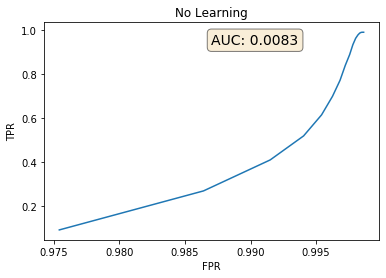

In [77]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-pur, eff)
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-pur, eff)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("No Learning")

## Vanilla Embedding

In [191]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean'}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="AdjacentEmbedding", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
for epoch in range(100):
    tic = tt() 
    model.train()
    cluster_pur, train_loss = train_all_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss))

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss, av_nhood_size = evaluate_all_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "av_nhood_size": av_nhood_size, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

In [193]:
%%time

homogeneity, completeness = evaluate_embedding_vmeasure(test_loader, 0.01, 3., 0.1)

CPU times: user 48.6 s, sys: 581 ms, total: 49.1 s
Wall time: 48 s


Text(0.5, 1.0, 'All-Layer Embedding')

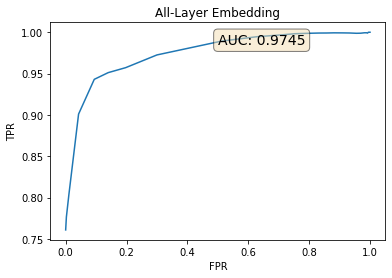

In [195]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-homogeneity, completeness)
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-homogeneity, completeness)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("All-Layer Embedding")

## Adjacent Embedding

We train with points in a neighbourhood as well as all true adjacent points. There is a subtlety around whether the radius graph should be bidirectional, in increasing r.

In [8]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        emb_feats = model(data)
               
        # Get fake edge list
        candidates = radius_graph(emb_feats, r=m_configs['r_train'], batch=batch.batch, loop=False, max_num_neighbors=200)
#         candidates = knn_graph(emb_feats, k=m_configs['k'], batch=batch.batch, loop=False)
        fake_list = candidates[:,batch.pid[candidates[0]] != batch.pid[candidates[1]]]
                
        # Concatenate all candidates
        e = torch.cat([fake_list, batch.true_edges.T.to(device)], axis=-1)
#         print(e.shape)
        
        reference = emb_feats.index_select(0, e[1])
        neighbors = emb_feats.index_select(0, e[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)
        
        y = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        hinge = y.float()
        hinge[hinge == 0] = -1
        
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, reduction=m_configs['reduction'], margin=m_configs['margin'])
        
        if ~(loss != loss):
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        correct += (y.float()).sum().item()
        total += len(e[0])
        
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    total_true_positive, total_positive, total_true, total_loss = 0, 0, 0, 0
    
    for batch in test_loader:
        data = batch.to(device)
        emb_feats = model(data)
        
        e = radius_graph(emb_feats, r=m_configs['r_val'], batch=batch.batch, loop=False, max_num_neighbors=200)
#         e = knn_graph(emb_feats, k=m_configs['k'], batch=batch.batch, loop=False)
#         print(e.shape)
        
        reference = emb_feats.index_select(0, e[1])
        neighbors = emb_feats.index_select(0, e[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)
        
        y = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        hinge = y.float()
        hinge[hinge == 0] = -1
        
        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, reduction=m_configs['reduction'], margin=m_configs['margin'])
        print("Loss:", loss.item())
        if ~(loss != loss):
            total_loss += loss.item()
        
        #Cluster performance
        true = len(batch.true_edges)
        total_true += true
        
        true_positive = (y.float()).sum().item()
        total_true_positive += true_positive

        positive = len(e[0])
        total_positive += max(positive, 1)
        
        print("True positive:", true_positive, "True:", true, "Positive", positive)

    eff = (total_true_positive / total_true)
    pur = (total_true_positive / total_positive)
        
    return eff, pur, total_loss

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Embedding(torch.nn.Module):
    def __init__(self, in_channels, nb_hidden, nb_layer, emb_dim=3):
        super(Embedding, self).__init__()
        layers = [Linear(in_channels, nb_hidden)]
        ln = [Linear(nb_hidden, nb_hidden) for _ in range(nb_layer-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(nb_hidden, emb_dim)
        self.norm = torch.nn.LayerNorm(nb_hidden)
        self.act = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.7)
#         self.mean = torch.FloatTensor(mean).to(torch.float)
#         self.std = torch.FloatTensor(std).to(torch.float)

    def forward(self, inputs):
        x = inputs.x
#         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
            # hits = self.dropout(hits)
        x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

    def normalize(self, hits):
        try:
            hits = (hits-self.mean) / (self.std + 10**-9)
        except:
            self.mean = self.mean.to(device=hits.device)
            self.std  = self.std.to(device=hits.device)
            hits = (hits-self.mean) / (self.std + 10**-9)
        return hits

In [30]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 0.8, "r_val": 1, "margin": 0.8, 'reduction':'mean'}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="AdjacentEmbedding", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [31]:
for epoch in range(100):
    tic = tt() 
    model.train()
    cluster_pur, train_loss = train_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss))

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss, av_nhood_size = evaluate_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "av_nhood_size": av_nhood_size, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 73.0337
Epoch: 0, Eff: 0.7353, Pur: 0.5769, Loss: 4.9129, LR: 0.001 in time 1.926849603652954
Training loss: 63.1491
Epoch: 1, Eff: 0.8087, Pur: 0.6111, Loss: 4.9498, LR: 0.001 in time 1.11873459815979
Training loss: 58.8370
Epoch: 2, Eff: 0.8845, Pur: 0.7210, Loss: 5.1555, LR: 0.001 in time 1.1775538921356201
Training loss: 62.1950
Epoch: 3, Eff: 0.8904, Pur: 0.6602, Loss: 4.9127, LR: 0.001 in time 1.0388009548187256
Training loss: 57.6600
Epoch: 4, Eff: 0.9204, Pur: 0.6966, Loss: 4.9928, LR: 0.001 in time 1.0707931518554688
Training loss: 58.0113
Epoch: 5, Eff: 0.9127, Pur: 0.6964, Loss: 5.0079, LR: 0.001 in time 1.0775763988494873
Training loss: 56.6805
Epoch: 6, Eff: 0.9170, Pur: 0.7204, Loss: 5.0443, LR: 0.001 in time 1.1016507148742676
Training loss: 56.3018
Epoch: 7, Eff: 0.9171, Pur: 0.7249, Loss: 4.9389, LR: 0.001 in time 1.0493979454040527
Training loss: 56.3480
Epoch: 8, Eff: 0.9112, Pur: 0.7202, Loss: 4.9229, LR: 0.001 in time 1.0704376697540283
Training loss

KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x2aab7ff9fef0> (for post_run_cell):


KeyboardInterrupt: 

In [93]:
%%time
model.eval()

e_min, e_max, e_step = 0.01, 3., 0.1
homogeneity, completeness = np.zeros(int(np.ceil((e_max - e_min)/e_step)), dtype=np.float), np.zeros(int(np.ceil((e_max - e_min)/e_step)), dtype=np.float)

for batch in test_loader:

    data = batch.to(device)
    spatial = model(data.x)
    
    for i, e in enumerate(np.arange(e_min, e_max, e_step)):    
        
        embedded = spatial.cpu().detach().numpy()
        db = DBSCAN(eps=e, min_samples=1).fit(embedded)
        labels = db.labels_
        labels_true = batch.pid.cpu().numpy()
        
        homogeneity[i] += metrics.homogeneity_score(labels_true, labels)
        completeness[i] += metrics.completeness_score(labels_true, labels)
#         print("Hom:", homogeneity[i], "Comp:", completeness[i])
homogeneity = homogeneity/len(test_dataset)
completeness = completeness/len(test_dataset)

CPU times: user 27 s, sys: 320 ms, total: 27.3 s
Wall time: 26.7 s


Text(0.5, 1.0, 'Vanilla Embedding')

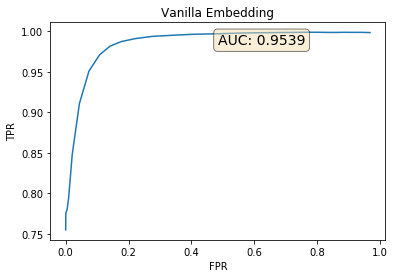

In [94]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-homogeneity, completeness)
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-homogeneity, completeness)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("Vanilla Embedding")

## Biadjacent Embedding

In this variation, we take the adjacency to be bi-directional. That is, a true neighbour is one that is on a neighbouring edge with the same PID, not just an **inner** edge.

In [4]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean'}
torch.manual_seed(torch_seed)
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="AdjacentEmbedding", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
for epoch in range(100):
    tic = tt() 
    model.train()
    cluster_pur, train_loss = train_bi_emb(model, train_loader, optimizer, other_configs)
    print('Training loss: {:.4f}'.format(train_loss))

    model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss, av_nhood_size = evaluate_bi_emb(model, test_loader, other_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "av_nhood_size": av_nhood_size, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_eff, cluster_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 639.7080
Epoch: 0, Eff: 0.8390, Pur: 0.5686, Loss: 50.1558, LR: 0.001 in time 26.081013202667236
Training loss: 569.4313
Epoch: 1, Eff: 0.9018, Pur: 0.5664, Loss: 46.5434, LR: 0.001 in time 24.95499014854431
Training loss: 549.2652
Epoch: 2, Eff: 0.8967, Pur: 0.6056, Loss: 48.3943, LR: 0.001 in time 25.132273197174072
Training loss: 538.4092
Epoch: 3, Eff: 0.9229, Pur: 0.6021, Loss: 47.1654, LR: 0.001 in time 25.53354525566101
Training loss: 531.2653
Epoch: 4, Eff: 0.9264, Pur: 0.6089, Loss: 46.1559, LR: 0.001 in time 25.18735146522522
Training loss: 525.5441
Epoch: 5, Eff: 0.9123, Pur: 0.6384, Loss: 48.3396, LR: 0.001 in time 25.151153802871704
Training loss: 519.8918
Epoch: 6, Eff: 0.9228, Pur: 0.6315, Loss: 47.3222, LR: 0.001 in time 25.23466157913208
Training loss: 515.6195
Epoch: 7, Eff: 0.9062, Pur: 0.6514, Loss: 48.4373, LR: 0.001 in time 25.653947353363037
Training loss: 511.7437
Epoch: 8, Eff: 0.9062, Pur: 0.6492, Loss: 48.0921, LR: 0.001 in time 25.253525257110

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-9b372d458824>", line 4, in <module>
    cluster_pur, train_loss = train_bi_emb(model, train_loader, optimizer, other_configs)
  File "../trainers.py", line 171, in train_bi_emb
    cluster_true_positive = (y_cluster.float()).sum().item()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/p

KeyboardInterrupt: 

### ROC Results

Want to get efficiency also, which is number of particles in batch with same PID, under the number of particles in neighbourhood with same PID. Use neighbours and reference with batch.pid

In [ ]:
checkpoint = torch.load('model_comparisons/embedding/daily-planet-278.tar')
checkpoint['config']

In [14]:
m_configs = {"in_channels": 3, "nb_hidden": 64, "nb_layer": 4, "emb_dim": 8}
other_configs = {"k": 50, "r": 1, "margin": 0.5}
model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
%%time

r_min, r_max, r_step = 0.1, 7., 0.01
pur, eff, f1 = evaluate_embedding_f1(test_loader, model, r_min, r_max, r_step)

Text(0.5, 1.0, 'Biadjacent Embedding')

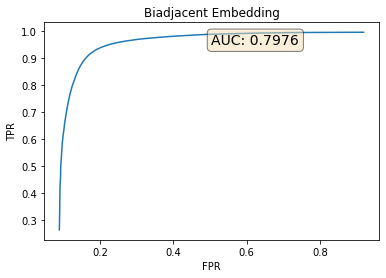

In [49]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-pur[35:], eff[35:])
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-pur[35:], eff[35:])), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("Biadjacent Embedding")

### F1 Results

In [6]:
%%time

r_min, r_max, r_step = 0.8, 2., 0.1
pur, eff, f1 = evaluate_embedding_f1(test_loader, model, r_min, r_max, r_step)

CPU times: user 32.2 s, sys: 2.68 s, total: 34.9 s
Wall time: 18.4 s


Text(0.5, 1.0, 'Biadjacent Embedding')

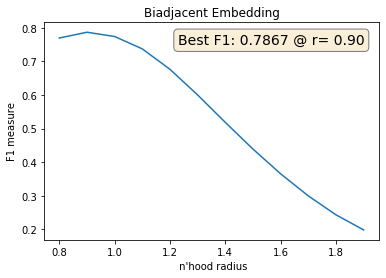

In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(r_min, r_max, r_step), f1)
ax.text(0.4, 0.95, "Best F1: {:.4f} @ r= {:.2f}".format(max(f1), r_min+r_step*np.argmax(f1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel(" n'hood radius"), ax.set_ylabel("F1 measure")
ax.set_title("Biadjacent Embedding")

### V-measure Results

In [18]:
%%time

homogeneity, completeness = evaluate_embedding_vmeasure(test_loader, model, 0.01, 3., 0.1)

CPU times: user 27.4 s, sys: 20 ms, total: 27.4 s
Wall time: 27.5 s


Text(0.5, 1.0, 'Biadjacent Embedding')

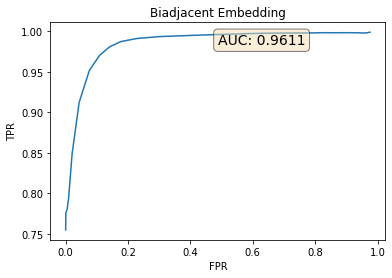

In [20]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-homogeneity, completeness)
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-homogeneity, completeness)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("Biadjacent Embedding")

torch.Size([2, 31116])
Loss: 0.3827403485774994
True positive: 13990.0 Positive 17850 True 14414
torch.Size([2, 31000])
Loss: 0.38030514121055603
True positive: 13658.0 Positive 17726 True 14060
torch.Size([2, 29244])
Loss: 0.38295266032218933
True positive: 12832.0 Positive 16710 True 13192
torch.Size([2, 33792])
Loss: 0.379316121339798
True positive: 13860.0 Positive 18966 True 14288
torch.Size([2, 22312])
Loss: 0.3762139678001404
True positive: 10560.0 Positive 12908 True 10842
torch.Size([2, 33196])
Loss: 0.3814031481742859
True positive: 14596.0 Positive 18974 True 15056
torch.Size([2, 25797])
Loss: 0.39040473103523254
True positive: 11465.0 Positive 14378 True 12296
torch.Size([2, 35066])
Loss: 0.3735175132751465
True positive: 15108.0 Positive 19816 True 15686
torch.Size([2, 29026])
Loss: 0.38128945231437683
True positive: 12884.0 Positive 16726 True 13180
torch.Size([2, 32034])
Loss: 0.3800124526023865
True positive: 13718.0 Positive 18134 True 13942
Purity: 0.7704963731713408 

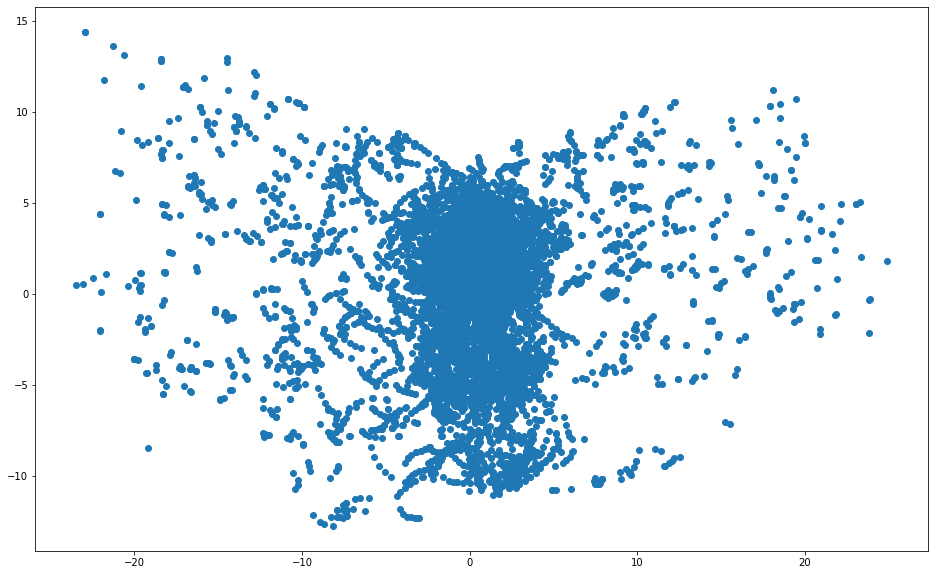

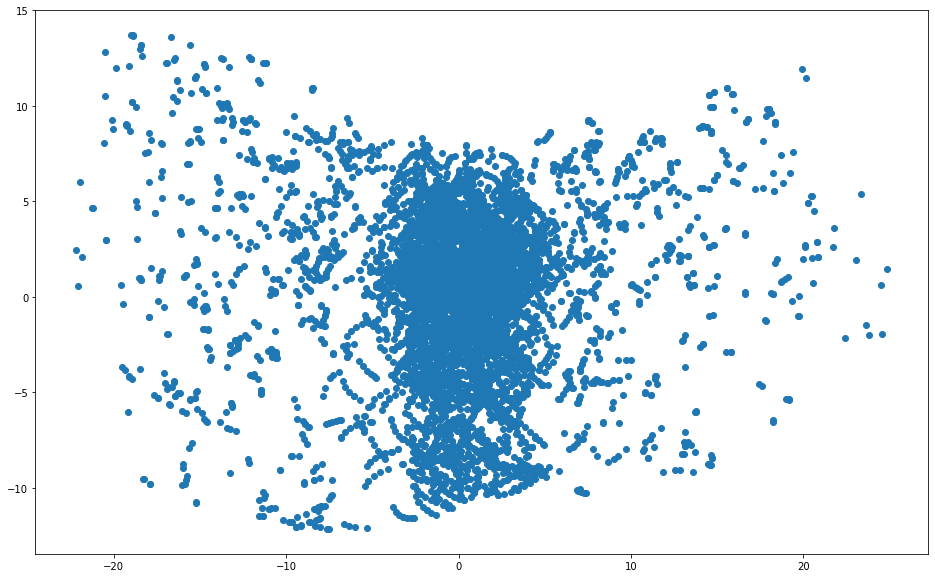

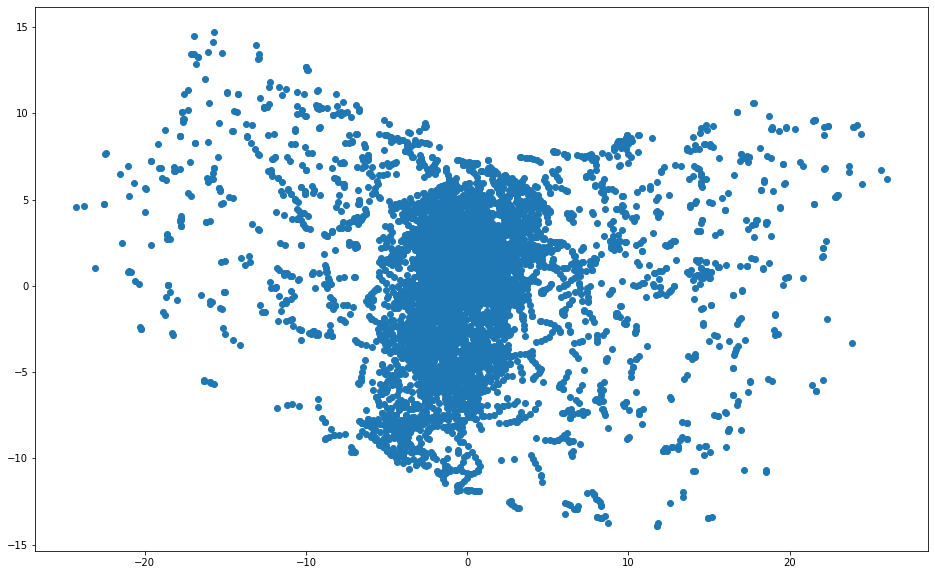

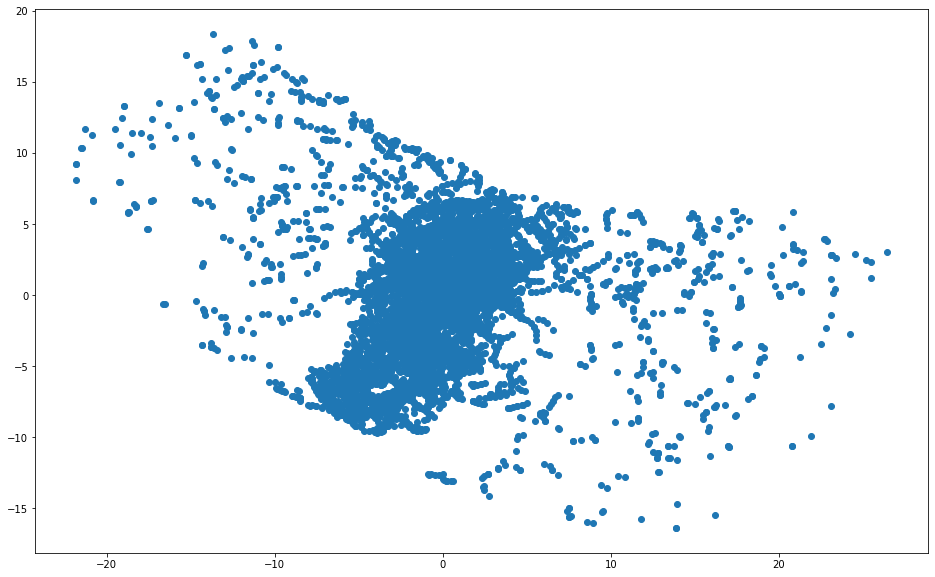

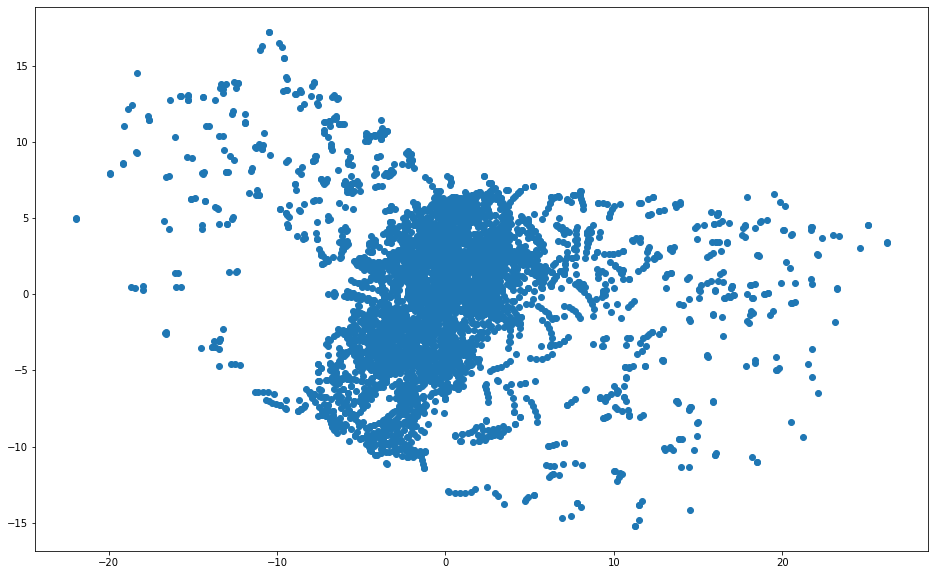

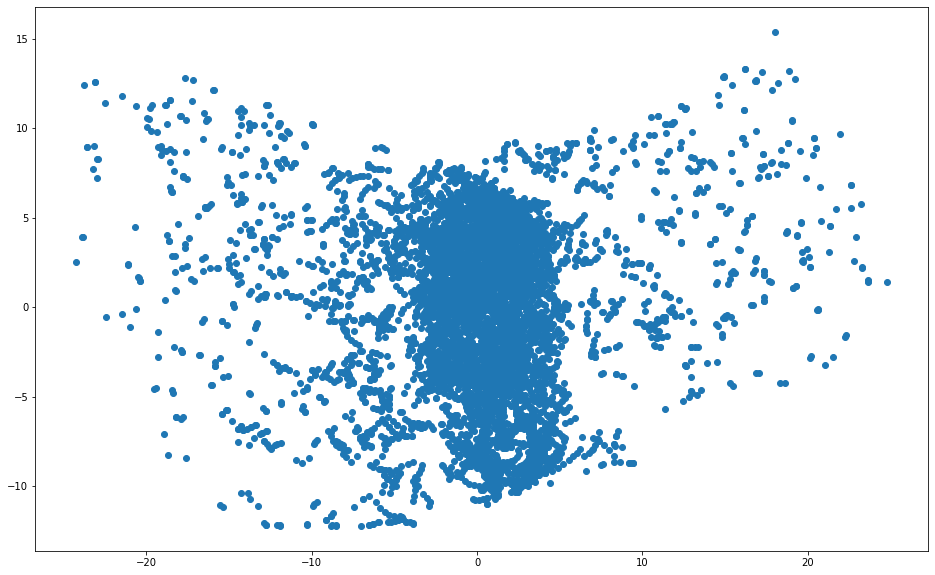

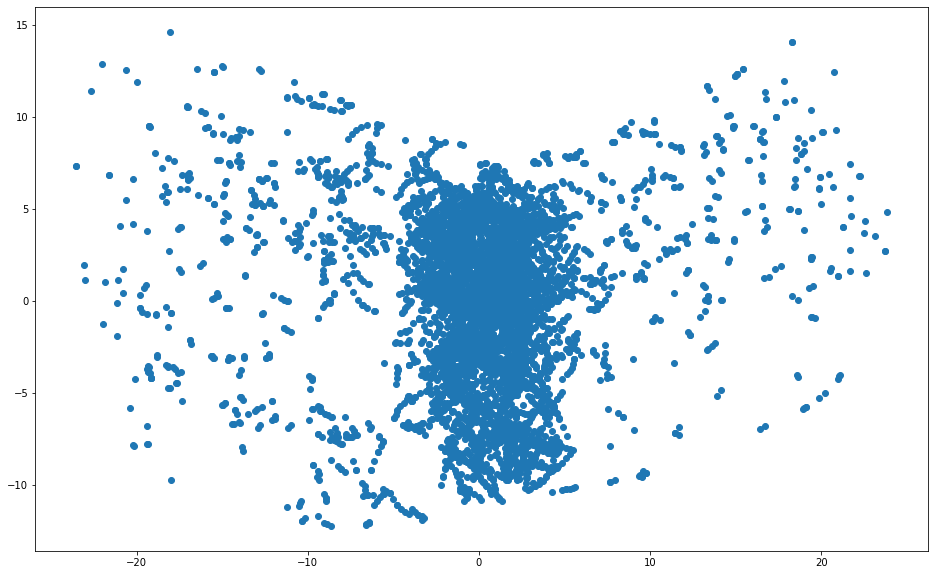

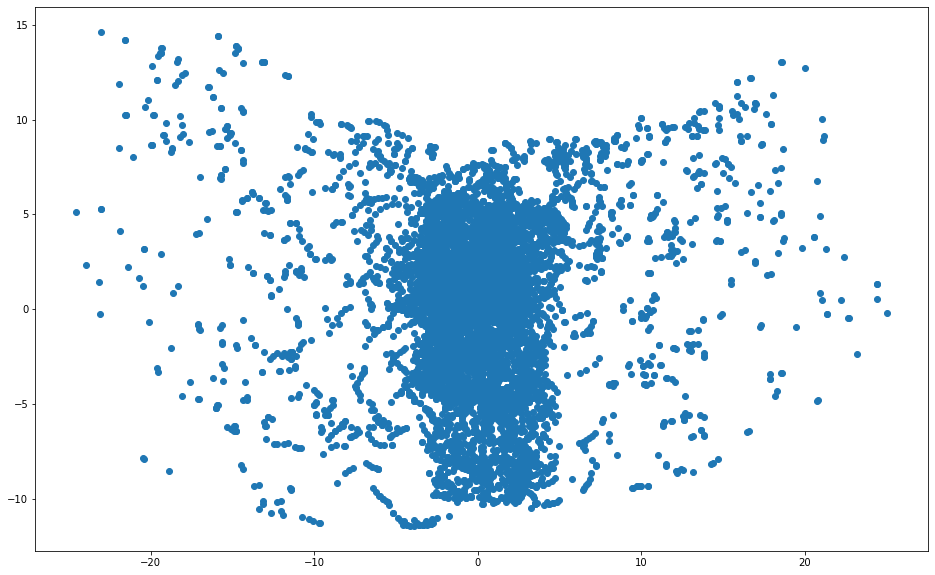

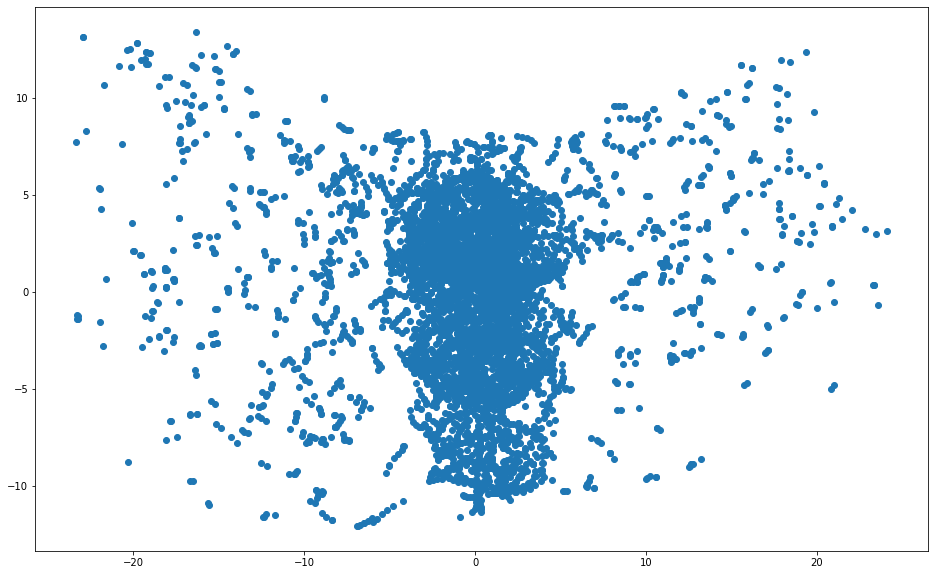

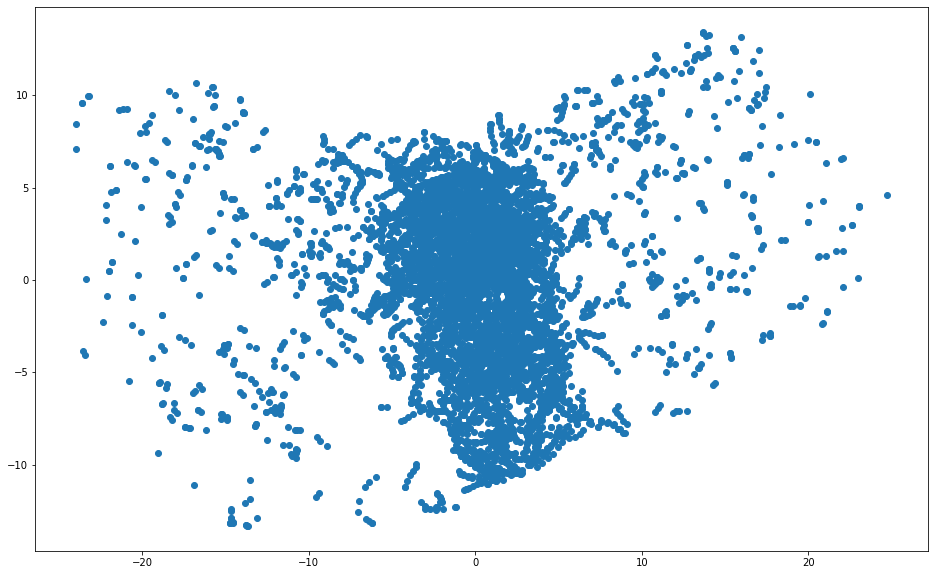

In [33]:
model.eval()
correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0

for batch in test_loader:
    data = batch.to(device)
    spatial = model(data.x)

    e_spatial = build_edges(spatial, 1, 100, res)
    e_adjacent = e_spatial[:, ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]]) == 1) | ((batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]]) == 1)]
    print(e_spatial.shape)

    embedded = spatial.cpu().detach().numpy()
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embedded)
    plt.figure(figsize=(16,10))
    plt.scatter(pca_result[:,0], pca_result[:,1])

    reference = spatial.index_select(0, e_spatial[1])
    neighbors = spatial.index_select(0, e_spatial[0])

    d = torch.sum((reference - neighbors)**2, dim=-1)

    y = (batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) | (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1))
    
    hinge = y.float()
    hinge[hinge == 0] = -1

    loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=other_configs['margin'])
    print("Loss:", loss.item())
    total_loss += loss.item()

    true = 2*len(batch.true_edges)
    true_positive = (y.float()).sum().item()
    positive = len(e_adjacent[0])

#         true_positive += (true & positive).sum().item()

    total_positive += positive
    total_true += true
    correct += true_positive


    print("True positive:", true_positive, "Positive", positive, "True", true)

pur = correct / total_positive
eff = correct / total_true
print("Purity:", pur, "Efficiency:", eff)


In [164]:
embedded = spatial.cpu().detach().numpy()
pca = PCA(n_components=3)
px = pca.fit_transform(embedded)

In [186]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(embedded, labels))

Homogeneity: 0.938
Completeness: 0.918
V-measure: 0.928
Adjusted Rand Index: 0.533
Adjusted Mutual Information: 0.768
Silhouette Coefficient: 0.229


In [185]:
db = DBSCAN(eps=0.33, min_samples=1).fit(embedded)
labels = db.labels_
labels_true = batch.pid.cpu().numpy()

In [165]:
P = batch.pid.unique()[0]
Pmask = (batch.pid == P).cpu()
x = batch.x.cpu()

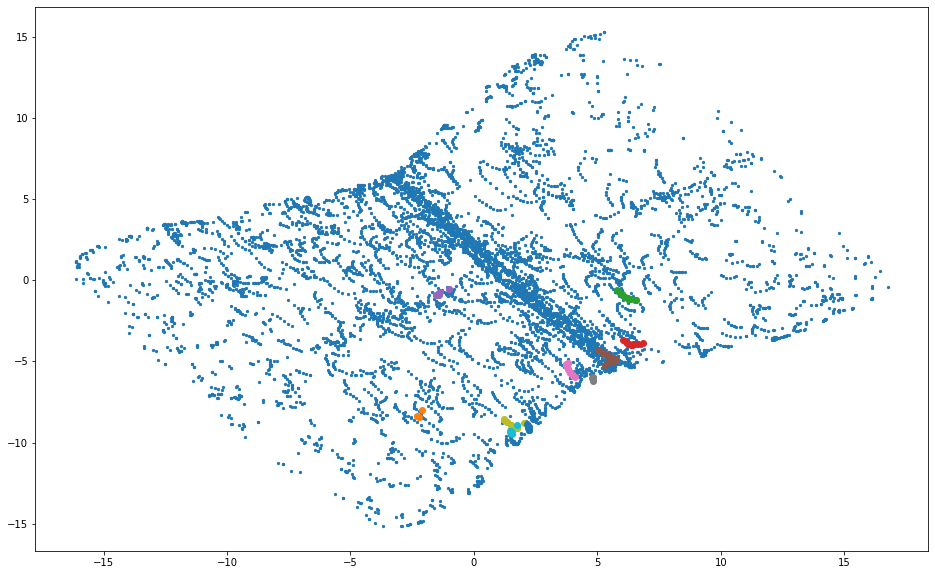

In [166]:
plt.figure(figsize=(16,10))
plt.scatter(px[:,0], px[:,1], s=5)
for P in batch.pid.unique()[10:20]:
    Pmask = (batch.pid == P).cpu()
    plt.scatter(px[Pmask,0], px[Pmask,1])

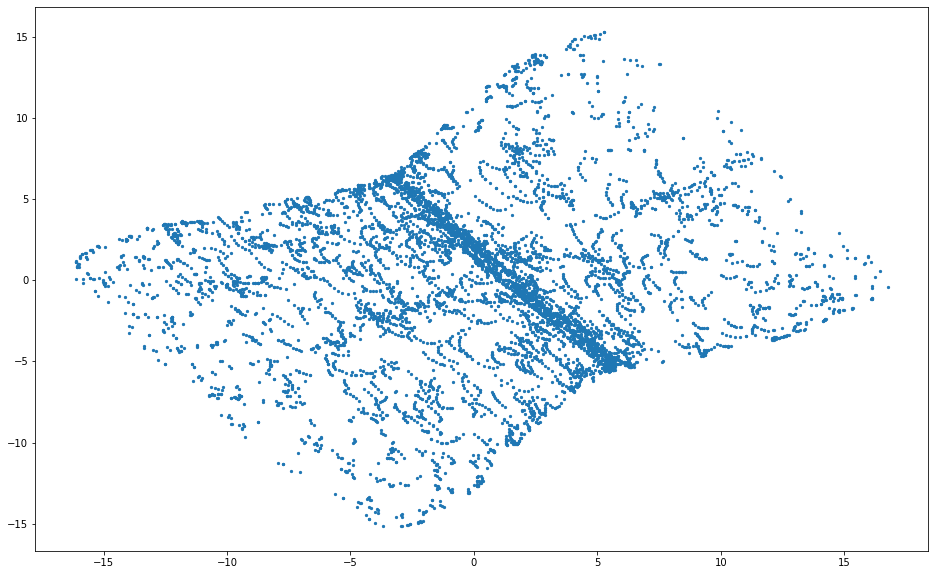

In [167]:
plt.figure(figsize=(16,10))
plt.scatter(px[:,0], px[:,1], s=5)
for P in np.unique(labels)[10:20]:
    Pmask = (labels == P)
    plt.scatter(px[Pmask,0], px[Pmask,1])

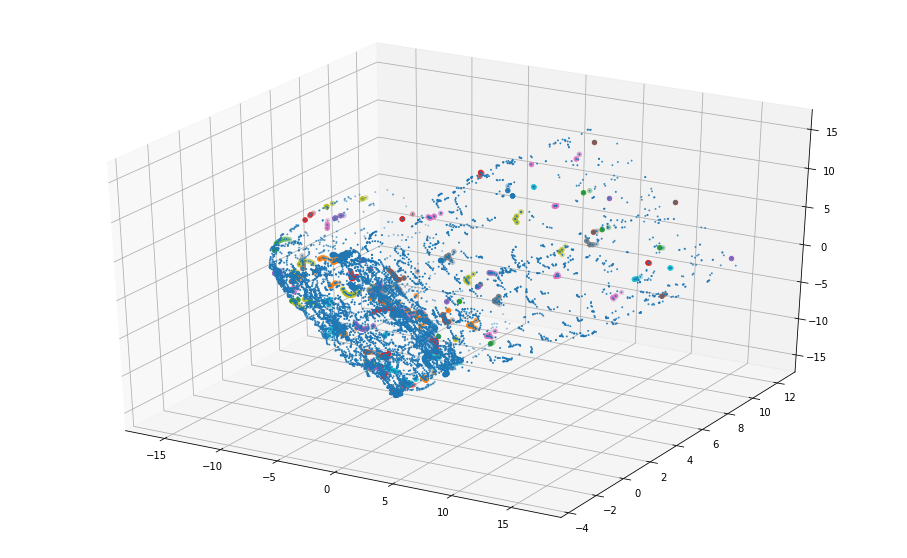

In [168]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px[:,0], px[:,2], px[:,1], s=1)
for P in batch.pid.unique()[::10]:
    Pmask = (batch.pid == P).cpu()
    ax.scatter(px[Pmask,0], px[Pmask,2], px[Pmask,1])

## Filter Model

First, we prepare the data to be trained on

In [44]:
r = 2.7
step = int((r-r_min)/r_step)
pur[step], eff[step]

(0.17959065291190138, 0.9946552177341628)

In [ ]:
embedding_model = model

In [42]:
filter_train_dataset = [classify_event(model, batch, r=1.4) for batch in train_loader]
filter_test_dataset = [classify_event(model, batch, r=1.4) for batch in test_loader]

In [43]:
filter_train_loader = DataLoader(filter_train_dataset, batch_size=1, shuffle=True)
filter_test_loader = DataLoader(filter_test_dataset, batch_size=1, shuffle=True)

In [ ]:
plt.figure(figsize=(20,10))
x, e, pid = filter_train_dataset[0].x.cpu().numpy(), filter_train_dataset[0].e.cpu().numpy(), filter_train_dataset[0].pid.cpu().numpy()
y = pid[e[0]] == pid[e[1]]
fig = plt.plot([x[e[0,~y], 0], x[e[1,~y], 0]], [x[e[0,~y], 1], x[e[1,~y], 1]] , color='r')
fig = plt.plot([x[e[0,y], 0], x[e[1,y], 0]], [x[e[0,y], 1], x[e[1,y], 1]] , color='k')

### Model Def

In [44]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, nb_layer=4, hidden_dim=8, hidden_activation=torch.nn.Tanh,
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim]*nb_layer + [1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class Edge_MLP(nn.Module):
    def __init__(self, in_channels, emb_hidden, nb_layer, emb_dim=3):
        super(Edge_MLP, self).__init__()

        self.input_layer = nn.Linear(in_channels, emb_hidden)
        self.edge_network = EdgeNetwork(emb_hidden, nb_layer, emb_hidden)
        self.final_layer = nn.Linear(emb_hidden, 1)
        self.norm = torch.nn.LayerNorm(emb_hidden)
        
    def forward(self, data):
        x = self.input_layer(data.x)
        x = self.norm(x)
        e = self.edge_network(x, data.e)
        return e

In [45]:
sig = torch.nn.Sigmoid()

def train_filter(model, filter_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(filter_train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
              
        y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]
                
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        
        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total += true.sum().item()
    acc = correct/total
    return acc, total_loss

def evaluate_filter(model, filter_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in filter_test_loader:
        data = batch.to(device)
        pred = model(data)
              
        y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]
                
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        total_loss += loss.item()
        
        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)
        
        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)
        
#         print("True positive:", (true & positive).sum().item(), "True:", true.sum().item(), "Positive", positive.sum().item())
        
        total += len(pred)

    eff = (true_positive / total_true)
    pur = (true_positive / total_positive)
        
    return eff, pur, total_loss

### Train & Evaluate

In [65]:
m_configs = {"in_channels": 3, "emb_hidden": 128, "nb_layer": 3, "emb_dim": 8}
other_configs = {"weight": 1}
model = Edge_MLP(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="AdjacentEmbedding", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
for epoch in range(100):
    tic = tt() 
    model.train()
    pur, train_loss = train_filter(model, filter_train_loader, optimizer, m_configs)
    print('Training loss: {:.4f}'.format(train_loss))

    model.eval()
    with torch.no_grad():
        eff, pur, val_loss = evaluate_filter(model, filter_test_loader, m_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_pur": pur, "edge_eff": eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, eff, pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

### Results

In [61]:
model.eval()

total_pred = []
total_y = []

for batch in filter_test_loader:
    data = batch.to(device)
    pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += pred.detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

In [62]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

In [ ]:
list(zip(fpr[tpr>0.99], tpr[tpr>0.99]))

Text(0.5, 1.0, 'Filter over Biadjacent Embedding')

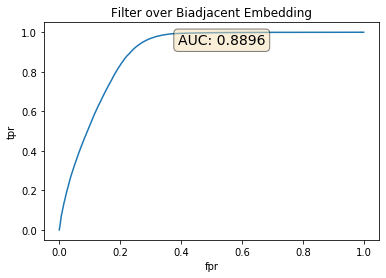

In [63]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.95, "AUC: {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("Filter over Biadjacent Embedding")

For the case of pT>1GeV, filter doesn't seem to have much effect.

## GNN Edge Classification

### Prepare Edges from Embedding

In [15]:
@torch.no_grad()
def classify_gnn_event(model, batch, r):
    model.eval()
    data = batch.to(device)
    
    spatial = model(data.x)
        
    e_spatial = build_edges(spatial, r, 100, res)
    e_adjacent = e_spatial[:, ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]]) == 1)]
    
    e_adjacent = remove_duplicate_edges(data.x.cpu().numpy(), e_adjacent.cpu().numpy()).astype(int)
    y = batch.pid[e_adjacent[0]] == batch.pid[e_adjacent[1]]
    
    data = Data(x = data.x.cpu(), y = y.float().cpu(), emb = spatial.cpu(), pid = data.pid.cpu(), e = torch.from_numpy(e_adjacent).int(), layers = data.layers.cpu(), true_edges = data.true_edges.cpu())
    return data

In [16]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean'}
torch.manual_seed(torch_seed)
embedding_model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
checkpoint = torch.load('../model_comparisons/Embedding/dry-puddle-502.tar')
embedding_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
r = 1.8
# step = int((r-r_min)/r_step)
# print(pur[step], eff[step])
# cluster_eff = eff[step]

In [18]:
%%time
gnn_train_dataset = [classify_gnn_event(embedding_model, batch, r=r) for batch in train_loader]
gnn_test_dataset = [classify_gnn_event(embedding_model, batch, r=r) for batch in test_loader]

CPU times: user 1min 28s, sys: 7.26 s, total: 1min 36s
Wall time: 1min 6s


In [19]:
gnn_train_loader = DataLoader(gnn_train_dataset, batch_size=1, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_dataset, batch_size=1, shuffle=True)

In [25]:
del embedding_model
del checkpoint

In [26]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/(1024**2), "MB")

0.0 MB


### Load Graph Data

In [3]:
pt_cut = 0.5
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/"
gnn_train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_graphs_train")
gnn_test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_graphs_test")

In [4]:
%%time
gnn_train_dataset = torch.load(gnn_train_path)
gnn_test_dataset = torch.load(gnn_test_path)
gnn_train_loader = DataLoader(gnn_train_dataset, batch_size=1, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_dataset, batch_size=1, shuffle=True)

CPU times: user 233 ms, sys: 2.77 s, total: 3.01 s
Wall time: 3.66 s


### Train

New model:

In [13]:
m_configs = {"in_channels": 3, "hidden_dim": 64, "n_graph_iters": 6}
torch.manual_seed(torch_seed)
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 2}
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="ResAGNN", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


...or load model:

In [14]:
m_configs = {"in_channels": 3, "hidden_dim": 64, "n_graph_iters": 6}
torch.manual_seed(torch_seed)
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 2}
m_configs.update(other_configs)
checkpoint = torch.load('../model_comparisons/ResAGNN/ethereal-wood-503.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model_name = wandb.init(project="GravNet", group="ResAGNN", config=m_configs)
wandb.watch(model, log='all')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [16]:
for epoch in range(100):
    tic = tt()  
    model.train()
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 25.063142077997327
Epoch: 0, Accuracy: 0.9929, Purity: 0.9604, Efficiency: 0.9898, Loss: 2.3208, LR: 0.001 in time 211.51566171646118
Training loss: 24.163852674886584
Epoch: 1, Accuracy: 0.9930, Purity: 0.9612, Efficiency: 0.9890, Loss: 2.3506, LR: 0.001 in time 211.6275191307068
Training loss: 23.775235688313842
Epoch: 2, Accuracy: 0.9937, Purity: 0.9663, Efficiency: 0.9894, Loss: 2.1385, LR: 0.001 in time 211.61263060569763
Training loss: 23.52497413009405
Epoch: 3, Accuracy: 0.9879, Purity: 0.9304, Efficiency: 0.9864, Loss: 3.7791, LR: 0.001 in time 211.66961789131165
Training loss: 23.31285702250898
Epoch: 4, Accuracy: 0.9931, Purity: 0.9628, Efficiency: 0.9884, Loss: 2.3456, LR: 0.001 in time 211.37088584899902
Training loss: 23.0078675923869
Epoch: 5, Accuracy: 0.9938, Purity: 0.9652, Efficiency: 0.9910, Loss: 2.0477, LR: 0.001 in time 211.63346529006958
Training loss: 22.563860021531582
Epoch: 6, Accuracy: 0.9934, Purity: 0.9631, Efficiency: 0.9901, Loss: 2.2067,

KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x2aab7fe45d40> (for post_run_cell):


KeyboardInterrupt: 

### ROC Results

In [17]:
model.eval()

total_pred = []
total_y = []

for batch in gnn_test_loader:
    data = batch.to(device)
    with torch.no_grad():
        pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += pred.detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

In [18]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

Text(0.5, 1.0, 'AGNN over Biadjacent Embedding')

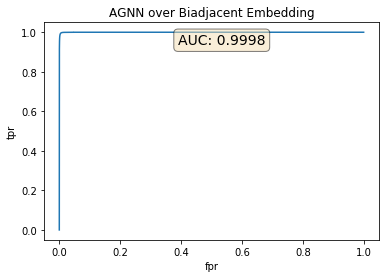

In [19]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.95, "AUC: {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("AGNN over Biadjacent Embedding")

Text(0.5, 1.0, 'AGNN over Biadjacent Embedding')

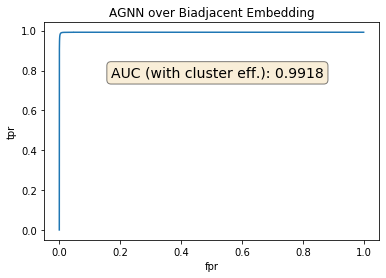

In [20]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr*cluster_eff)
ax.text(0.2, 0.8, "AUC (with cluster eff.): {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)*cluster_eff), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("AGNN over Biadjacent Embedding")

### F1 Results

In [124]:
thresh = 0.4
list(zip(fpr[(fpr) > thresh], tpr[fpr > thresh]))

[(0.4455550437586366, 0.9999556613115385),
 (0.445601105481345, 0.9999556613115385),
 (0.45520497466605253, 0.9999556613115385),
 (0.45525103638876097, 0.9999556613115385),
 (0.45794564716720404, 0.9999556613115385),
 (0.4579917088899125, 0.9999556613115385),
 (0.46722708429295257, 0.9999556613115385),
 (0.467273146015661, 0.9999556613115385),
 (0.48224320589590053, 0.9999556613115385),
 (0.48224320589590053, 0.9999704408743589),
 (0.4847305389221557, 0.9999704408743589),
 (0.4847766006448641, 0.9999704408743589),
 (0.49456471672040536, 0.9999704408743589),
 (0.4946107784431138, 0.9999704408743589),
 (0.5251497005988024, 0.9999704408743589),
 (0.5251957623215108, 0.9999704408743589),
 (0.5346614463380931, 0.9999704408743589),
 (0.5347075080608015, 0.9999704408743589),
 (0.5854905573468447, 0.9999704408743589),
 (0.5855366190695532, 0.9999704408743589),
 (0.5894288346384154, 0.9999704408743589),
 (0.5894748963611239, 0.9999704408743589),
 (0.5923767848917549, 0.9999704408743589),
 (0.59

In [21]:
model.eval()

total_pred = []
total_y = []

for batch in gnn_test_loader:
    data = batch.to(device)
    with torch.no_grad():
        pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += sig(pred).detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

Text(0.5, 1.0, 'GNN on Biadjacent Embedding')

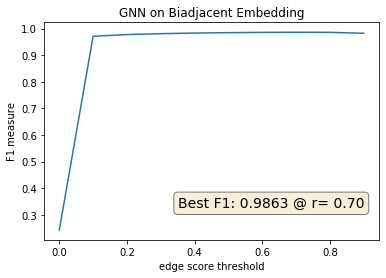

In [27]:
fig, ax = plt.subplots()
f1 = [metrics.f1_score(total_y, np.array(total_pred)>thresh) for thresh in np.arange(0,1,0.1)]
ax.plot(np.arange(0,1,0.1), f1)
ax.text(0.4, 0.2, "Best F1: {:.4f} @ r= {:.2f}".format(max(f1), 0.1*np.argmax(f1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("edge score threshold"), ax.set_ylabel("F1 measure")
ax.set_title("GNN on Biadjacent Embedding")

## Mixed Precision GNN

In [41]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
#         print(start.type(), end.type())
#         print("x_in", np.isnan(x.cpu().detach().numpy()).sum())
#         print("start, end", np.isnan(start.cpu().detach().numpy()).sum(), np.isnan(end.cpu().detach().numpy()).sum())
        x1, x2 = x[start], x[end]
#         print("x length", len(x), "End", end.max().item())
#         print("x1, x2", np.isnan(x1.cpu().detach().numpy()).sum(), np.isnan(x2.cpu().detach().numpy()).sum())
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
#         print("edge_inputs", np.isnan(edge_inputs.cpu().detach().numpy()).sum())
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)
    
class ResAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(ResAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
#         self.layerNorm = torch.nn.LayerNorm(in_channels + hidden_dim)
        
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""
        
#         print("E type (in model)", edge_index.type())
#         print("x type (in model)", x.type())
                
#         print("End long (in model)", inputs.e.long().max().item(), inputs.e.long())
#         print("Edge shape (in model)", inputs.e.shape)
        x_in = x
#         print(x.shape)
        x = self.input_network(x)
#         print("x type (after NN1)", x.type())
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, x_in], dim=-1)
#         print("x type (after cat)", x.type())
#         print(x.shape)
#         print(x)
#         print(edge_index.type())
#         print("x", np.isnan(x.cpu().detach().numpy()).sum())
#         print("x length", len(x), "End", edge_index.max().item())
        edge_index = edge_index#.long()
#         print("E type (after cast)", edge_index.type())
    
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, edge_index))
#             print("e type", e.type())
#             print("e", np.isnan(e.cpu().detach().numpy()).sum())
            # Apply node network
            x = self.node_network(x, e, edge_index)
#             print(edge_index.type())
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, x_in], dim=-1)  
            
            x = x_inital + x
#             x = self.layerNorm(x)
#         print("x out", np.isnan(x.cpu().detach().numpy()).sum())
#         print("x type (final)", x.type())
        return self.edge_network(x, edge_index)

In [47]:
def train_mixed_gnn(model, gnn_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    data_time, pred_time, loss_time, loss_back_time, optimizer_step = 0, 0, 0, 0, 0
    for i, batch in enumerate(gnn_train_loader):
        optimizer.zero_grad()
        tic = tt()
        data = batch.to(device)
        data_time += tt()-tic
#         print("Edge float", data.e.max().item(), data.e)
#         print("Edge long", data.e.long().max().item(), data.e.long())
#         print("Edge shape", data.e.shape)
        
#         pred = model(data.x, data.edge_index.int())
        tic = tt()
        pred = model(data.x, data.edge_index)
        pred_time += tt()-tic
#         print("Pred type", pred.type())
        y = batch.y
#         print("y", np.isnan(y.cpu().detach().numpy()).sum())
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        tic = tt()
        loss = F.binary_cross_entropy_with_logits(pred.float(), y, pos_weight=torch.tensor(m_configs["weight"]))
        loss_time += tt()-tic
#         with amp.scale_loss(loss, optimizer) as scaled_loss:
#             scaled_loss.backward()
        tic = tt()
        loss.backward()
        loss_back_time += tt()-tic
#         torch.nn.utils.clip_grad_norm_(model.parameters(), m_configs["clip"])
        tic = tt()
        optimizer.step()
        optimizer_step += tt()-tic
        
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total += len(pred)
#         else:
#             print("Broke!")
        if(i%50==0): print(i, "batches")
        
    acc = correct/max(total, 1)
    print("data_time, pred_time, loss_time, loss_back_time, optimizer_step")
    print(data_time, pred_time, loss_time, loss_back_time, optimizer_step)
    return acc, total_loss

def evaluate_mixed_gnn(model, gnn_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in gnn_test_loader:
        data = batch.to(device)
#         pred = model(data.x, data.edge_index.int())
        pred = model(data.x, data.edge_index)
              
        y = batch.y

#         print("y", y, "length", len(y))
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
#         print("true", true, "sum", true.float().sum().item())
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)

#         print("True positive:", (true & positive).sum().item(), "True:", true.sum().item(), "Positive", positive.sum().item())

        total += len(pred)

    acc = correct/max(total, 1)
    eff = (true_positive / max(total_true, 1))
    pur = (true_positive / max(total_positive, 1))
    
#     print("Num total_true:", total_true, "Num total_positive:", total_positive, "Num true_positive:", true_positive, "Total edges:", total)
        
    return acc, eff, pur, total_loss

In [50]:
m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 8}
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 3}
torch.manual_seed(torch_seed)
m_configs.update(other_configs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
# optimizer = optimizers.FusedAdam(model.parameters(), lr = 0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

In [44]:
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", min_loss_scale=1)#, master_weights=False)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [ ]:
torch.backends.cudnn.benchmark = True
for epoch in range(1):
    tic = tt()  
    model.train()
    acc, train_loss = train_mixed_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_mixed_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
#     wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

#     save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')
    print("End of epoch mem:", torch.cuda.memory_allocated(device=device)/(1024**2), "MB")
    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

0 batches
50 batches
100 batches
150 batches
200 batches
250 batches
300 batches
350 batches
400 batches
450 batches
500 batches
550 batches
600 batches
650 batches
700 batches
750 batches
800 batches
850 batches
900 batches
950 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
2.167310953140259 11.406641483306885 0.3886888027191162 189.06701827049255 3.0920064449310303
Training loss: 169.12550830841064


### Memory Report

In [33]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   32640 KB |    5172 MB |   13444 GB |   13444 GB |
|       from large pool |   29256 KB |    5157 MB |   13201 GB |   13201 GB |
|       from small pool |    3384 KB |      77 MB |     242 GB |     242 GB |
|---------------------------------------------------------------------------|
| Active memory         |   32640 KB |    5172 MB |   13444 GB |   13444 GB |
|       from large pool |   29256 KB |    5157 MB |   13201 GB |

In [25]:
torch.cuda.reset_max_memory_cached(device=device)

In [156]:
# torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/(1024**2), "MB")

49.02587890625 MB


### Test Batch Memory

In [10]:
def fix_y_batch(batch):
    
    data = Data(x = batch.x, y = batch.y, edge_index = batch.e.long())
    
    return data

In [11]:
%%time
gnn_train_dataset_fix = [fix_y_batch(batch) for batch in gnn_train_dataset]
gnn_test_dataset_fix = [fix_y_batch(batch) for batch in gnn_test_dataset]

CPU times: user 577 ms, sys: 2.12 s, total: 2.7 s
Wall time: 1.4 s


In [35]:
%%time
gnn_train_loader = DataLoader(gnn_train_dataset_fix, batch_size=1, shuffle=False, num_workers=4)
gnn_test_loader = DataLoader(gnn_test_dataset_fix, batch_size=1, shuffle=False, num_workers=4)

CPU times: user 0 ns, sys: 100 µs, total: 100 µs
Wall time: 105 µs


In [27]:
%%time
model.eval()
with torch.no_grad():
    for i, batch in enumerate(gnn_train_loader):            
#             print(batch)
            data = batch.to(device)
            pred = model(data.x, data.edge_index.int())
            if(i%100==0): print(i, "samples evaluated")

0 samples evaluated
CPU times: user 31.3 s, sys: 11.4 s, total: 42.7 s
Wall time: 43.7 s


# End-to-End Architectures

The following combine variations of the baseline architectures into models that can propagate gradients from stage to stage.

## EmbFilter

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Embedding(torch.nn.Module):
    def __init__(self, in_channels, nb_hidden, nb_layer, emb_dim=3):
        super(Embedding, self).__init__()
        layers = [Linear(in_channels, nb_hidden)]
        ln = [Linear(nb_hidden, nb_hidden) for _ in range(nb_layer-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(nb_hidden, emb_dim)
        self.norm = torch.nn.LayerNorm(nb_hidden)
        self.act = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.7)
#         self.mean = torch.FloatTensor(mean).to(torch.float)
#         self.std = torch.FloatTensor(std).to(torch.float)

    def forward(self, x):
#         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
            # hits = self.dropout(hits)
        x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

    def normalize(self, hits):
        try:
            hits = (hits-self.mean) / (self.std + 10**-9)
        except:
            self.mean = self.mean.to(device=hits.device)
            self.std  = self.std.to(device=hits.device)
            hits = (hits-self.mean) / (self.std + 10**-9)
        return hits

class FilterNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(FilterNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)


In [51]:
class EmbFilter(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, hidden_dim=8,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbFilter, self).__init__()
        self.r = r
        # Setup the input network
        self.filter_network = FilterNetwork(in_channels + emb_dim, hidden_dim, hidden_activation, layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(in_channels, emb_hidden, nb_layer, emb_dim)
                
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        x = self.emb_network(x)
        
        edge_index = build_edges(x, self.r, 100, res)
        edge_index = edge_index[:, ((inputs.layers[edge_index[1]] - inputs.layers[edge_index[0]]) == 1)
                               | ((inputs.layers[edge_index[0]] - inputs.layers[edge_index[1]]) == 1)]
        
        # Apply filter network
        e = self.filter_network(torch.cat([x, inputs.x], axis=-1), edge_index)
                
        return e, x, edge_index

In [52]:
def train_embfilter(model, train_loader, optimizer, loss_fn, m_configs):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        # Get fake edge list
        candidates = build_edges(spatial, m_configs['r_train'], 100, res)
        fake_list = candidates[:, (batch.pid[candidates[0]] != batch.pid[candidates[1]])
                              & ~((batch.layers[candidates[1]] - batch.layers[candidates[0]] == 1) 
                  | (batch.layers[candidates[0]] - batch.layers[candidates[1]] == 1))]
        
#         print(batch.pid[fake_list[0]] == batch.pid[fake_list[1]])
        
        # Concatenate all candidates
        e_spatial = torch.cat([fake_list, batch.true_edges.T.to(device), 
                               torch.stack([batch.true_edges[:,1], batch.true_edges[:,0]], axis=0).to(device)], axis=-1)        

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = (batch.pid[e[0]] == batch.pid[e[1]])
        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) 
                  & ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) 
                  | (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1)))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1 

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(m_configs["weight"]))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_fn([loss_1.to(device), loss_2.to(device)])
#         print("Loss:", loss, "Noise params:", loss_fn.noise_params)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # Performance
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/max(total, 1)
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return total_loss

def evaluate_embfilter(model, test_loader, loss_fn, m_configs):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss, total_loss_1, total_loss_2 = 0, 0, 0
    total_av_nhood_size, total_av_adjacent_nhood_size = 0, 0
#     print('Beginning evaluation')
    for i, batch in enumerate(test_loader):
        data = batch.to(device)
        pred, spatial, e = model(data)
        e_spatial = build_edges(spatial, m_configs['r_val'], 100, res)
        e_adjacent = e_spatial[:, (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1)
                  | (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1)]
        
        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
        y_edge = (batch.pid[e[0]] == batch.pid[e[1]])
        y_cluster_all = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) 
                  & ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1)
                  | (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1)))
        y_cluster = (batch.pid[e_adjacent[0]] == batch.pid[e_adjacent[1]])
        hinge = y_cluster_all.float()
        hinge[hinge == 0] = -1

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(m_configs["weight"]))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_fn([loss_1.to(device), loss_2.to(device)])
#         print('Losses combined')
#         print("Combined loss:", loss, "Noise params:", loss_fn.noise_params)
        total_loss += loss.item()
        total_loss_1 += loss_1.item()
        total_loss_2 += loss_2.item()
        
        #Cluster performance
        cluster_true = 2*len(batch.true_edges)

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_adjacent[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true
        
        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

#         print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
#         print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)
#         print('Edge performance calculated')
        total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)
        total += len(pred)

    edge_acc = edge_correct/ max(total, 1)
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

#     print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
#     print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss, total_loss_1, total_loss_2

In [69]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 8, "r": 2.5, "hidden_dim": 32}
other_configs = {"r_train": 1, "r_val": 2.5, "margin": 1, 'weight': 2.5, 'reduction':'mean'}
model = EmbFilter(**m_configs).to(device)
multi_loss = MultiNoiseLoss(n_losses=2).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="EmbFilter", config=m_configs)
wandb.watch(model, log='all')
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=30)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [70]:
optimizer = torch.optim.AdamW([
    {'params': model.emb_network.parameters()},
    {'params': model.filter_network.parameters()},
    {'params': multi_loss.noise_params}],
            lr = 0.001, weight_decay=1e-3, amsgrad=True)

In [71]:
lambda1 = lambda ep: 1 / (3**(ep//20))
lambda2 = lambda ep: 1 / (3**(ep//30))
lambda3 = lambda ep: 1 / (3**(ep//20))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2, lambda3])

In [72]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_embfilter(model, train_loader, optimizer, multi_loss, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, val_loss_1, val_loss_2 = evaluate_embfilter(model, test_loader, multi_loss, m_configs)
    scheduler.step()
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_acc": edge_acc, "edge_pur": edge_pur, "edge_eff": edge_eff, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0]})
    
    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'EmbFilter/'+model_name._name+'.tar')

    print('Epoch: {}, Edge Purity: {:.4f}, Edge Efficiency: {:.4f}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Total Loss: {:.4f} (Loss 1: {:.2f}, Loss 2: {:.2f}), LR: {} in time {}'.format(epoch, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, val_loss_1, val_loss_2, scheduler._last_lr[0], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 142.31501591205597
Epoch: 0, Edge Purity: 0.0000, Edge Efficiency: 0.0000, Cluster Purity: 0.0760, Cluster Efficiency: 0.9942, Total Loss: 3.4130 (Loss 1: 5.11, Loss 2: 0.56), LR: 0.001 in time 5.562973499298096
Training loss: 118.05237102508545
Epoch: 1, Edge Purity: 0.0000, Edge Efficiency: 0.0000, Cluster Purity: 0.1045, Cluster Efficiency: 0.9950, Total Loss: 4.7345 (Loss 1: 6.20, Loss 2: 0.52), LR: 0.001 in time 3.6986231803894043
Training loss: 116.62233853340149
Epoch: 2, Edge Purity: 0.0000, Edge Efficiency: 0.0000, Cluster Purity: 0.1299, Cluster Efficiency: 0.9935, Total Loss: 5.8396 (Loss 1: 7.18, Loss 2: 0.54), LR: 0.001 in time 3.3944220542907715
Training loss: 116.59092462062836
Epoch: 3, Edge Purity: 0.0000, Edge Efficiency: 0.0000, Cluster Purity: 0.1502, Cluster Efficiency: 0.9904, Total Loss: 6.3483 (Loss 1: 7.61, Loss 2: 0.56), LR: 0.001 in time 3.1150546073913574
Training loss: 115.37364381551743
Epoch: 4, Edge Purity: 0.0000, Edge Efficiency: 0.0000,

Training loss: 32.78096875548363
Epoch: 35, Edge Purity: 0.8355, Edge Efficiency: 0.9517, Cluster Purity: 0.1611, Cluster Efficiency: 0.9973, Total Loss: -1.4169 (Loss 1: 1.55, Loss 2: 0.47), LR: 0.0003333333333333333 in time 2.856750726699829
Training loss: 28.62423974275589
Epoch: 36, Edge Purity: 0.8436, Edge Efficiency: 0.9564, Cluster Purity: 0.1577, Cluster Efficiency: 0.9966, Total Loss: -1.9006 (Loss 1: 1.42, Loss 2: 0.46), LR: 0.0003333333333333333 in time 3.1752755641937256
Training loss: 25.850993931293488
Epoch: 37, Edge Purity: 0.8515, Edge Efficiency: 0.9551, Cluster Purity: 0.1740, Cluster Efficiency: 0.9968, Total Loss: -1.7250 (Loss 1: 1.54, Loss 2: 0.50), LR: 0.0003333333333333333 in time 2.919846296310425
Training loss: 23.614321291446686
Epoch: 38, Edge Purity: 0.8540, Edge Efficiency: 0.9637, Cluster Purity: 0.1492, Cluster Efficiency: 0.9966, Total Loss: -2.7661 (Loss 1: 1.22, Loss 2: 0.44), LR: 0.0003333333333333333 in time 2.8653085231781006
Training loss: 20.14

Training loss: -9.810755968093872
Epoch: 69, Edge Purity: 0.8910, Edge Efficiency: 0.9827, Cluster Purity: 0.1381, Cluster Efficiency: 0.9965, Total Loss: -5.5803 (Loss 1: 0.75, Loss 2: 0.41), LR: 3.7037037037037037e-05 in time 3.1186203956604004
Training loss: -10.2645865380764
Epoch: 70, Edge Purity: 0.9004, Edge Efficiency: 0.9780, Cluster Purity: 0.1397, Cluster Efficiency: 0.9968, Total Loss: -5.4655 (Loss 1: 0.77, Loss 2: 0.41), LR: 3.7037037037037037e-05 in time 3.117201089859009
Training loss: -10.079194784164429
Epoch: 71, Edge Purity: 0.8863, Edge Efficiency: 0.9854, Cluster Purity: 0.1406, Cluster Efficiency: 0.9966, Total Loss: -5.5149 (Loss 1: 0.76, Loss 2: 0.42), LR: 3.7037037037037037e-05 in time 3.0994873046875
Training loss: -9.534732043743134
Epoch: 72, Edge Purity: 0.8873, Edge Efficiency: 0.9857, Cluster Purity: 0.1388, Cluster Efficiency: 0.9968, Total Loss: -5.5984 (Loss 1: 0.75, Loss 2: 0.41), LR: 3.7037037037037037e-05 in time 3.1121320724487305
Training loss: -

### F1 Results

In [127]:
%%time

model.eval()

r_min, r_max, r_step = 0.1, 2., 0.05
t_min, t_max, t_step = 0.1, 1., 0.05

pur, eff, f1 = evaluate_embfilter_f1(test_loader, model, r_min, r_max, r_step, t_min, t_max, t_step)

CPU times: user 1.34 s, sys: 164 ms, total: 1.51 s
Wall time: 1.37 s


In [129]:
r_ind = np.where(f1==np.max(f1))[0][0]
t_ind = np.where(f1==np.max(f1))[1][0]
print("Best f1", np.max(f1), "@ r", r_min + r_ind*r_step, "t", t_min + t_ind*t_step)
r_best = r_min + r_ind*r_step

Best f1 0.9397778764993336 @ r 1.4500000000000002 t 0.75


### ROC AUC Results

In [130]:
model.eval()

total_pred = []
total_y = []

for batch in test_loader:
    data = batch.to(device)
    pred, spatial, e = model(data) 
    reference = spatial.index_select(0, e[1])
    neighbors = spatial.index_select(0, e[0])
    d = torch.sqrt(torch.sum((reference - neighbors)**2, dim=-1))
    
    r_pred = pred[d<r_best]
    r_e = e[:,d<r_best]
    
    y = batch.pid[r_e[0]] == batch.pid[r_e[1]]

    total_pred += r_pred.detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

In [131]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

In [133]:
list(zip(fpr[tpr>0.99], tpr[tpr>0.99]))

[(0.10117903093178685, 0.9900120062167159),
 (0.10119757887512906, 0.9900120062167159),
 (0.10119757887512906, 0.9900267377709685),
 (0.10125940535293645, 0.9900267377709685),
 (0.10125940535293645, 0.9900341035480948),
 (0.1012655880007172, 0.9900341035480948),
 (0.1012655880007172, 0.9900414693252212),
 (0.10130268388740162, 0.9900414693252212),
 (0.10130268388740162, 0.9900488351023474),
 (0.1013150491829631, 0.9900488351023474),
 (0.1013150491829631, 0.9900562008794738),
 (0.10132123183074383, 0.9900562008794738),
 (0.10132123183074383, 0.9900635666566001),
 (0.10133977977408605, 0.9900635666566001),
 (0.10133977977408605, 0.9900709324337265),
 (0.10134596242186679, 0.9900709324337265),
 (0.10134596242186679, 0.9900782982108527),
 (0.10135214506964753, 0.9900782982108527),
 (0.10135214506964753, 0.9900930297651054),
 (0.10135832771742827, 0.9900930297651054),
 (0.10135832771742827, 0.9901003955422317),
 (0.10137069301298975, 0.9901003955422317),
 (0.10137069301298975, 0.99011512709

Text(0.5, 1.0, 'BiembFilter')

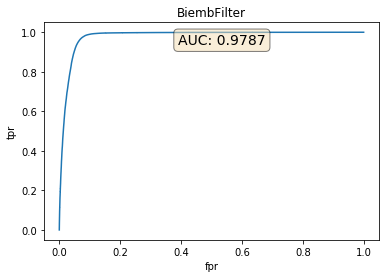

In [132]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.95, "AUC: {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("BiembFilter")

## Embedding+BiAGNN

In [111]:
importlib.reload(sys.modules['models'])
from models import *

In [47]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 8, "r": 2.7, "hidden_dim": 64, "n_graph_iters": 6}
other_configs = {"r_train": 1, "r_val": 2.7, "margin": 1, 'reduction':'mean', 'weight': 2}
torch.manual_seed(torch_seed)
model = BiEmbeddingToBiAGNN(**m_configs).to(device)
multi_loss = MultiNoiseLoss(n_losses=2).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="EmbeddingToAGNN", config=m_configs)
wandb.watch(model, log='all')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [48]:
optimizer = torch.optim.AdamW([
    {'params': model.emb_network.parameters()},
    {'params': chain(model.node_network.parameters(), model.edge_network.parameters(), model.input_network.parameters())},
    {'params': multi_loss.noise_params}],
lr = 0.001, weight_decay=1e-3, amsgrad=True)

In [49]:
lambda1 = lambda ep: 1 / (3**(ep//20))
lambda2 = lambda ep: 1 / (3**(ep//30))
lambda3 = lambda ep: 1 / (3**(ep//20))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2, lambda3])

In [50]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_embgnn(model, train_loader, optimizer, multi_loss, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, val_loss_1, val_loss_2 = evaluate_embgnn(model, test_loader, multi_loss, m_configs)
    scheduler.step()
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_acc": edge_acc, "edge_pur": edge_pur, "edge_eff": edge_eff, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0]})
    
    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'EmbeddingToAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Edge Purity: {:.4f}, Edge Efficiency: {:.4f}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Total Loss: {:.4f} (Loss 1: {:.2f}, Loss 2: {:.2f}), LR: {} in time {}'.format(epoch, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, val_loss_1, val_loss_2, scheduler._last_lr[0], tt()-tic))

TypeError: train_embgnn() missing 1 required positional argument: 'epoch'

### F1 Results

In [136]:
%%time

model.eval()

r_min, r_max, r_step = 0.1, 2.7, 0.05
t_min, t_max, t_step = 0.1, 1., 0.05

pur, eff, f1 = evaluate_biembagnn_f1(test_loader, model, r_min, r_max, r_step, t_min, t_max, t_step)
f1[np.isnan(f1)] = 0
eff[np.isnan(eff)] = 0
pur[np.isnan(pur)] = 0

CPU times: user 2.01 s, sys: 121 ms, total: 2.13 s
Wall time: 1.99 s


In [137]:
r_ind = np.where(f1==np.max(f1))[0][0]
t_ind = np.where(f1==np.max(f1))[1][0]
print("Best f1", np.max(f1), "@ r", r_min + r_ind*r_step, "t", t_min + t_ind*t_step)
r_best = r_min + r_ind*r_step
cluster_eff = np.max(eff)

Best f1 0.9858007737084824 @ r 2.6500000000000004 t 0.7000000000000001


### ROC AUC Results

In [138]:
model.eval()

total_pred = []
total_y = []

for batch in test_loader:
    data = batch.to(device)
    pred, spatial, e, _ = model(data) 
    reference = spatial.index_select(0, e[1])
    neighbors = spatial.index_select(0, e[0])
    d = torch.sqrt(torch.sum((reference - neighbors)**2, dim=-1))
    
    r_pred = pred[d<r_best]
    r_e = e[:,d<r_best]
    
    y = batch.pid[r_e[0]] == batch.pid[r_e[1]]

    total_pred += r_pred.detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

In [139]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

Text(0.5, 1.0, 'BiembFilter')

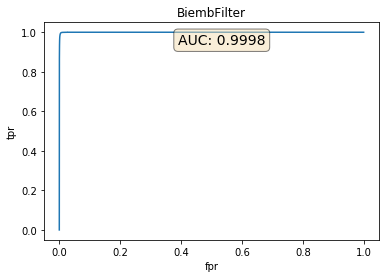

In [140]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.95, "AUC: {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("BiembFilter")

Text(0.5, 1.0, 'BiembFilter')

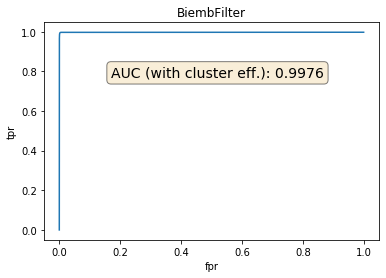

In [182]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr*cluster_eff)
ax.text(0.2, 0.8, "AUC (with cluster eff.): {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)*cluster_eff), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("BiembFilter")

## Embedding+AGNN

In [4]:
importlib.reload(sys.modules['models'])
from models import *

In [5]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 64, "hidden_dim": 32, "n_graph_iters": 6}
other_configs = {"r": 1.8, "r_train": 1, "r_val": 1.8, "margin": 1, 'reduction':'mean', 'weight': 2}
torch.manual_seed(torch_seed)
model = BiEmbeddingToAGNN(**m_configs).to(device)
multi_loss = MultiNoiseLoss(n_losses=2).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="EmbeddingToAGNN", config=m_configs)
wandb.watch(model, log='all')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
optimizer = torch.optim.AdamW([
    {'params': model.emb_network.parameters()},
    {'params': chain(model.node_network.parameters(), model.edge_network.parameters(), model.input_network.parameters())},
    {'params': multi_loss.noise_params}],
lr = 0.001, weight_decay=1e-3, amsgrad=True)

In [7]:
lambda1 = lambda ep: 1 / (3**(ep//20))
lambda2 = lambda ep: 1 / (3**(ep//30))
lambda3 = lambda ep: 1 / (3**(ep//20))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2, lambda3])

In [8]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_embgnn(model, train_loader, optimizer, multi_loss, m_configs, epoch)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, val_loss_1, val_loss_2 = evaluate_embgnn(model, test_loader, multi_loss, m_configs)
    scheduler.step()
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_acc": edge_acc, "edge_pur": edge_pur, "edge_eff": edge_eff, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0]})
    
    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'EmbeddingToAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Edge Purity: {:.4f}, Edge Efficiency: {:.4f}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Total Loss: {:.4f} (Loss 1: {:.2f}, Loss 2: {:.2f}), LR: {} in time {}'.format(epoch, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, val_loss_1, val_loss_2, scheduler._last_lr[0], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 1840.63687312603
Epoch: 0, Edge Purity: 0.8024, Edge Efficiency: 0.8897, Cluster Purity: 0.1865, Cluster Efficiency: 0.9896, Total Loss: 14.1344 (Loss 1: 21.27, Loss 2: 11.54), LR: 0.001 in time 188.81960678100586
Training loss: 557.6011356711388
Epoch: 1, Edge Purity: 0.8480, Edge Efficiency: 0.9528, Cluster Purity: 0.1829, Cluster Efficiency: 0.9893, Total Loss: -3.1198 (Loss 1: 12.12, Loss 2: 11.17), LR: 0.001 in time 173.34234642982483
Training loss: 327.4923718571663
Epoch: 2, Edge Purity: 0.9067, Edge Efficiency: 0.9630, Cluster Purity: 0.1857, Cluster Efficiency: 0.9867, Total Loss: -23.0388 (Loss 1: 8.43, Loss 2: 11.28), LR: 0.001 in time 172.95299768447876
Training loss: 107.56464675068855
Epoch: 3, Edge Purity: 0.9255, Edge Efficiency: 0.9620, Cluster Purity: 0.1893, Cluster Efficiency: 0.9865, Total Loss: -30.3866 (Loss 1: 7.87, Loss 2: 11.52), LR: 0.001 in time 192.61968111991882
Training loss: -16.361368864774704
Epoch: 4, Edge Purity: 0.9371, Edge Efficienc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-8f01459e9f60>", line 4, in <module>
    train_loss = train_embgnn(model, train_loader, optimizer, multi_loss, m_configs, epoch)
  File "<ipython-input-4-9550275ea955>", line 44, in train_embgnn
    loss.backward()
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/tensor.py", line 198, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/autograd/__init__.py", line 100, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IP

KeyboardInterrupt: 

### F1 Results

In [9]:
@torch.no_grad()
def evaluate_embagnn_f1(test_loader, model, r_min, r_max, r_step, t_min, t_max, t_step):
    model.eval()

    total_true_positive, total_positive, total_true = np.zeros((int(np.ceil((r_max - r_min)/r_step)), int(np.ceil((t_max - t_min)/t_step)))), np.zeros((int(np.ceil((r_max - r_min)/r_step)), int(np.ceil((t_max - t_min)/t_step)))), np.zeros((int(np.ceil((r_max - r_min)/r_step)), int(np.ceil((t_max - t_min)/t_step))))

    for batch in test_loader:

        data = batch.to(device)
    
        for i, r in enumerate(np.arange(r_min, r_max, r_step)):  
            
            pred, spatial, e, _ = model(data, r) 
#             reference = spatial.index_select(0, e[1])
#             neighbors = spatial.index_select(0, e[0])
#             d = torch.sqrt(torch.sum((reference - neighbors)**2, dim=-1))

            y = batch.pid[e[0]] == batch.pid[e[1]]

            true = len(batch.true_edges)
            edge_true, edge_false = y.float() > 0.5, y.float() < 0.5
            for j, t in enumerate(np.arange(t_min, t_max, t_step)):  
                edge_positive, edge_negative = sig(pred) > t, sig(pred) < t
                total_true_positive[i][j] += (edge_true & edge_positive).sum().item()
                total_true[i][j] += true
                total_positive[i][j] += edge_positive.sum().item()

    pur, eff = total_true_positive / total_positive, total_true_positive / total_true
    f1 = 2*pur*eff/(pur+eff) 
    return pur, eff, f1


In [34]:
%%time

model.eval()

r_min, r_max, r_step = 2.6, 2.7, 0.1
t_min, t_max, t_step = 0.0, 1., 0.1

pur, eff, f1 = evaluate_embagnn_f1(test_loader, model, r_min, r_max, r_step, t_min, t_max, t_step)
f1[np.isnan(f1)] = 0
eff[np.isnan(eff)] = 0
pur[np.isnan(pur)] = 0

CPU times: user 19.8 s, sys: 3.97 s, total: 23.8 s
Wall time: 19.5 s


In [28]:
eff

array([[0.99554264, 0.9930565 , 0.99115661, 0.98913489, 0.98682213,
        0.98389967, 0.98017696, 0.97502244, 0.96646854, 0.94755926],
       [0.99561345, 0.99308982, 0.99117796, 0.98915468, 0.98682005,
        0.98390644, 0.98016342, 0.97498756, 0.96641231, 0.94749522],
       [0.99565302, 0.99311377, 0.99119202, 0.98915989, 0.98681328,
        0.98388353, 0.98013583, 0.97495267, 0.9663566 , 0.94740827]])

In [35]:
r_ind = np.where(f1==np.max(f1))[0][0]
t_ind = np.where(f1==np.max(f1))[1][0]

r_best = r_min + r_ind*r_step
cluster_eff = max(eff[r_ind])

print("Best f1 is", np.max(f1), "@ r", r_min + r_ind*r_step, "t", t_min + t_ind*t_step, "with cluster eff:", cluster_eff)

Best f1 is 0.980959164935808 @ r 2.6 t 0.6000000000000001 with cluster eff: 0.995613450488482


In [21]:
r_best=2.6

### ROC AUC Results

In [36]:
model.eval()

total_pred = []
total_y = []
with torch.no_grad():
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e, _ = model(data, r_best) 

        y = batch.pid[e[0]] == batch.pid[e[1]]

        total_pred += pred.detach().cpu().numpy().tolist()
        total_y += y.cpu().numpy().tolist()

In [37]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

Text(0.5, 1.0, 'BiembFilter')

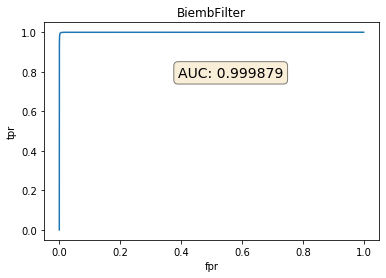

In [38]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.8, "AUC: {:.6f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("BiembFilter")

Text(0.5, 1.0, 'BiembFilter')

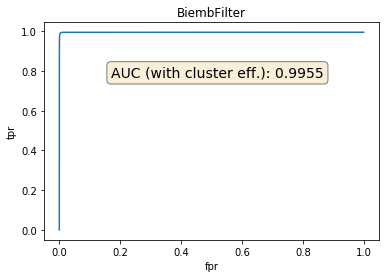

In [39]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr*cluster_eff)
ax.text(0.2, 0.8, "AUC (with cluster eff.): {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)*cluster_eff), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("BiembFilter")

## AdjacentEmbedding+AGNN

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Embedding(torch.nn.Module):
    def __init__(self, in_channels, nb_hidden, nb_layer, emb_dim=3):
        super(Embedding, self).__init__()
        layers = [Linear(in_channels, nb_hidden)]
        ln = [Linear(nb_hidden, nb_hidden) for _ in range(nb_layer-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(nb_hidden, emb_dim)
        self.norm = torch.nn.LayerNorm(nb_hidden)
        self.act = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.7)
#         self.mean = torch.FloatTensor(mean).to(torch.float)
#         self.std = torch.FloatTensor(std).to(torch.float)

    def forward(self, x):
#         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
            # hits = self.dropout(hits)
        x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

    def normalize(self, hits):
        try:
            hits = (hits-self.mean) / (self.std + 10**-9)
        except:
            self.mean = self.mean.to(device=hits.device)
            self.std  = self.std.to(device=hits.device)
            hits = (hits-self.mean) / (self.std + 10**-9)
        return hits

In [58]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)

class EmbeddingToAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbeddingToAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        # Setup the input network
        self.input_network = make_mlp(emb_dim, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim + emb_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim + emb_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(in_channels, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.emb_network(x)
#         spatial = self.spatial_norm(spatial)
        
        edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
#         print(edge_index.shape)
        x = self.input_network(spatial)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, spatial, inputs.x], dim=-1)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, edge_index))
        
            # Apply node network
            x = self.node_network(x, e, edge_index)
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, spatial, inputs.x], dim=-1)
             
            x = x_inital + x
        
        return self.edge_network(x, edge_index), spatial, edge_index

In [59]:
class MultiNoiseLoss(nn.Module):
    def __init__(self, n_losses):
        super(MultiNoiseLoss, self).__init__()
        self.noise_params = torch.rand(n_losses, requires_grad=True, device="cuda:0")
    
    def forward(self, losses):
        
        total_loss = 0
        for i, loss in enumerate(losses):
            total_loss += (1/torch.square(self.noise_params[i]))*loss + torch.log(self.noise_params[i])
        
        return total_loss

In [39]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
                
        e_spatial = radius_graph(spatial, r=m_configs["r_train"], batch=batch.batch, loop=False, max_num_neighbors=1000)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_1 + loss_2
        total_loss += loss
        
        loss.backward()
        optimizer.step()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=1000)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())

        loss = loss_1 + loss_2
        total_loss += loss
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [65]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer, loss_fn):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        # Get fake edge list
        candidates = radius_graph(spatial, r=m_configs['r_train'], batch=batch.batch, loop=False, max_num_neighbors=200)
        fake_list = candidates[:,batch.pid[candidates[0]] != batch.pid[candidates[1]]]
        
#         print(batch.pid[fake_list[0]] == batch.pid[fake_list[1]])
        
        # Concatenate all candidates
        e_spatial = torch.cat([fake_list, batch.true_edges.T.to(device)], axis=-1)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_fn([loss_1.to(device), loss_2.to(device)])
#         print("Loss:", loss, "Noise params:", loss_fn.noise_params)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
                
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader, loss_fn):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=200)
#         e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())

        loss = loss_fn([loss_1, loss_2]).item()
        print("Combined loss:", loss, "Noise params:", loss_fn.noise_params)
        total_loss += loss
        
        #Cluster performance
        cluster_true = len(batch.true_edges)

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [72]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 4, "emb_dim": 11, "r": 1, "hidden_dim": 16, "n_graph_iters": 6}
other_configs = {"k": 20, "r_train": 0.8, "r_val": 1, "margin": 0.8, 'reduction':'mean'}
model = EmbeddingToAGNN(**m_configs).to(device)
multi_loss = MultiNoiseLoss(n_losses=2).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="EmbeddingToAGNNMedium", config=m_configs)
wandb.watch(model, log='all')

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


In [73]:
optimizer = torch.optim.AdamW([
    {'params': model.emb_network.parameters()},
    {'params': chain(model.node_network.parameters(), model.edge_network.parameters(), model.input_network.parameters())},
    {'params': multi_loss.noise_params}],
lr = 0.001, weight_decay=1e-3, amsgrad=True)

In [74]:
lambda1 = lambda ep: 1 / (1.5**(ep//10))
lambda2 = lambda ep: 1 / (1.5**(ep//30))
lambda3 = lambda ep: 1 / (1.1**(ep//10))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2, lambda3])

In [75]:
weight = 2
for epoch in range(100):
    tic = tt()  
    model.train()
    edge_acc, cluster_pur, train_loss = train(model, train_loader, optimizer, multi_loss)
    print("Training loss:", train_loss) 

    model.eval()
    edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss = evaluate(model, test_loader, multi_loss)
    scheduler.step()
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_acc": edge_acc, "edge_pur": edge_pur, "edge_eff": edge_eff, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0], "noise_1": multi_loss.noise_params[0].item(), "noise_2": multi_loss.noise_params[1].item()})
    
    save_model(epoch, model, optimizer, scheduler, cluster_eff, m_configs, 'EmbeddingToAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Edge Accuracy: {:.4f}, Edge Purity: {:.4f}, Edge Efficiency: {:.4f}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, scheduler._last_lr, tt()-tic))

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training loss: 1487.4907236099243
Loss 1: 0.31528162956237793 Loss 2: 0.2533404529094696
Combined loss: 9.057168006896973 Noise params: tensor([0.1723, 0.8820], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 2959 Positive 0
CLUSTER: True positive: 2959.0 True: 4868 Positive: 67022
Loss 1: 0.3621431589126587 Loss 2: 0.2648620903491974
Combined loss: 10.649784088134766 Noise params: tensor([0.1723, 0.8820], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 2528 Positive 0
CLUSTER: True positive: 2528.0 True: 4072 Positive: 44916
Loss 1: 0.34808582067489624 Loss 2: 0.2603476643562317
Combined loss: 10.170676231384277 Noise params: tensor([0.1723, 0.8820], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 2754 Positive 0
CLUSTER: True positive: 2754.0 True: 4456 Positive: 52260
Loss 1: 0.38041335344314575 Loss 2: 0.2602645754814148
Combined loss: 11.259021759033203 Noise params: tensor([0.1723, 0.8820], device='cuda:0', requires_grad=Tr

/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Training loss: 744.8125748634338
Loss 1: 0.35014981031417847 Loss 2: 0.25664329528808594
Combined loss: 6.549073696136475 Noise params: tensor([0.2109, 0.9486], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 3418 Positive 0
CLUSTER: True positive: 3418.0 True: 4456 Positive: 60412
Loss 1: 0.30333611369132996 Loss 2: 0.24917437136173248
Combined loss: 5.488175868988037 Noise params: tensor([0.2109, 0.9486], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 4696 Positive 0
CLUSTER: True positive: 4696.0 True: 6234 Positive: 105530
Loss 1: 0.3596440851688385 Loss 2: 0.26693910360336304
Combined loss: 6.773993015289307 Noise params: tensor([0.2109, 0.9486], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 3075 Positive 0
CLUSTER: True positive: 3075.0 True: 4072 Positive: 51620
Loss 1: 0.3244364857673645 Loss 2: 0.2536465525627136
Combined loss: 5.967583656311035 Noise params: tensor([0.2109, 0.9486], device='cuda:0', requires_grad=Tru

Loss 1: 0.3973577916622162 Loss 2: 0.27528223395347595
Combined loss: 4.5509843826293945 Noise params: tensor([0.2669, 1.0380], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 2733 Positive 0
CLUSTER: True positive: 2733.0 True: 4872 Positive: 42478
EDGE Accuracy: 0.9347, Purity: 0.5000, Efficiency: 0.0000
CLUSTER Purity: 0.0653, Efficiency: 0.5714
Epoch: 3, Edge Accuracy: 0.9347, Edge Purity: 0.5000, Edge Efficiency: 0.0000, Cluster Purity: 0.0653, Cluster Efficiency: 0.5714, Loss: 47.2340, LR: [0.001, 0.001, 0.001] in time 15.9392831325531
Training loss: 526.9883428812027
Loss 1: 0.32703834772109985 Loss 2: 0.2658192217350006
Combined loss: 2.8480167388916016 Noise params: tensor([0.2942, 1.0557], device='cuda:0', requires_grad=True)
EDGES: True positive: 24 True: 2745 Positive 70
CLUSTER: True positive: 2745.0 True: 4627 Positive: 45306
Loss 1: 0.3603392243385315 Loss 2: 0.26768800616264343
Combined loss: 3.2344777584075928 Noise params: tensor([0.2942, 1.0557], d

Loss 1: 0.26598286628723145 Loss 2: 0.28426823019981384
Combined loss: 1.793554425239563 Noise params: tensor([0.3184, 1.0676], device='cuda:0', requires_grad=True)
EDGES: True positive: 3368 True: 4311 Positive 5406
CLUSTER: True positive: 4311.0 True: 4872 Positive: 32910
Loss 1: 0.25169700384140015 Loss 2: 0.276890367269516
Combined loss: 1.646198034286499 Noise params: tensor([0.3184, 1.0676], device='cuda:0', requires_grad=True)
EDGES: True positive: 3450 True: 4190 Positive 5432
CLUSTER: True positive: 4190.0 True: 4868 Positive: 31620
EDGE Accuracy: 0.9148, Purity: 0.6478, Efficiency: 0.8195
CLUSTER Purity: 0.1362, Efficiency: 0.8805
Epoch: 6, Edge Accuracy: 0.9148, Edge Purity: 0.6478, Edge Efficiency: 0.8195, Cluster Purity: 0.1362, Cluster Efficiency: 0.8805, Loss: 16.8845, LR: [0.001, 0.001, 0.001] in time 15.596781492233276
Training loss: 187.71376717090607
Loss 1: 0.2538159489631653 Loss 2: 0.2904651463031769
Combined loss: 1.5467276573181152 Noise params: tensor([0.3291, 

Loss 1: 0.2358919084072113 Loss 2: 0.30048513412475586
Combined loss: 1.2028981447219849 Noise params: tensor([0.3480, 1.0252], device='cuda:0', requires_grad=True)
EDGES: True positive: 3894 True: 4537 Positive 5264
CLUSTER: True positive: 4537.0 True: 4872 Positive: 24662
Loss 1: 0.22407124936580658 Loss 2: 0.30857574939727783
Combined loss: 1.1130008697509766 Noise params: tensor([0.3480, 1.0252], device='cuda:0', requires_grad=True)
EDGES: True positive: 3180 True: 3402 Positive 4096
CLUSTER: True positive: 3402.0 True: 3672 Positive: 14200
Loss 1: 0.2173885703086853 Loss 2: 0.2973753809928894
Combined loss: 1.0471713542938232 Noise params: tensor([0.3480, 1.0252], device='cuda:0', requires_grad=True)
EDGES: True positive: 4100 True: 4524 Positive 5432
CLUSTER: True positive: 4524.0 True: 4868 Positive: 22922
Loss 1: 0.2288587987422943 Loss 2: 0.3043893575668335
Combined loss: 1.148545265197754 Noise params: tensor([0.3480, 1.0252], device='cuda:0', requires_grad=True)
EDGES: True 

Loss 1: 0.14320127665996552 Loss 2: 0.29728248715400696
Combined loss: 0.37425193190574646 Noise params: tensor([0.3631, 1.0092], device='cuda:0', requires_grad=True)
EDGES: True positive: 3780 True: 4013 Positive 4272
CLUSTER: True positive: 4013.0 True: 4292 Positive: 20082
Loss 1: 0.14352864027023315 Loss 2: 0.3019009530544281
Combined loss: 0.3812702000141144 Noise params: tensor([0.3631, 1.0092], device='cuda:0', requires_grad=True)
EDGES: True positive: 3242 True: 3373 Positive 3638
CLUSTER: True positive: 3373.0 True: 3672 Positive: 14758
Loss 1: 0.15649521350860596 Loss 2: 0.2915094196796417
Combined loss: 0.46943822503089905 Noise params: tensor([0.3631, 1.0092], device='cuda:0', requires_grad=True)
EDGES: True positive: 4095 True: 4503 Positive 4721
CLUSTER: True positive: 4503.0 True: 4872 Positive: 25882
Loss 1: 0.1565992385149002 Loss 2: 0.29129886627197266
Combined loss: 0.47002077102661133 Noise params: tensor([0.3631, 1.0092], device='cuda:0', requires_grad=True)
EDGES:

Training loss: 15.58995196223259
Loss 1: 0.087284155189991 Loss 2: 0.27644670009613037
Combined loss: -0.0807698667049408 Noise params: tensor([0.3692, 0.9974], device='cuda:0', requires_grad=True)
EDGES: True positive: 4835 True: 5021 Positive 5268
CLUSTER: True positive: 5021.0 True: 5135 Positive: 29890
Loss 1: 0.08486699312925339 Loss 2: 0.2815726697444916
Combined loss: -0.09335434436798096 Noise params: tensor([0.3692, 0.9974], device='cuda:0', requires_grad=True)
EDGES: True positive: 4228 True: 4333 Positive 4598
CLUSTER: True positive: 4333.0 True: 4456 Positive: 22692
Loss 1: 0.07756287604570389 Loss 2: 0.27465081214904785
Combined loss: -0.1539120376110077 Noise params: tensor([0.3692, 0.9974], device='cuda:0', requires_grad=True)
EDGES: True positive: 4103 True: 4186 Positive 4411
CLUSTER: True positive: 4186.0 True: 4292 Positive: 22136
Loss 1: 0.0816681981086731 Loss 2: 0.279934287071228
Combined loss: -0.11847487092018127 Noise params: tensor([0.3692, 0.9974], device='cu

Loss 1: 0.08954441547393799 Loss 2: 0.28253158926963806
Combined loss: -0.06325748562812805 Noise params: tensor([0.3705, 0.9880], device='cuda:0', requires_grad=True)
EDGES: True positive: 5657 True: 5956 Positive 6253
CLUSTER: True positive: 5956.0 True: 6234 Positive: 38252
Loss 1: 0.08283384889364243 Loss 2: 0.2862468659877777
Combined loss: -0.10832607746124268 Noise params: tensor([0.3705, 0.9880], device='cuda:0', requires_grad=True)
EDGES: True positive: 4815 True: 5011 Positive 5193
CLUSTER: True positive: 5011.0 True: 5135 Positive: 28858
EDGE Accuracy: 0.9804, Purity: 0.9289, Efficiency: 0.9663
CLUSTER Purity: 0.1824, Efficiency: 0.9628
Epoch: 17, Edge Accuracy: 0.9804, Edge Purity: 0.9289, Edge Efficiency: 0.9663, Cluster Purity: 0.1824, Cluster Efficiency: 0.9628, Loss: -1.3438, LR: [0.0006666666666666666, 0.001, 0.0009090909090909091] in time 14.470959424972534
Training loss: 2.0600718557834625
Loss 1: 0.055845871567726135 Loss 2: 0.27203699946403503
Combined loss: -0.321

Loss 1: 0.05690997466444969 Loss 2: 0.2645946443080902
Combined loss: -0.3248726427555084 Noise params: tensor([0.3705, 0.9759], device='cuda:0', requires_grad=True)
EDGES: True positive: 4525 True: 4643 Positive 4809
CLUSTER: True positive: 4643.0 True: 4868 Positive: 27186
Loss 1: 0.05717772617936134 Loss 2: 0.2712564170360565
Combined loss: -0.31592780351638794 Noise params: tensor([0.3705, 0.9759], device='cuda:0', requires_grad=True)
EDGES: True positive: 4342 True: 4431 Positive 4577
CLUSTER: True positive: 4431.0 True: 4627 Positive: 24222
Loss 1: 0.04847994074225426 Loss 2: 0.27022528648376465
Combined loss: -0.38037559390068054 Noise params: tensor([0.3705, 0.9759], device='cuda:0', requires_grad=True)
EDGES: True positive: 4310 True: 4386 Positive 4490
CLUSTER: True positive: 4386.0 True: 4489 Positive: 24082
Loss 1: 0.04971889406442642 Loss 2: 0.26590049266815186
Combined loss: -0.37589016556739807 Noise params: tensor([0.3705, 0.9759], device='cuda:0', requires_grad=True)
E

Loss 1: 0.03608027845621109 Loss 2: 0.2612561583518982
Combined loss: -0.48263540863990784 Noise params: tensor([0.3695, 0.9732], device='cuda:0', requires_grad=True)
EDGES: True positive: 3523 True: 3560 Positive 3605
CLUSTER: True positive: 3560.0 True: 3672 Positive: 17718
Loss 1: 0.04082344099879265 Loss 2: 0.25901755690574646
Combined loss: -0.4502645432949066 Noise params: tensor([0.3695, 0.9732], device='cuda:0', requires_grad=True)
EDGES: True positive: 4361 True: 4442 Positive 4534
CLUSTER: True positive: 4442.0 True: 4627 Positive: 25598
Loss 1: 0.03638754040002823 Loss 2: 0.2522861659526825
Combined loss: -0.4898568093776703 Noise params: tensor([0.3695, 0.9732], device='cuda:0', requires_grad=True)
EDGES: True positive: 4598 True: 4663 Positive 4786
CLUSTER: True positive: 4663.0 True: 4872 Positive: 29198
Loss 1: 0.037213098257780075 Loss 2: 0.2510358989238739
Combined loss: -0.48513129353523254 Noise params: tensor([0.3695, 0.9732], device='cuda:0', requires_grad=True)
ED

Loss 1: 0.04198148474097252 Loss 2: 0.26094579696655273
Combined loss: -0.4463636875152588 Noise params: tensor([0.3676, 0.9630], device='cuda:0', requires_grad=True)
EDGES: True positive: 3839 True: 3924 Positive 4004
CLUSTER: True positive: 3924.0 True: 4072 Positive: 23820
EDGE Accuracy: 0.9912, Purity: 0.9639, Efficiency: 0.9844
CLUSTER Purity: 0.1672, Efficiency: 0.9589
Epoch: 25, Edge Accuracy: 0.9912, Edge Purity: 0.9639, Edge Efficiency: 0.9844, Cluster Purity: 0.1672, Cluster Efficiency: 0.9589, Loss: -4.8373, LR: [0.0004444444444444444, 0.001, 0.0008264462809917355] in time 14.65344762802124
Training loss: -27.85906234383583
Loss 1: 0.03676067665219307 Loss 2: 0.2561100125312805
Combined loss: -0.49326851963996887 Noise params: tensor([0.3664, 0.9596], device='cuda:0', requires_grad=True)
EDGES: True positive: 4895 True: 4998 Positive 5074
CLUSTER: True positive: 4998.0 True: 5135 Positive: 31362
Loss 1: 0.03731214255094528 Loss 2: 0.2585645616054535
Combined loss: -0.4864959

Loss 1: 0.034813638776540756 Loss 2: 0.2536115348339081
Combined loss: -0.5108197927474976 Noise params: tensor([0.3651, 0.9625], device='cuda:0', requires_grad=True)
EDGES: True positive: 4880 True: 4974 Positive 5060
CLUSTER: True positive: 4974.0 True: 5135 Positive: 31894
Loss 1: 0.03648143634200096 Loss 2: 0.2595052719116211
Combined loss: -0.4919491112232208 Noise params: tensor([0.3651, 0.9625], device='cuda:0', requires_grad=True)
EDGES: True positive: 3850 True: 3925 Positive 4005
CLUSTER: True positive: 3925.0 True: 4072 Positive: 24550
Loss 1: 0.03205454722046852 Loss 2: 0.2536873519420624
Combined loss: -0.5314310789108276 Noise params: tensor([0.3651, 0.9625], device='cuda:0', requires_grad=True)
EDGES: True positive: 4197 True: 4252 Positive 4321
CLUSTER: True positive: 4252.0 True: 4456 Positive: 24674
Loss 1: 0.035305801779031754 Loss 2: 0.2465248554944992
Combined loss: -0.5147784352302551 Noise params: tensor([0.3651, 0.9625], device='cuda:0', requires_grad=True)
EDGE

Loss 1: 0.030295973643660545 Loss 2: 0.2516438663005829
Combined loss: -0.5573500394821167 Noise params: tensor([0.3613, 0.9524], device='cuda:0', requires_grad=True)
EDGES: True positive: 5901 True: 5989 Positive 6083
CLUSTER: True positive: 5989.0 True: 6234 Positive: 42358
Loss 1: 0.02652840130031109 Loss 2: 0.25096628069877625
Combined loss: -0.5869662761688232 Noise params: tensor([0.3613, 0.9524], device='cuda:0', requires_grad=True)
EDGES: True positive: 4329 True: 4391 Positive 4414
CLUSTER: True positive: 4391.0 True: 4489 Positive: 25990
Loss 1: 0.0279082078486681 Loss 2: 0.25144046545028687
Combined loss: -0.57587069272995 Noise params: tensor([0.3613, 0.9524], device='cuda:0', requires_grad=True)
EDGES: True positive: 3510 True: 3552 Positive 3585
CLUSTER: True positive: 3552.0 True: 3672 Positive: 18712
Loss 1: 0.028577232733368874 Loss 2: 0.2550247609615326
Combined loss: -0.5667930841445923 Noise params: tensor([0.3613, 0.9524], device='cuda:0', requires_grad=True)
EDGES

KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x2aac2ff1a9e0> (for post_run_cell):


KeyboardInterrupt: 

### Results

In [14]:
model.eval()
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

pur, eff = [], []
r_min, r_max, r_step = 0.1, 1, 0.1


for r in np.arange(r_min, r_max, r_step):
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)

        e_spatial = radius_graph(spatial, r=r, batch=batch.batch, loop=False, max_num_neighbors=1000)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
        print("r", r, "e len", len(e_spatial[0]))

        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

    eff.append(cluster_total_true_positive / cluster_total_true)
    pur.append(cluster_total_true_positive / cluster_total_positive)
    
pur, eff = np.array(pur), np.array(eff)

r 0.1 e len 40642
r 0.1 e len 41948
r 0.1 e len 40780
r 0.1 e len 37382
r 0.1 e len 43624
r 0.1 e len 38442
r 0.1 e len 30972
r 0.1 e len 18204
r 0.1 e len 39448
r 0.1 e len 33024
r 0.2 e len 165878
r 0.2 e len 165290
r 0.2 e len 193562
r 0.2 e len 211956
r 0.2 e len 212452
r 0.2 e len 224848
r 0.2 e len 208902
r 0.2 e len 203168
r 0.2 e len 188948
r 0.2 e len 91736
r 0.30000000000000004 e len 521502
r 0.30000000000000004 e len 396890
r 0.30000000000000004 e len 226602
r 0.30000000000000004 e len 513222
r 0.30000000000000004 e len 413360
r 0.30000000000000004 e len 497994
r 0.30000000000000004 e len 514682
r 0.30000000000000004 e len 477138
r 0.30000000000000004 e len 551664
r 0.30000000000000004 e len 460548
r 0.4 e len 768486
r 0.4 e len 837312
r 0.4 e len 956844
r 0.4 e len 876332
r 0.4 e len 1009708
r 0.4 e len 924516
r 0.4 e len 417740
r 0.4 e len 946050
r 0.4 e len 717312
r 0.4 e len 936506
r 0.5 e len 1217050
r 0.5 e len 1579904
r 0.5 e len 1114560
r 0.5 e len 659440
r 0.5 e len

In [90]:
pur, eff = np.array(pur), np.array(eff)

In [15]:
pur, eff

(array([0.04886588, 0.02879242, 0.02019021, 0.01550792, 0.01199519,
        0.00972997, 0.00815024, 0.00703596, 0.00622132]),
 array([0.04706411, 0.14203266, 0.24401987, 0.34386132, 0.41815972,
        0.48530205, 0.54561598, 0.60048095, 0.62897046]))

Text(0.5, 0.95, 'AUC: 0.0057')

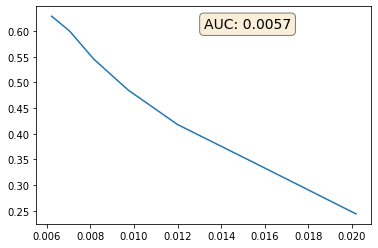

In [16]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(pur[2:], eff[2:])
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(pur[2:], eff[2:])), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

Loss 1: 0.3805650770664215 Loss 2: 0.43358755111694336
EDGES: True positive: 1468 True: 1512 Positive 2304
CLUSTER: True positive: 21226.0 True: 39724 Positive: 472754
Loss 1: 0.39187395572662354 Loss 2: 0.434693843126297
EDGES: True positive: 1587 True: 1674 Positive 2692
CLUSTER: True positive: 23606.0 True: 44110 Positive: 577612
Loss 1: 0.3983624577522278 Loss 2: 0.4373193681240082
EDGES: True positive: 1419 True: 1490 Positive 2394
CLUSTER: True positive: 21420.0 True: 39524 Positive: 456916
Loss 1: 0.3560328781604767 Loss 2: 0.43586331605911255
EDGES: True positive: 1238 True: 1292 Positive 1989
CLUSTER: True positive: 19562.0 True: 36528 Positive: 398870
Loss 1: 0.40297380089759827 Loss 2: 0.43316298723220825
EDGES: True positive: 1407 True: 1494 Positive 2419
CLUSTER: True positive: 21656.0 True: 40164 Positive: 498370
Loss 1: 0.3698059320449829 Loss 2: 0.4342704117298126
EDGES: True positive: 1196 True: 1226 Positive 1875
CLUSTER: True positive: 17962.0 True: 34090 Positive: 3

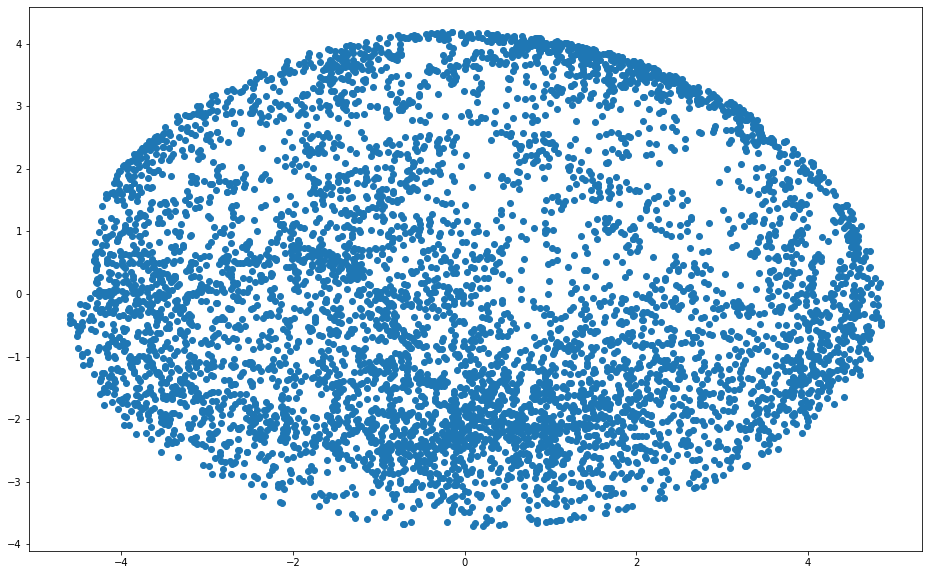

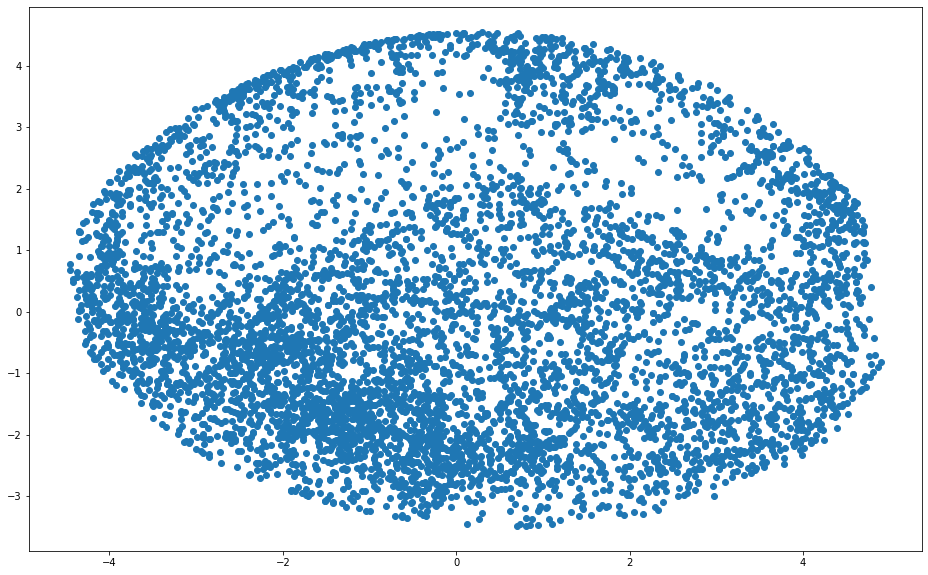

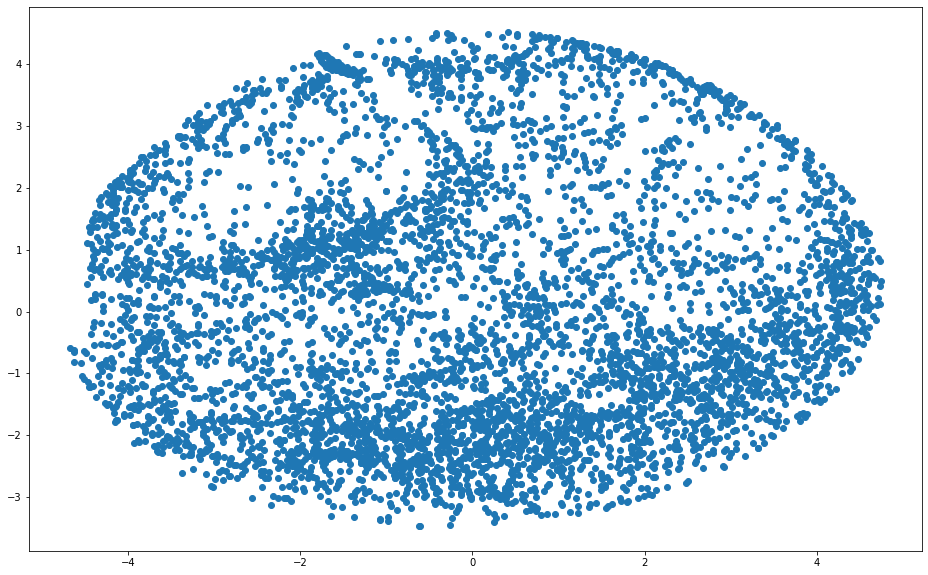

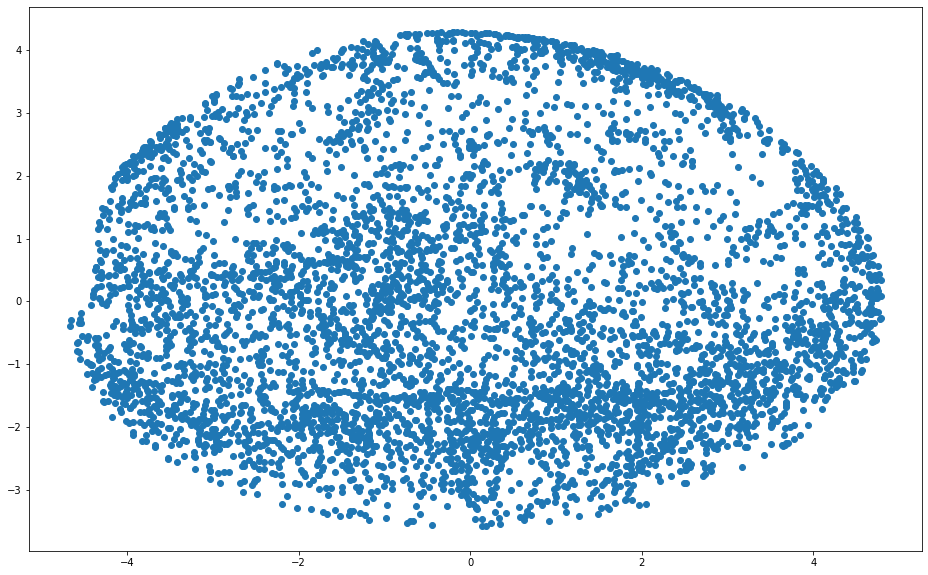

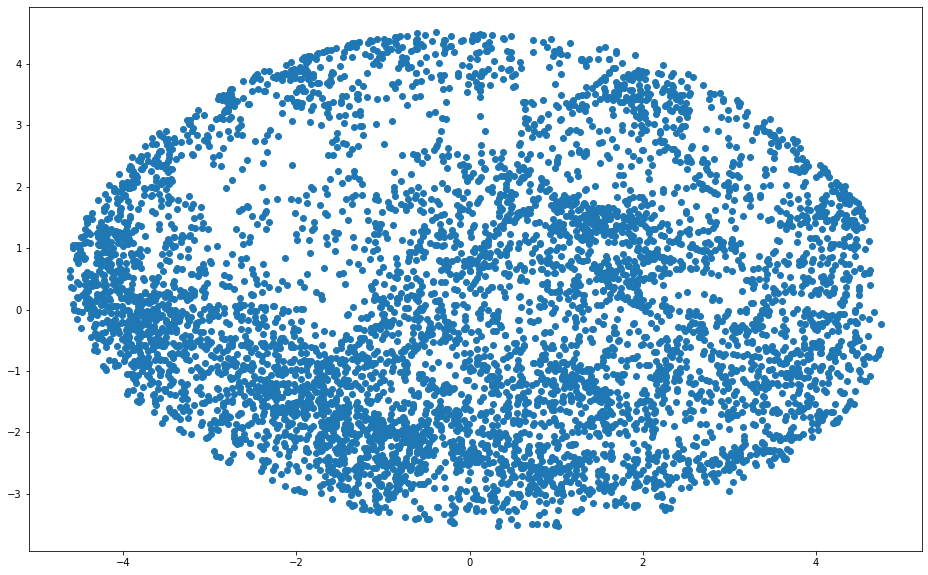

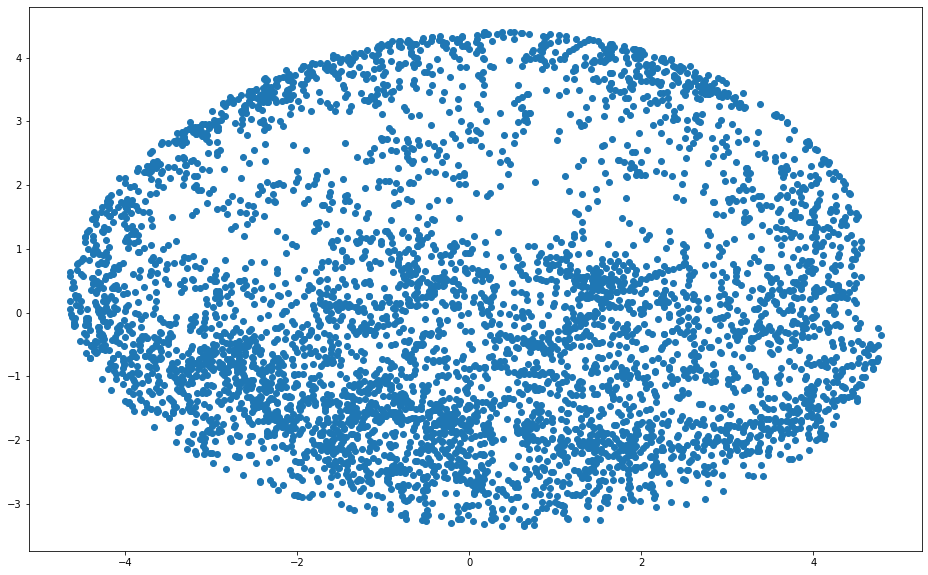

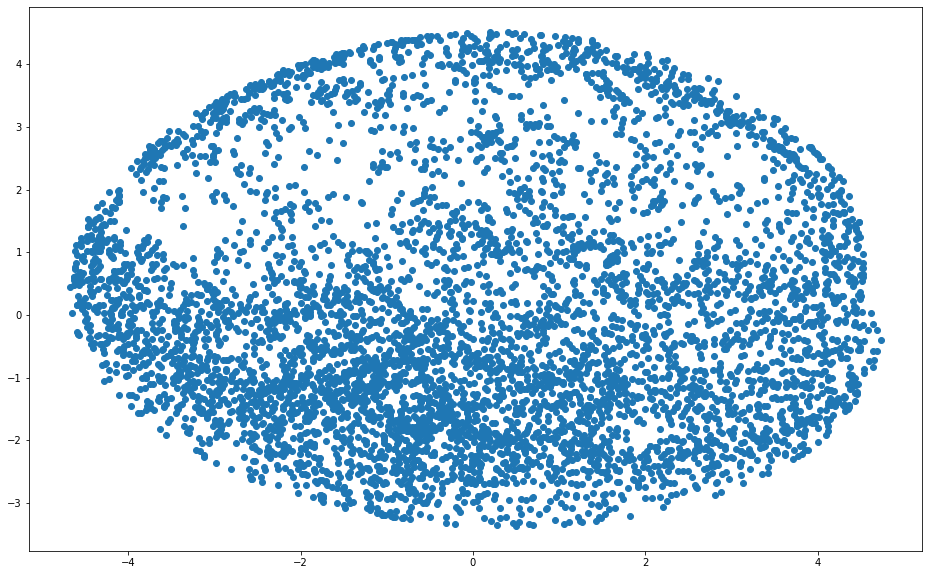

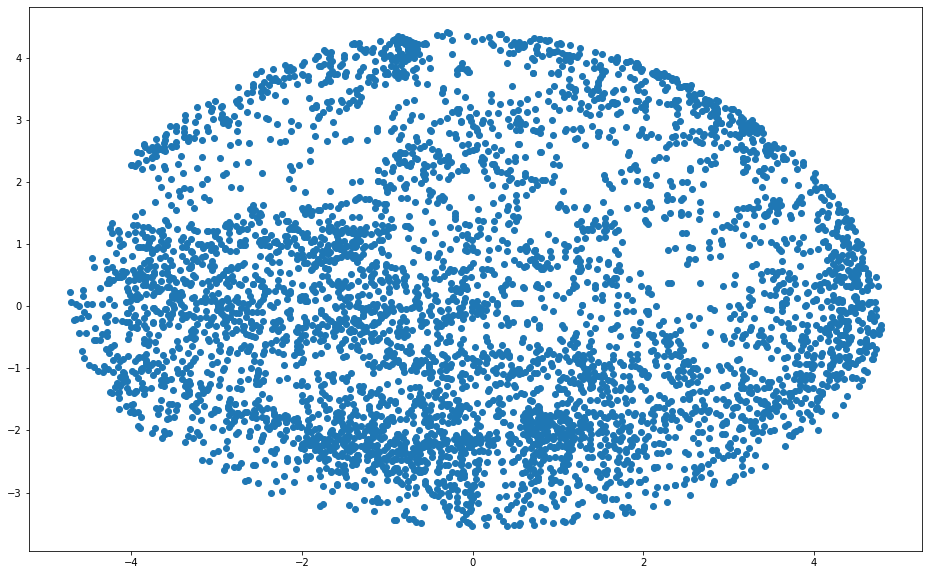

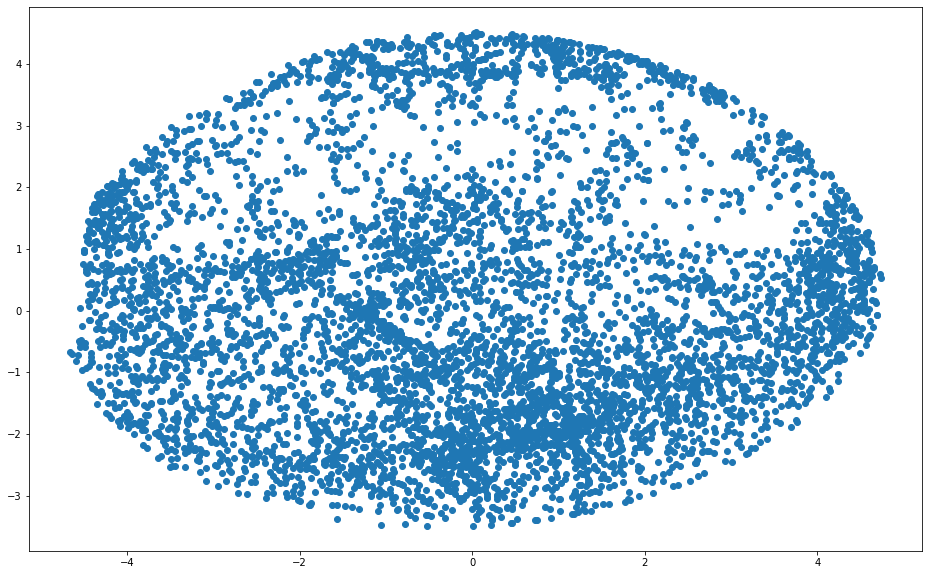

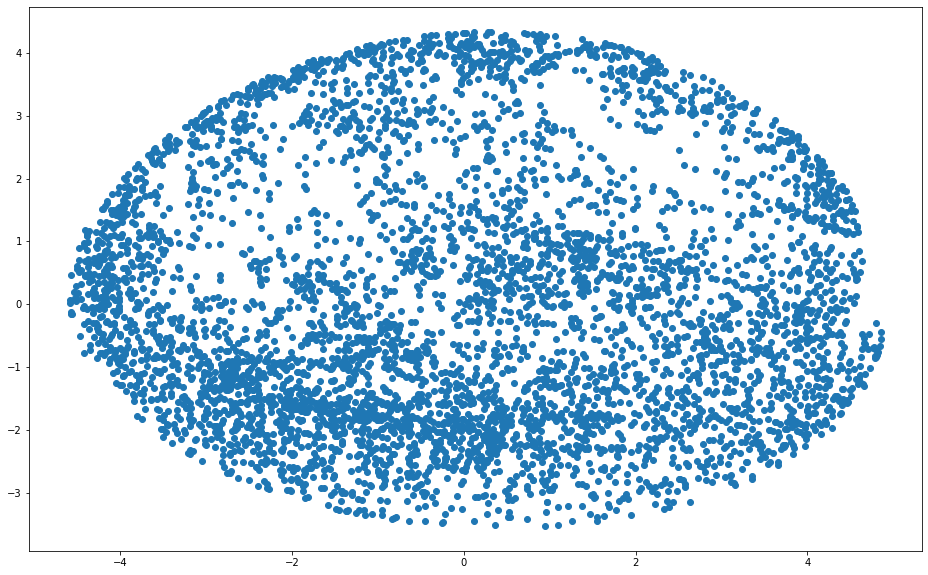

In [13]:
model.eval()
edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

for batch in test_loader:
    data = batch.to(device)
    pred, spatial, e = model(data)

    e_spatial = radius_graph(spatial, r=1, batch=batch.batch, loop=False, max_num_neighbors=1000)

    reference = spatial.index_select(0, e_spatial[1])
    neighbors = spatial.index_select(0, e_spatial[0])

    d = torch.sum((reference - neighbors)**2, dim=-1)

    y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
    y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
    
    
    hinge = y_cluster.float()
    hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  
    
    loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
    loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge)#, margin=m_configs["r"])
    print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
    
    embedded = spatial.cpu().detach().numpy()    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embedded)
    #         print("PCA", pca_result)
    plt.figure(figsize=(16,10))
    plt.scatter(pca_result[:,0], pca_result[:,1])

    #Cluster performance
    batch_cpu = batch.pid.cpu()
    pids, counts = np.unique(batch_cpu, return_counts=True)
    cluster_true = (counts * (counts - 1)).sum()

    cluster_true_positive = (y_cluster.float()).sum().item()
    cluster_total_true_positive += cluster_true_positive
    
    cluster_positive = len(e_spatial[0])
    cluster_total_positive += max(cluster_positive, 1)

    cluster_total_true += cluster_true
    
    #Edge performance
    edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
    edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

    edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

    edge_true_positive += (edge_true & edge_positive).sum().item()
    edge_total_true += edge_true.sum().item()
    edge_total_positive += edge_positive.sum().item()

    print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
    print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)
    
    total += len(pred)

edge_acc = edge_correct/total
edge_eff = (edge_true_positive / edge_total_true)
edge_pur = (edge_true_positive / edge_total_positive)

cluster_eff = (cluster_total_true_positive / cluster_total_true)
cluster_pur = (cluster_total_true_positive / cluster_total_positive)

print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))

## EmbAGNN

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Embedding(torch.nn.Module):
    def __init__(self, in_channels, nb_hidden, nb_layer, emb_dim=3):
        super(Embedding, self).__init__()
        layers = [Linear(in_channels, nb_hidden)]
        ln = [Linear(nb_hidden, nb_hidden) for _ in range(nb_layer-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(nb_hidden, emb_dim)
        self.norm = torch.nn.LayerNorm(nb_hidden)
        self.act = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.7)
#         self.mean = torch.FloatTensor(mean).to(torch.float)
#         self.std = torch.FloatTensor(std).to(torch.float)

    def forward(self, x):
#         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
            # hits = self.dropout(hits)
        x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

    def normalize(self, hits):
        try:
            hits = (hits-self.mean) / (self.std + 10**-9)
        except:
            self.mean = self.mean.to(device=hits.device)
            self.std  = self.std.to(device=hits.device)
            hits = (hits-self.mean) / (self.std + 10**-9)
        return hits

In [13]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)

class EmbAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_spatial_network = make_mlp(in_channels, [emb_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.input_feature_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
#         self.combine_network = make_mlp(emb_dim + hidden_dim, [hidden_dim],
#                                       output_activation=hidden_activation,
#                                       layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(emb_dim + hidden_dim, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.input_spatial_network(x)
        features = self.input_feature_network(x)
#         spatial = self.spatial_norm(spatial)
        edge_index = knn_graph(spatial, k=self.k, batch=inputs.batch, loop=False)
#         print(edge_index.shape)

        # Shortcut connect the inputs onto the hidden representation
#         x = torch.cat([spatial, features], dim=-1)
#         x = self.combine_network(x)
#         print(features.shape)    
#         print(spatial.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
#             x = torch.cat([spatial, features], dim=-1)
#             print(features.shape)            
            spatial = self.emb_network(torch.cat([features, spatial], axis=-1))
#             edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
            edge_index = knn_graph(spatial, k=self.k, batch=inputs.batch, loop=False)
#             print(edge_index.shape)
#             print(spatial.shape)
            # Shortcut connect the inputs onto the hidden representation            
#             features = torch.cat([x, inputs.x], dim=-1)
             
            features = features_inital + features
        
        return self.edge_network(features, edge_index), spatial, edge_index

class EmbAGNNBalanced(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNNBalanced, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_spatial_network = make_mlp(in_channels, [emb_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.input_feature_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
#         self.combine_network = make_mlp(emb_dim + hidden_dim, [hidden_dim],
#                                       output_activation=hidden_activation,
#                                       layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(emb_dim + hidden_dim, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.input_spatial_network(x)
        features = self.input_feature_network(x)
        spatial = self.emb_network(torch.cat([features, spatial], axis=-1))
        
        # Get true edge list
        records_array = inputs.pid.cpu()
        idx_sort = np.argsort(records_array)
        sorted_records_array = records_array[idx_sort]
        _, idx_start, _ = np.unique(sorted_records_array, return_counts=True,
                                return_index=True)

        # sets of indices
        res = np.split(idx_sort, idx_start[1:])
        true_list = torch.cat([torch.tensor(list(permutations(i, r=2))) for i in res if len(list(permutations(i, r=2))) > 0])
        
#         print(batch.pid[true_list.T[0]] == batch.pid[true_list.T[1]])
        
        # Get fake edge list
        candidates = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=200)
        fake_list = candidates[:,inputs.pid[candidates[0]] != inputs.pid[candidates[1]]]
        
        # Concatenate all candidates
        edge_index = torch.cat([fake_list, true_list.T.to(device)], axis=-1)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
            spatial = self.emb_network(torch.cat([features, spatial], axis=-1))
            
            # Get fake edge list
            candidates = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=200)
            fake_list = candidates[:,inputs.pid[candidates[0]] != inputs.pid[candidates[1]]]
            # Concatenate all candidates
            edge_index = torch.cat([fake_list, true_list.T.to(device)], axis=-1)
             
            features = features_inital + features
        
        return self.edge_network(features, edge_index), spatial, edge_index

In [19]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
                
#         e_spatial = radius_graph(spatial, r=m_configs["r_train"], batch=batch.batch, loop=False, max_num_neighbors=1000)
        e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_1 + loss_2
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
#         e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=1000)
        e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())

        loss = loss_1.item() + loss_2.item()
        total_loss += loss
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [14]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        # Get true edge list
        records_array = batch.pid.cpu()
        idx_sort = np.argsort(records_array)
        sorted_records_array = records_array[idx_sort]
        _, idx_start, _ = np.unique(sorted_records_array, return_counts=True,
                                return_index=True)

        # sets of indices
        res = np.split(idx_sort, idx_start[1:])
        true_list = torch.cat([torch.tensor(list(permutations(i, r=2))) for i in res if len(list(permutations(i, r=2))) > 0])
        
#         print(batch.pid[true_list.T[0]] == batch.pid[true_list.T[1]])
        
        # Get fake edge list
        candidates = radius_graph(spatial, r=m_configs['r_train'], batch=batch.batch, loop=False, max_num_neighbors=200)
        fake_list = candidates[:,batch.pid[candidates[0]] != batch.pid[candidates[1]]]
        
#         print(batch.pid[fake_list[0]] == batch.pid[fake_list[1]])
        
        # Concatenate all candidates
        e_spatial = torch.cat([fake_list, true_list.T.to(device)], axis=-1)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_1 + loss_2
#         print(loss)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=200)
#         e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())

        loss = loss_1.item() + loss_2.item()
        total_loss += loss
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [16]:
m_configs = {"in_channels": 3, "emb_hidden": 64, "nb_layer": 4, "emb_dim": 8, "r": 1, "k": 30, "hidden_dim": 16, "n_graph_iters": 6}
other_configs = {"r_train": 1, "r_val": 1, "margin": 0.5, 'reduction':'mean'}
model = EmbAGNNBalanced(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="EmbAGNN", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=30)
ep = 0
best_acc = None

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


In [ ]:
weight = 3
for epoch in range(100):
    tic = tt()
    ep += 1  
    model.train()
    edge_acc, cluster_pur, train_loss = train(model, train_loader, optimizer)
    print("Training loss:", train_loss)

    model.eval()
    edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss = evaluate(model, test_loader)
    scheduler.step(val_loss)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_acc": edge_acc, "edge_pur": edge_pur, "edge_eff": edge_eff, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0]})
    
    if (best_acc is None) or cluster_eff > best_acc: 
        best_acc = cluster_eff
        save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'EmbAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Edge Accuracy: {:.4f}, Edge Purity: {:.4f}, Edge Efficiency: {:.4f}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(ep, edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, scheduler._last_lr[0], tt()-tic))

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Loss 1: 0.9665147066116333 Loss 2: 0.015737617388367653
Loss 1: 0.8044652342796326 Loss 2: 0.09408772736787796
Loss 1: 0.8299221396446228 Loss 2: 0.09518265724182129
Loss 1: 0.7774809002876282 Loss 2: 0.07086028903722763
Loss 1: 0.7300677299499512 Loss 2: 0.1021321713924408
Loss 1: 0.7506421208381653 Loss 2: 0.3119816482067108
Loss 1: 0.6845664978027344 Loss 2: 0.4235072135925293
Loss 1: 0.6215218901634216 Loss 2: 0.4467421770095825
Loss 1: 0.6059147715568542 Loss 2: 0.4432857930660248
Loss 1: 0.5818437337875366 Loss 2: 0.3695281445980072
Loss 1: 0.6082911491394043 Loss 2: 0.329936683177948
Loss 1: 0.5930840969085693 Loss 2: 0.14182744920253754
Loss 1: 0.5755079388618469 Loss 2: 0.23198296129703522
Loss 1: 0.5562776327133179 Loss 2: 0.11384575068950653
Loss 1: 0.520961344242096 Loss 2: 0.19796182215213776
Loss 1: 0.5130090117454529 Loss 2: 0.24190789461135864
Loss 1: 0.493242084980011 Loss 2: 0.3445315957069397
Loss 1: 0.4970634877681732 Loss 2: 0.27916795015335083
Loss 1: 0.4764984250

Loss 1: 0.5627098679542542 Loss 2: 0.1815674901008606
Loss 1: 0.525358259677887 Loss 2: 0.14461582899093628
Loss 1: 0.5049855709075928 Loss 2: 0.1232294961810112
Loss 1: 0.4978843629360199 Loss 2: 0.14005903899669647
Loss 1: 0.5355845093727112 Loss 2: 0.1498623937368393
Loss 1: 0.5231098532676697 Loss 2: 0.14371857047080994
Loss 1: 0.5259657502174377 Loss 2: 0.16512161493301392
Loss 1: 0.5414514541625977 Loss 2: 0.16631413996219635
Loss 1: 0.5034053325653076 Loss 2: 0.13819736242294312
Loss 1: 0.534415602684021 Loss 2: 0.15178804099559784
Loss 1: 0.5552496314048767 Loss 2: 0.14574944972991943
Loss 1: 0.5738139748573303 Loss 2: 0.15725524723529816
Loss 1: 0.5526123642921448 Loss 2: 0.16551214456558228
Loss 1: 0.5384721755981445 Loss 2: 0.1491098403930664
Loss 1: 0.5642833113670349 Loss 2: 0.16481366753578186
Loss 1: 0.5700480341911316 Loss 2: 0.17037920653820038
Loss 1: 0.5505734086036682 Loss 2: 0.1513001173734665
Loss 1: 0.5494794249534607 Loss 2: 0.16072328388690948
Loss 1: 0.5324714

Loss 1: 0.6358419060707092 Loss 2: 0.15608681738376617
Loss 1: 0.6517588496208191 Loss 2: 0.1507275253534317
Loss 1: 0.6203776001930237 Loss 2: 0.13665640354156494
Loss 1: 0.6181982755661011 Loss 2: 0.13454918563365936
Loss 1: 0.6914125084877014 Loss 2: 0.15627171099185944
Loss 1: 0.7374391555786133 Loss 2: 0.1872895061969757
Loss 1: 0.6857631802558899 Loss 2: 0.1517494171857834
Loss 1: 0.6994253993034363 Loss 2: 0.14662300050258636
Loss 1: 0.6608936190605164 Loss 2: 0.137483149766922
Loss 1: 0.6767473220825195 Loss 2: 0.14353309571743011
Loss 1: 0.7309234738349915 Loss 2: 0.15813784301280975
Loss 1: 0.6622949838638306 Loss 2: 0.14873714745044708
Loss 1: 0.6157030463218689 Loss 2: 0.15090736746788025
Loss 1: 0.7376254796981812 Loss 2: 0.16139620542526245
Loss 1: 0.6900434494018555 Loss 2: 0.13289284706115723
Loss 1: 0.6821383833885193 Loss 2: 0.14540673792362213
Loss 1: 0.6779539585113525 Loss 2: 0.14587253332138062
Loss 1: 0.7419792413711548 Loss 2: 0.15450210869312286
Loss 1: 0.69468

Loss 1: 0.7368108034133911 Loss 2: 0.15178412199020386
Loss 1: 0.7322654128074646 Loss 2: 0.1507807821035385
Loss 1: 0.7782057523727417 Loss 2: 0.16090048849582672
Loss 1: 0.7333605885505676 Loss 2: 0.16304226219654083
Loss 1: 0.7583639621734619 Loss 2: 0.15002651512622833
Loss 1: 0.7266301512718201 Loss 2: 0.1452348381280899
Loss 1: 0.7220005989074707 Loss 2: 0.1397361010313034
Loss 1: 0.7426387667655945 Loss 2: 0.16017204523086548
Loss 1: 0.7791147828102112 Loss 2: 0.15800145268440247
Loss 1: 0.7795930504798889 Loss 2: 0.1613394170999527
Loss 1: 0.7722218036651611 Loss 2: 0.1694198101758957
Loss 1: 0.7852605581283569 Loss 2: 0.1653270721435547
Loss 1: 0.7422187924385071 Loss 2: 0.1560666263103485
Loss 1: 0.7754151225090027 Loss 2: 0.14628207683563232
Loss 1: 0.8054973483085632 Loss 2: 0.16196495294570923
Loss 1: 0.7898979187011719 Loss 2: 0.15706989169120789
Loss 1: 0.7565670013427734 Loss 2: 0.14978836476802826
Loss 1: 0.748503565788269 Loss 2: 0.13485977053642273
Loss 1: 0.76516550

Loss 1: 0.7279496192932129 Loss 2: 0.1500236839056015
Loss 1: 0.7613967061042786 Loss 2: 0.14132583141326904
Loss 1: 0.8057464957237244 Loss 2: 0.16368481516838074
Loss 1: 0.812875509262085 Loss 2: 0.16489040851593018
Loss 1: 0.818675696849823 Loss 2: 0.16731324791908264
Loss 1: 0.7817040085792542 Loss 2: 0.17205078899860382
Loss 1: 0.775173544883728 Loss 2: 0.14430934190750122
Loss 1: 0.7665404677391052 Loss 2: 0.14453330636024475
Loss 1: 0.7786179780960083 Loss 2: 0.1554514318704605
Loss 1: 0.8032089471817017 Loss 2: 0.14897920191287994
Loss 1: 0.8077977895736694 Loss 2: 0.16627871990203857
Loss 1: 0.811761200428009 Loss 2: 0.15369226038455963
Loss 1: 0.825401246547699 Loss 2: 0.16430126130580902
Loss 1: 0.8023350834846497 Loss 2: 0.1513376533985138
Loss 1: 0.7898609638214111 Loss 2: 0.14760378003120422
Loss 1: 0.812391459941864 Loss 2: 0.16645866632461548
Loss 1: 0.7972162365913391 Loss 2: 0.17259277403354645
Loss 1: 0.7912641167640686 Loss 2: 0.15496447682380676
Loss 1: 0.802993059

Loss 1: 0.8073754906654358 Loss 2: 0.14478358626365662
Loss 1: 0.8338760137557983 Loss 2: 0.15062527358531952
Loss 1: 0.8291376233100891 Loss 2: 0.16241292655467987
Loss 1: 0.799997866153717 Loss 2: 0.15310129523277283
Loss 1: 0.8586070537567139 Loss 2: 0.1454968899488449
Loss 1: 0.81998610496521 Loss 2: 0.14620913565158844
Loss 1: 0.8366131782531738 Loss 2: 0.14626477658748627
Loss 1: 0.8524751663208008 Loss 2: 0.14684131741523743
Loss 1: 0.8457774519920349 Loss 2: 0.14750312268733978
Loss 1: 0.832301914691925 Loss 2: 0.16126413643360138
Loss 1: 0.8143065571784973 Loss 2: 0.15602459013462067
Loss 1: 0.795336902141571 Loss 2: 0.14911144971847534
Loss 1: 0.7963430285453796 Loss 2: 0.14209073781967163
Loss 1: 0.9130894541740417 Loss 2: 0.1955210119485855
Loss 1: 0.7452822923660278 Loss 2: 0.21116019785404205
Loss 1: 0.7162265777587891 Loss 2: 0.15018576383590698
Loss 1: 0.6835432052612305 Loss 2: 0.13168206810951233
Loss 1: 0.6747335195541382 Loss 2: 0.13771919906139374
Loss 1: 0.7065011

Loss 1: 0.8815179467201233 Loss 2: 0.1614600121974945
Loss 1: 0.8454211354255676 Loss 2: 0.18377357721328735
Loss 1: 0.8376991748809814 Loss 2: 0.1383558213710785
Loss 1: 0.7933241128921509 Loss 2: 0.15339495241641998
Loss 1: 0.7947609424591064 Loss 2: 0.1533050835132599
Loss 1: 0.8482668995857239 Loss 2: 0.15119735896587372
Loss 1: 0.843744695186615 Loss 2: 0.1418643295764923
Loss 1: 0.7940497994422913 Loss 2: 0.12951195240020752
Loss 1: 0.8074339032173157 Loss 2: 0.14774714410305023
Loss 1: 0.7973988652229309 Loss 2: 0.14905384182929993
Training loss: 97.33965611457825
Loss 1: 0.8569924235343933 Loss 2: 0.11440245062112808
EDGES: True positive: 0 True: 34780 Positive 0
CLUSTER: True positive: 28832.0 True: 34780 Positive: 209050
Loss 1: 0.8509872555732727 Loss 2: 0.11760237067937851
EDGES: True positive: 0 True: 35632 Positive 0
CLUSTER: True positive: 29980.0 True: 35632 Positive: 215926
Loss 1: 0.8322165608406067 Loss 2: 0.11705942451953888
EDGES: True positive: 0 True: 30930 Posit

Loss 1: 0.861011266708374 Loss 2: 0.11451728641986847
EDGES: True positive: 0 True: 42432 Positive 0
CLUSTER: True positive: 37310.0 True: 42432 Positive: 251316
Loss 1: 0.812201738357544 Loss 2: 0.10490989685058594
EDGES: True positive: 0 True: 53248 Positive 0
CLUSTER: True positive: 46610.0 True: 53248 Positive: 348698
Loss 1: 0.852453351020813 Loss 2: 0.11804269999265671
EDGES: True positive: 0 True: 35632 Positive 0
CLUSTER: True positive: 31992.0 True: 35632 Positive: 213956
Loss 1: 0.8605304956436157 Loss 2: 0.113819919526577
EDGES: True positive: 0 True: 34780 Positive 0
CLUSTER: True positive: 31436.0 True: 34780 Positive: 207766
Loss 1: 0.8534756302833557 Loss 2: 0.11108437180519104
EDGES: True positive: 0 True: 36158 Positive 0
CLUSTER: True positive: 32564.0 True: 36158 Positive: 219612
Loss 1: 0.8410711884498596 Loss 2: 0.1106884554028511
EDGES: True positive: 0 True: 39784 Positive 0
CLUSTER: True positive: 35528.0 True: 39784 Positive: 248794
Loss 1: 0.8195077180862427 L

Loss 1: 0.8686113357543945 Loss 2: 0.11382132023572922
EDGES: True positive: 1683 True: 42432 Positive 5961
CLUSTER: True positive: 37780.0 True: 42432 Positive: 249082
Loss 1: 0.837308406829834 Loss 2: 0.10841643065214157
EDGES: True positive: 1590 True: 46464 Positive 6815
CLUSTER: True positive: 40700.0 True: 46464 Positive: 291788
Loss 1: 0.8533682823181152 Loss 2: 0.11059541255235672
EDGES: True positive: 1169 True: 39784 Positive 4467
CLUSTER: True positive: 35492.0 True: 39784 Positive: 244190
EDGE Accuracy: 0.8321, Purity: 0.2638, Efficiency: 0.0312
CLUSTER Purity: 0.1435, Efficiency: 0.8860
Epoch: 9, Edge Accuracy: 0.8321, Edge Purity: 0.2638, Edge Efficiency: 0.0312, Cluster Purity: 0.1435, Cluster Efficiency: 0.8860, Loss: 9.6232, LR: 0.001 in time 115.74494481086731
Loss 1: 0.8317405581474304 Loss 2: 0.15197382867336273
Loss 1: 0.8536818623542786 Loss 2: 0.1419164389371872
Loss 1: 0.8705816864967346 Loss 2: 0.13671308755874634
Loss 1: 0.8979819416999817 Loss 2: 0.1618459820

Loss 1: 0.9122638702392578 Loss 2: 0.15177924931049347
Loss 1: 0.8583603501319885 Loss 2: 0.13852055370807648
Loss 1: 0.8522424697875977 Loss 2: 0.18492232263088226
Loss 1: 0.8328449130058289 Loss 2: 0.1709892898797989
Loss 1: 0.8619374632835388 Loss 2: 0.15088099241256714
Loss 1: 0.8604966402053833 Loss 2: 0.1427222043275833
Loss 1: 0.9073693752288818 Loss 2: 0.15158914029598236
Loss 1: 0.8645560145378113 Loss 2: 0.15289118885993958
Loss 1: 0.9010707139968872 Loss 2: 0.1822696477174759
Loss 1: 0.8487184047698975 Loss 2: 0.1332961469888687
Loss 1: 0.8730920553207397 Loss 2: 0.14373205602169037
Loss 1: 0.8691482543945312 Loss 2: 0.13185763359069824
Loss 1: 0.8932536244392395 Loss 2: 0.15041962265968323
Loss 1: 0.9238232970237732 Loss 2: 0.15384599566459656
Loss 1: 0.8656964898109436 Loss 2: 0.14610812067985535
Loss 1: 0.9419955611228943 Loss 2: 0.17699159681797028
Loss 1: 0.8397122025489807 Loss 2: 0.14643454551696777
Loss 1: 0.8685707449913025 Loss 2: 0.14383451640605927
Loss 1: 0.8719

Loss 1: 0.9226553440093994 Loss 2: 0.16713815927505493
Loss 1: 0.9447612166404724 Loss 2: 0.16289924085140228
Loss 1: 0.8558568358421326 Loss 2: 0.1446157544851303
Loss 1: 0.880982518196106 Loss 2: 0.1621716469526291
Loss 1: 0.8911165595054626 Loss 2: 0.15466371178627014
Loss 1: 0.9352689385414124 Loss 2: 0.171453595161438
Loss 1: 0.9221873879432678 Loss 2: 0.14915122091770172
Loss 1: 0.861350417137146 Loss 2: 0.1474154144525528
Loss 1: 0.8275236487388611 Loss 2: 0.13957159221172333
Loss 1: 0.8490707278251648 Loss 2: 0.14644184708595276
Loss 1: 0.878791093826294 Loss 2: 0.1483757197856903
Loss 1: 0.9082949161529541 Loss 2: 0.14846600592136383
Loss 1: 0.904945969581604 Loss 2: 0.14791861176490784
Loss 1: 0.8704845905303955 Loss 2: 0.15436415374279022
Loss 1: 0.8308654427528381 Loss 2: 0.16773688793182373
Loss 1: 0.9137341976165771 Loss 2: 0.19843928515911102
Loss 1: 0.812497615814209 Loss 2: 0.19397549331188202
Loss 1: 0.9140704274177551 Loss 2: 0.1749730259180069
Loss 1: 0.868181228637

Loss 1: 0.9317969679832458 Loss 2: 0.1730903685092926
Loss 1: 0.8778681755065918 Loss 2: 0.1651519536972046
Loss 1: 0.9141116142272949 Loss 2: 0.16276900470256805
Loss 1: 0.8977519869804382 Loss 2: 0.16108998656272888
Loss 1: 0.8637837171554565 Loss 2: 0.1552448719739914
Loss 1: 0.9259842038154602 Loss 2: 0.16684997081756592
Loss 1: 0.9202459454536438 Loss 2: 0.1637127697467804
Loss 1: 0.9147714376449585 Loss 2: 0.1590435951948166
Loss 1: 0.961872935295105 Loss 2: 0.15213210880756378
Loss 1: 0.8990563750267029 Loss 2: 0.13354504108428955
Loss 1: 0.8721538782119751 Loss 2: 0.13943925499916077
Loss 1: 0.8772408962249756 Loss 2: 0.14767681062221527
Loss 1: 0.8986610770225525 Loss 2: 0.15125101804733276
Loss 1: 0.9128897190093994 Loss 2: 0.13874554634094238
Loss 1: 0.9159523844718933 Loss 2: 0.14645354449748993
Loss 1: 0.8908977508544922 Loss 2: 0.1442621648311615
Loss 1: 0.9374351501464844 Loss 2: 0.14918141067028046
Loss 1: 0.9079591631889343 Loss 2: 0.15541622042655945
Loss 1: 0.9316987

Loss 1: 0.9408853650093079 Loss 2: 0.1694192737340927
Loss 1: 0.924129068851471 Loss 2: 0.1409980207681656
Loss 1: 0.9159252047538757 Loss 2: 0.1398313343524933
Loss 1: 0.9060133695602417 Loss 2: 0.14051635563373566
Loss 1: 0.9112480282783508 Loss 2: 0.14168503880500793
Loss 1: 0.9167007803916931 Loss 2: 0.14530108869075775
Loss 1: 0.9122105240821838 Loss 2: 0.1485282927751541
Loss 1: 0.8753436803817749 Loss 2: 0.14656022191047668
Loss 1: 0.9390988349914551 Loss 2: 0.15957340598106384
Loss 1: 0.9013110399246216 Loss 2: 0.16107480227947235
Loss 1: 0.9112065434455872 Loss 2: 0.16517876088619232
Loss 1: 0.9358075857162476 Loss 2: 0.1550402194261551
Loss 1: 0.9332946538925171 Loss 2: 0.14969579875469208
Loss 1: 0.9272356629371643 Loss 2: 0.15054354071617126
Loss 1: 0.9351537823677063 Loss 2: 0.18003197014331818
Loss 1: 0.9337682723999023 Loss 2: 0.16215938329696655
Loss 1: 0.9619811177253723 Loss 2: 0.15155354142189026
Loss 1: 0.9611151814460754 Loss 2: 0.1484815776348114
Loss 1: 0.9296513

Loss 1: 0.9543676376342773 Loss 2: 0.14647488296031952
Loss 1: 0.919981062412262 Loss 2: 0.19282466173171997
Loss 1: 0.9509826302528381 Loss 2: 0.1708276867866516
Loss 1: 0.9470664858818054 Loss 2: 0.14527232944965363
Loss 1: 0.930173933506012 Loss 2: 0.1598047912120819
Loss 1: 0.9696550369262695 Loss 2: 0.16552762687206268
Loss 1: 0.9582651853561401 Loss 2: 0.16730500757694244
Loss 1: 0.9321640729904175 Loss 2: 0.1420464664697647
Loss 1: 0.9144612550735474 Loss 2: 0.13500311970710754
Loss 1: 0.8970867991447449 Loss 2: 0.14598537981510162
Loss 1: 0.9560474157333374 Loss 2: 0.1607876867055893
Loss 1: 0.9215874075889587 Loss 2: 0.15791095793247223
Loss 1: 0.874443769454956 Loss 2: 0.15348109602928162
Loss 1: 0.9420836567878723 Loss 2: 0.147745281457901
Loss 1: 0.9523340463638306 Loss 2: 0.15737462043762207
Loss 1: 0.9225254654884338 Loss 2: 0.163996160030365
Loss 1: 0.9158805012702942 Loss 2: 0.14834927022457123
Loss 1: 0.9164696335792542 Loss 2: 0.14348167181015015
Loss 1: 0.91801375150

Loss 1: 0.9558932185173035 Loss 2: 0.20831173658370972
Loss 1: 0.9584996700286865 Loss 2: 0.19313569366931915
Loss 1: 0.9467964172363281 Loss 2: 0.16705894470214844
Loss 1: 0.9419167041778564 Loss 2: 0.1530108004808426
Loss 1: 0.952719509601593 Loss 2: 0.14911332726478577
Loss 1: 0.9261979460716248 Loss 2: 0.14973792433738708
Loss 1: 0.9409409761428833 Loss 2: 0.1564890295267105
Loss 1: 0.9297438859939575 Loss 2: 0.1262199729681015
Loss 1: 0.9340113997459412 Loss 2: 0.134505033493042
Loss 1: 0.9691681861877441 Loss 2: 0.15837599337100983
Loss 1: 0.9609367251396179 Loss 2: 0.1529555469751358
Loss 1: 0.9635244607925415 Loss 2: 0.18578103184700012
Loss 1: 0.8615834712982178 Loss 2: 0.15609212219715118
Loss 1: 0.9675505757331848 Loss 2: 0.15023279190063477
Loss 1: 0.9702773690223694 Loss 2: 0.16524632275104523
Loss 1: 0.9131413698196411 Loss 2: 0.14025811851024628
Loss 1: 0.9444648623466492 Loss 2: 0.13758884370326996
Loss 1: 0.8852624297142029 Loss 2: 0.15164288878440857
Loss 1: 0.9449374

Loss 1: 0.9711586236953735 Loss 2: 0.136097714304924
Loss 1: 0.9470316767692566 Loss 2: 0.13311655819416046
Loss 1: 0.9546891450881958 Loss 2: 0.153822660446167
Loss 1: 0.9354950785636902 Loss 2: 0.13565075397491455
Loss 1: 0.9784747958183289 Loss 2: 0.14460217952728271
Loss 1: 0.9274559617042542 Loss 2: 0.15160828828811646
Loss 1: 0.9349656105041504 Loss 2: 0.15584197640419006
Loss 1: 0.9292172789573669 Loss 2: 0.1583208441734314
Loss 1: 0.9587855935096741 Loss 2: 0.14318223297595978
Loss 1: 0.9677302241325378 Loss 2: 0.1692713499069214
Loss 1: 0.951242983341217 Loss 2: 0.18454791605472565
Loss 1: 0.926349937915802 Loss 2: 0.15986958146095276
Loss 1: 0.9153050184249878 Loss 2: 0.14330258965492249
Loss 1: 0.973082959651947 Loss 2: 0.15282338857650757
Loss 1: 0.9596729278564453 Loss 2: 0.1374339759349823
Loss 1: 0.9654181003570557 Loss 2: 0.13775451481342316
Training loss: 110.03594064712524
Loss 1: 0.9907639026641846 Loss 2: 0.12656649947166443
EDGES: True positive: 14610 True: 34780 P

### Results

In [14]:
model.eval()
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

pur, eff = [], []
r_min, r_max, r_step = 0.1, 1, 0.1


for r in np.arange(r_min, r_max, r_step):
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)

        e_spatial = radius_graph(spatial, r=r, batch=batch.batch, loop=False, max_num_neighbors=1000)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
        print("r", r, "e len", len(e_spatial[0]))

        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

    eff.append(cluster_total_true_positive / cluster_total_true)
    pur.append(cluster_total_true_positive / cluster_total_positive)
    
pur, eff = np.array(pur), np.array(eff)

r 0.1 e len 40642
r 0.1 e len 41948
r 0.1 e len 40780
r 0.1 e len 37382
r 0.1 e len 43624
r 0.1 e len 38442
r 0.1 e len 30972
r 0.1 e len 18204
r 0.1 e len 39448
r 0.1 e len 33024
r 0.2 e len 165878
r 0.2 e len 165290
r 0.2 e len 193562
r 0.2 e len 211956
r 0.2 e len 212452
r 0.2 e len 224848
r 0.2 e len 208902
r 0.2 e len 203168
r 0.2 e len 188948
r 0.2 e len 91736
r 0.30000000000000004 e len 521502
r 0.30000000000000004 e len 396890
r 0.30000000000000004 e len 226602
r 0.30000000000000004 e len 513222
r 0.30000000000000004 e len 413360
r 0.30000000000000004 e len 497994
r 0.30000000000000004 e len 514682
r 0.30000000000000004 e len 477138
r 0.30000000000000004 e len 551664
r 0.30000000000000004 e len 460548
r 0.4 e len 768486
r 0.4 e len 837312
r 0.4 e len 956844
r 0.4 e len 876332
r 0.4 e len 1009708
r 0.4 e len 924516
r 0.4 e len 417740
r 0.4 e len 946050
r 0.4 e len 717312
r 0.4 e len 936506
r 0.5 e len 1217050
r 0.5 e len 1579904
r 0.5 e len 1114560
r 0.5 e len 659440
r 0.5 e len

In [90]:
pur, eff = np.array(pur), np.array(eff)

In [15]:
pur, eff

(array([0.04886588, 0.02879242, 0.02019021, 0.01550792, 0.01199519,
        0.00972997, 0.00815024, 0.00703596, 0.00622132]),
 array([0.04706411, 0.14203266, 0.24401987, 0.34386132, 0.41815972,
        0.48530205, 0.54561598, 0.60048095, 0.62897046]))

Text(0.5, 0.95, 'AUC: 0.0057')

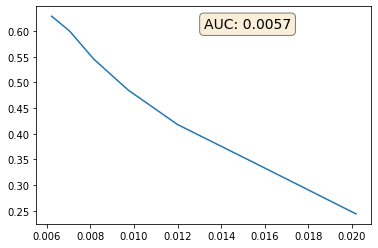

In [16]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(pur[2:], eff[2:])
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(pur[2:], eff[2:])), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

Loss 1: 0.03238826245069504 Loss 2: 0.998380184173584
EDGES: True positive: 29786 True: 29820 Positive 30880
CLUSTER: True positive: 7157.0 True: 29820 Positive: 4418414
Loss 1: 0.03371492400765419 Loss 2: 0.9987834095954895
EDGES: True positive: 39653 True: 39720 Positive 40917
CLUSTER: True positive: 6968.0 True: 39720 Positive: 5727722
Loss 1: 0.03964247554540634 Loss 2: 0.9985302686691284
EDGES: True positive: 33020 True: 33098 Positive 34415
CLUSTER: True positive: 7125.0 True: 33098 Positive: 4847843
Loss 1: 0.0368376150727272 Loss 2: 0.9986147880554199
EDGES: True positive: 34819 True: 34914 Positive 35968
CLUSTER: True positive: 7069.0 True: 34914 Positive: 5103098
Loss 1: 0.034479089081287384 Loss 2: 0.9987242817878723
EDGES: True positive: 37968 True: 38032 Positive 39321
CLUSTER: True positive: 6924.0 True: 38032 Positive: 5427422
Loss 1: 0.033777471631765366 Loss 2: 0.9988492727279663
EDGES: True positive: 41022 True: 41080 Positive 42427
CLUSTER: True positive: 6832.0 True

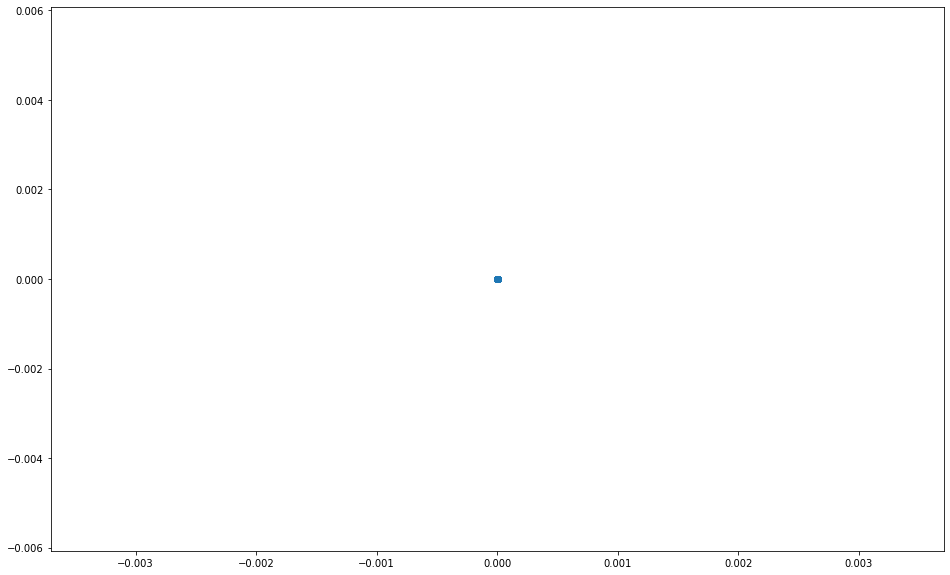

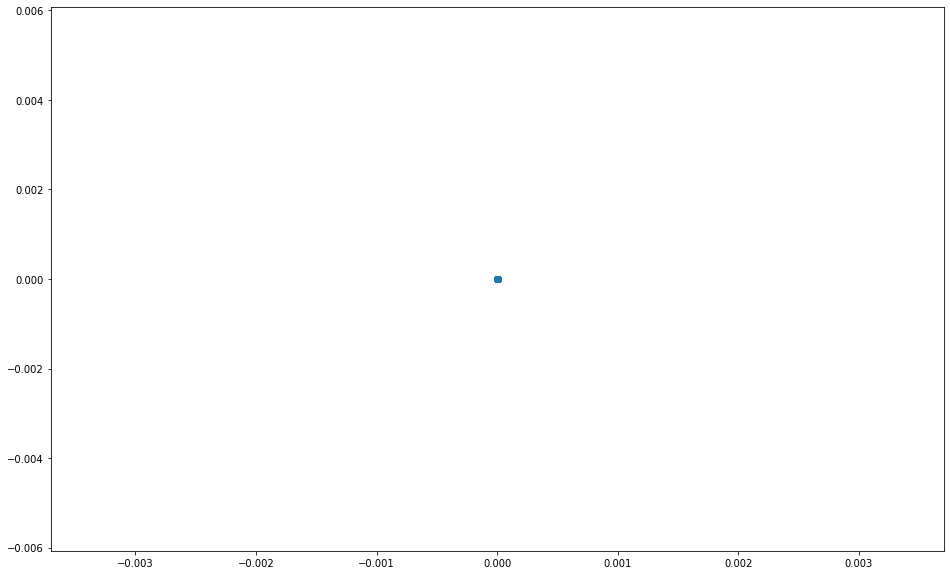

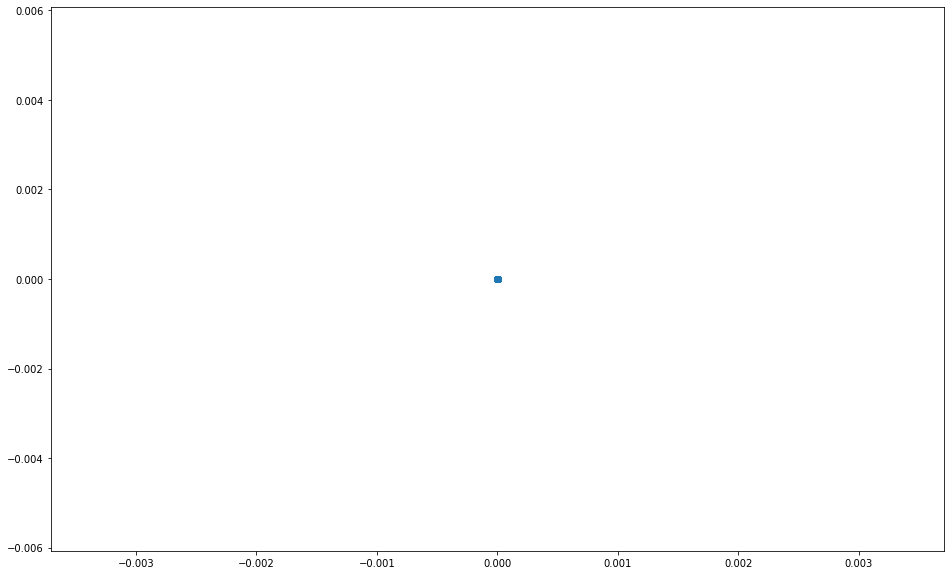

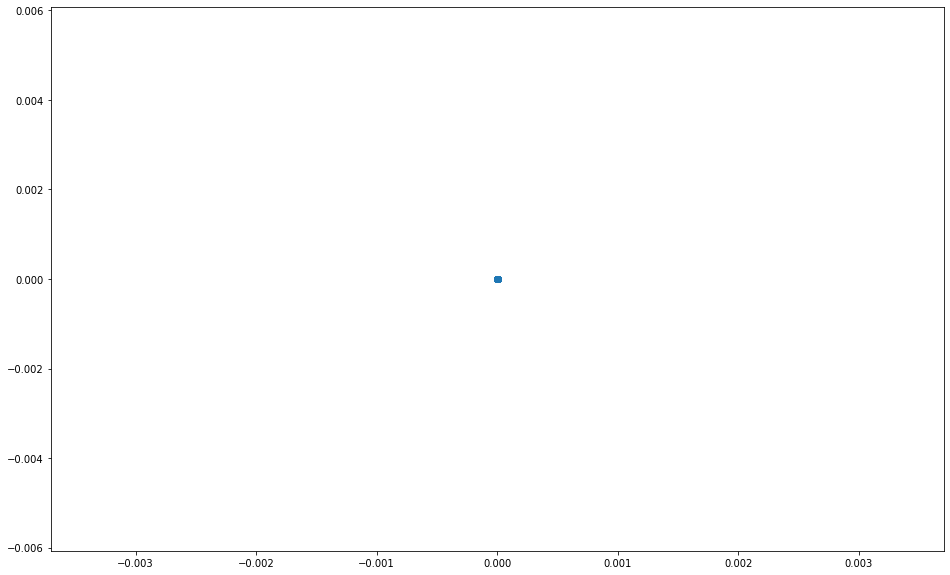

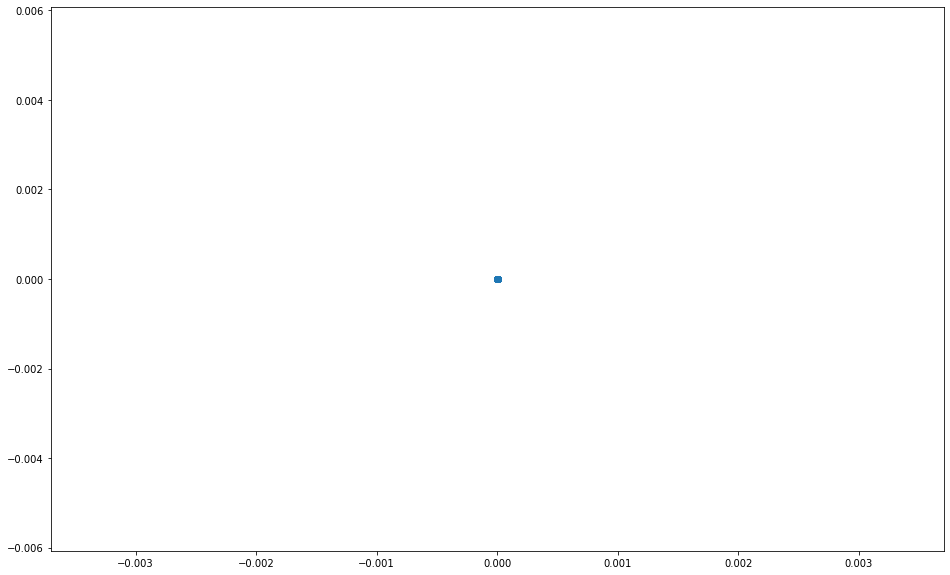

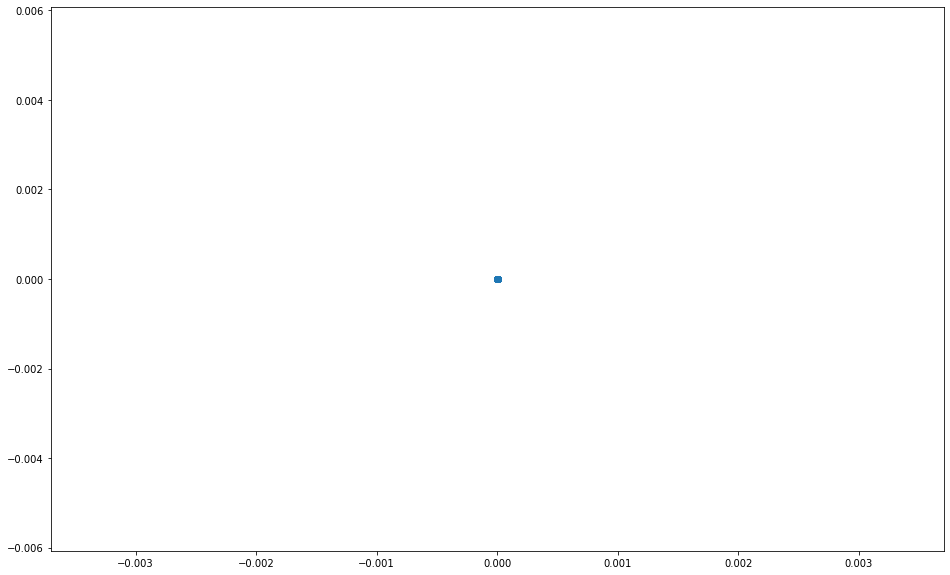

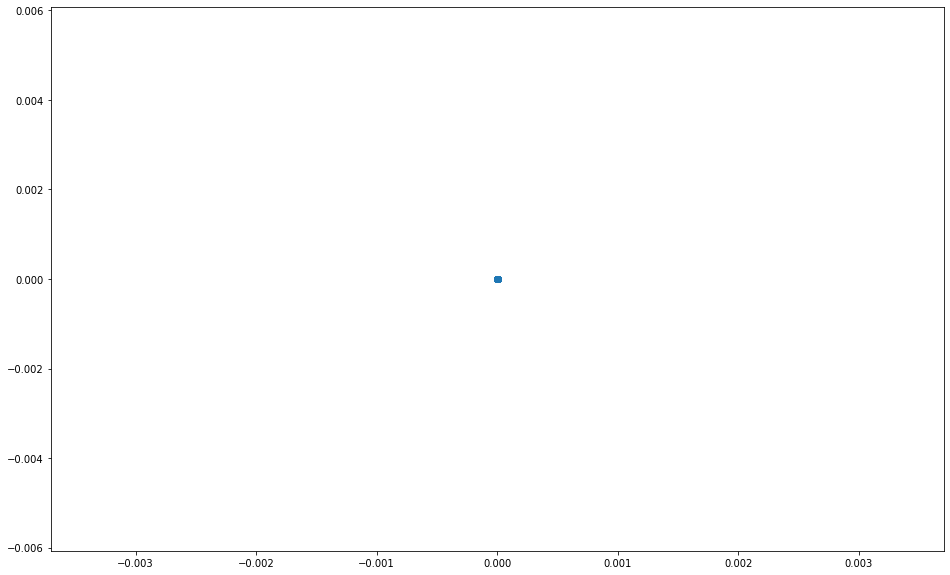

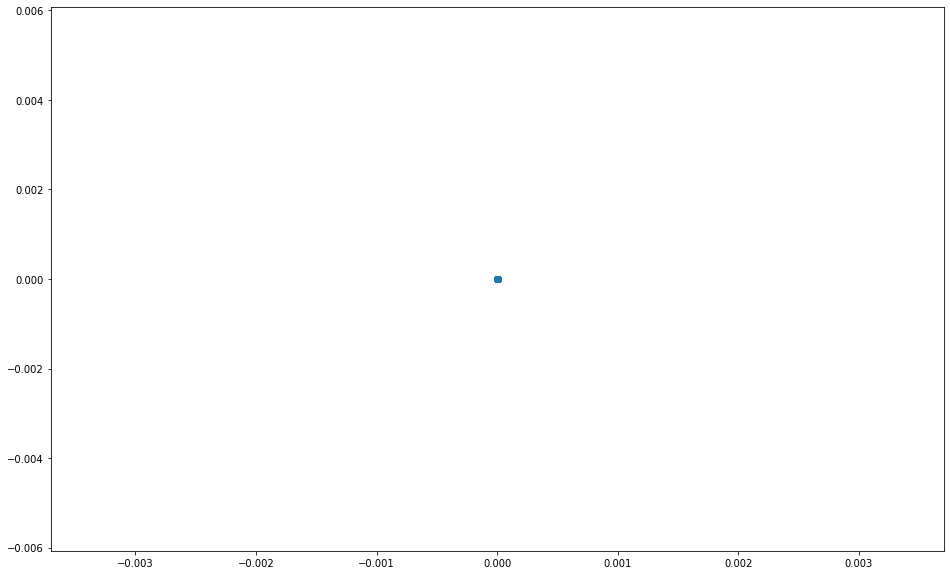

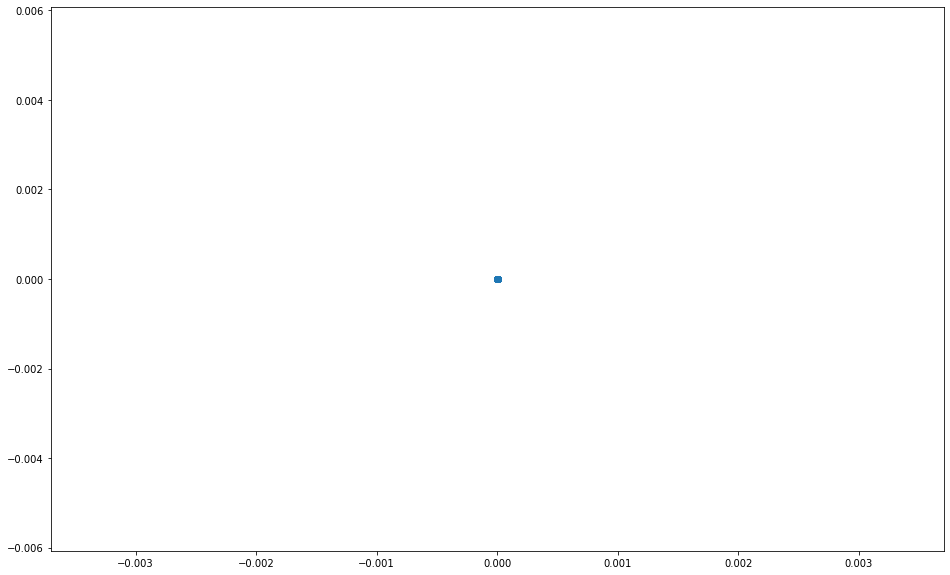

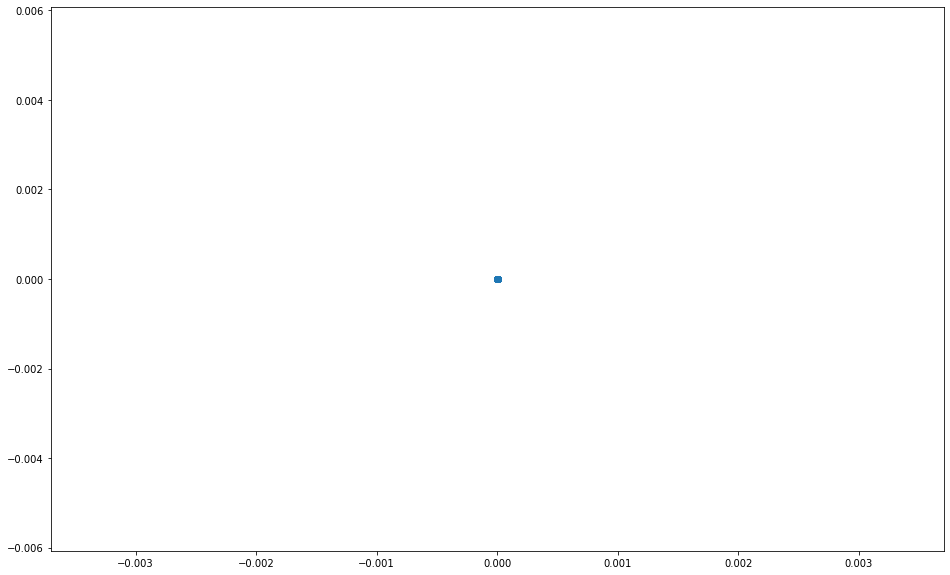

In [58]:
model.eval()
edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

for batch in test_loader:
    data = batch.to(device)
    pred, spatial, e = model(data)

    e_spatial = radius_graph(spatial, r=1, batch=batch.batch, loop=False, max_num_neighbors=1000)

    reference = spatial.index_select(0, e_spatial[1])
    neighbors = spatial.index_select(0, e_spatial[0])

    d = torch.sum((reference - neighbors)**2, dim=-1)

    y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
    y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
    
    
    hinge = y_cluster.float()
    hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  
    
    loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
    loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge)#, margin=m_configs["r"])
    print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
    
    embedded = spatial.cpu().detach().numpy()    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embedded)
    #         print("PCA", pca_result)
    plt.figure(figsize=(16,10))
    plt.scatter(pca_result[:,0], pca_result[:,1])

    #Cluster performance
    batch_cpu = batch.pid.cpu()
    pids, counts = np.unique(batch_cpu, return_counts=True)
    cluster_true = (counts * (counts - 1)).sum()

    cluster_true_positive = (y_cluster.float()).sum().item()
    cluster_total_true_positive += cluster_true_positive
    
    cluster_positive = len(e_spatial[0])
    cluster_total_positive += max(cluster_positive, 1)

    cluster_total_true += cluster_true
    
    #Edge performance
    edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
    edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

    edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

    edge_true_positive += (edge_true & edge_positive).sum().item()
    edge_total_true += edge_true.sum().item()
    edge_total_positive += edge_positive.sum().item()

    print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
    print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)
    
    total += len(pred)

edge_acc = edge_correct/total
edge_eff = (edge_true_positive / edge_total_true)
edge_pur = (edge_true_positive / edge_total_positive)

cluster_eff = (cluster_total_true_positive / cluster_total_true)
cluster_pur = (cluster_total_true_positive / cluster_total_positive)

print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))

## AdjacentEmbAGNN

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Embedding(torch.nn.Module):
    def __init__(self, in_channels, nb_hidden, nb_layer, emb_dim=3):
        super(Embedding, self).__init__()
        layers = [Linear(in_channels, nb_hidden)]
        ln = [Linear(nb_hidden, nb_hidden) for _ in range(nb_layer-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(nb_hidden, emb_dim)
        self.norm = torch.nn.LayerNorm(nb_hidden)
        self.act = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.7)
#         self.mean = torch.FloatTensor(mean).to(torch.float)
#         self.std = torch.FloatTensor(std).to(torch.float)

    def forward(self, x):
#         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
            # hits = self.dropout(hits)
        x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

    def normalize(self, hits):
        try:
            hits = (hits-self.mean) / (self.std + 10**-9)
        except:
            self.mean = self.mean.to(device=hits.device)
            self.std  = self.std.to(device=hits.device)
            hits = (hits-self.mean) / (self.std + 10**-9)
        return hits

In [26]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)

class EmbAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_spatial_network = make_mlp(in_channels, [emb_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.input_feature_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
#         self.combine_network = make_mlp(emb_dim + hidden_dim, [hidden_dim],
#                                       output_activation=hidden_activation,
#                                       layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(emb_dim + hidden_dim, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.input_spatial_network(x)
        features = self.input_feature_network(x)
#         spatial = self.spatial_norm(spatial)
        edge_index = knn_graph(spatial, k=self.k, batch=inputs.batch, loop=False)
#         print(edge_index.shape)

        # Shortcut connect the inputs onto the hidden representation
#         x = torch.cat([spatial, features], dim=-1)
#         x = self.combine_network(x)
#         print(features.shape)    
#         print(spatial.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
#             x = torch.cat([spatial, features], dim=-1)
#             print(features.shape)            
            spatial = self.emb_network(torch.cat([features, spatial], axis=-1))
#             edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
            edge_index = knn_graph(spatial, k=self.k, batch=inputs.batch, loop=False)
#             print(edge_index.shape)
#             print(spatial.shape)
            # Shortcut connect the inputs onto the hidden representation            
#             features = torch.cat([x, inputs.x], dim=-1)
             
            features = features_inital + features
        
        return self.edge_network(features, edge_index), spatial, edge_index

class EmbAGNNBalanced(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNNBalanced, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_spatial_network = make_mlp(in_channels, [emb_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.input_feature_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
#         self.combine_network = make_mlp(emb_dim + hidden_dim, [hidden_dim],
#                                       output_activation=hidden_activation,
#                                       layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(emb_dim + hidden_dim + in_channels, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.input_spatial_network(x)
        features = self.input_feature_network(x)
        spatial = self.emb_network(torch.cat([inputs.x, features, spatial], axis=-1))
        
#         # Get true edge list
#         records_array = inputs.pid.cpu()
#         idx_sort = np.argsort(records_array)
#         sorted_records_array = records_array[idx_sort]
#         _, idx_start, _ = np.unique(sorted_records_array, return_counts=True,
#                                 return_index=True)

#         # sets of indices
#         res = np.split(idx_sort, idx_start[1:])
#         true_list = torch.cat([torch.tensor(list(permutations(i, r=2))) for i in res if len(list(permutations(i, r=2))) > 0])
        
# #         print(batch.pid[true_list.T[0]] == batch.pid[true_list.T[1]])
        
#         # Get fake edge list
#         candidates = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=200)
#         fake_list = candidates[:,inputs.pid[candidates[0]] != inputs.pid[candidates[1]]]
        
        # Concatenate all candidates
#         edge_index = torch.cat([fake_list, true_list.T.to(device)], axis=-1)
        
        edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
            spatial = self.emb_network(torch.cat([inputs.x, features, spatial], axis=-1))
            
#             # Get fake edge list
#             candidates = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=200)
#             fake_list = candidates[:,inputs.pid[candidates[0]] != inputs.pid[candidates[1]]]
            # Concatenate all candidates
#             edge_index = torch.cat([fake_list, true_list.T.to(device)], axis=-1)
        
            edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
             
            features = features_inital + features
        
        return self.edge_network(features, edge_index), spatial, edge_index

class EmbAGNNRecluster(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNNRecluster, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_spatial_network = make_mlp(in_channels, [emb_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.input_feature_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
#         self.combine_network = make_mlp(emb_dim + hidden_dim, [hidden_dim],
#                                       output_activation=hidden_activation,
#                                       layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network_1 = Embedding(emb_dim + hidden_dim + in_channels, emb_hidden, nb_layer, emb_dim)
        self.emb_network_2 = Embedding(emb_dim + hidden_dim + in_channels, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.input_spatial_network(x)
        features = self.input_feature_network(x)
        spatial = self.emb_network_1(torch.cat([inputs.x, features, spatial], axis=-1))
        
        edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters//2):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
            features = features_inital + features
        
           
        spatial = self.emb_network_2(torch.cat([inputs.x, features, spatial], axis=-1))
        edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
             
        for i in range(self.n_graph_iters//2):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
            features = features_inital + features
            
        
        return self.edge_network(features, edge_index), spatial, edge_index

In [93]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
                
#         e_spatial = radius_graph(spatial, r=m_configs["r_train"], batch=batch.batch, loop=False, max_num_neighbors=1000)
        e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_1 + loss_2
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
#         e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=1000)
        e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())

        loss = loss_1.item() + loss_2.item()
        total_loss += loss
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [27]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer, loss_fn):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        
        # Get fake edge list
        candidates = radius_graph(spatial, r=m_configs['r_train'], batch=batch.batch, loop=False, max_num_neighbors=200)
        fake_list = candidates[:,batch.pid[candidates[0]] != batch.pid[candidates[1]]]
        
#         print(batch.pid[fake_list[0]] == batch.pid[fake_list[1]])
        
        # Concatenate all candidates
        e_spatial = torch.cat([fake_list, batch.true_edges.T.to(device)], axis=-1)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_fn([loss_1, loss_2])
#         print("Combined loss:", loss, "Noise params:", loss_fn.noise_params)
#         print(loss)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader, loss_fn):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=200)
#         e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_fn([loss_1, loss_2]).item()
        print("Combined loss:", loss, "Noise params:", loss_fn.noise_params)
        total_loss += loss
        
        #Cluster performance
        cluster_true = len(batch.true_edges)

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [28]:
class MultiNoiseLoss(nn.Module):
    def __init__(self, n_losses):
        super(MultiNoiseLoss, self).__init__()
        self.noise_params = torch.rand(n_losses, requires_grad=True, device="cuda:0")
    
    def forward(self, losses):
        
        total_loss = 0
        for i, loss in enumerate(losses):
            total_loss += (1/torch.square(self.noise_params[i]))*loss + torch.log(self.noise_params[i])
        
        return total_loss

In [29]:
m_configs = {"in_channels": 3, "emb_hidden": 64, "nb_layer": 4, "emb_dim": 12, "r": 1, "hidden_dim": 64, "n_graph_iters": 6}
other_configs = {"k": 20, "r_train": 0.8, "r_val": 1, "margin": 0.8, 'reduction':'mean'}
model = EmbAGNNRecluster(**m_configs).to(device)
multi_loss = MultiNoiseLoss(n_losses=2).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="AdjacentEmbAGNN", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=30)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


In [30]:
optimizer = torch.optim.AdamW([
    {'params': chain(model.emb_network_1.parameters(), model.emb_network_2.parameters(), model.input_spatial_network.parameters())},
    {'params': chain(model.node_network.parameters(), model.edge_network.parameters(), model.input_feature_network.parameters())},
    {'params': multi_loss.noise_params}],
lr = 0.001, weight_decay=1e-3, amsgrad=True)

In [31]:
lambda1 = lambda ep: 1 / (1.5**(ep//10))
lambda2 = lambda ep: 1 / (1.5**(ep//30))
lambda3 = lambda ep: 1 / (1.1**(ep//10))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2, lambda3])

In [ ]:
weight = 1
for epoch in range(100):
    tic = tt()
    model.train()
    edge_acc, cluster_pur, train_loss = train(model, train_loader, optimizer, multi_loss)
    print("Training loss:", train_loss)

    model.eval()
    edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss = evaluate(model, test_loader, multi_loss)
    scheduler.step(val_loss)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_acc": edge_acc, "edge_pur": edge_pur, "edge_eff": edge_eff, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0]})

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'EmbAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Edge Accuracy: {:.4f}, Edge Purity: {:.4f}, Edge Efficiency: {:.4f}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, scheduler._last_lr[0], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training loss: 1065.1553950309753
Loss 1: 0.26459774374961853 Loss 2: 0.25923672318458557
Combined loss: 2.9559054374694824 Noise params: tensor([0.4575, 0.2606], device='cuda:0', requires_grad=True)
EDGES: True positive: 0 True: 2913 Positive 1
CLUSTER: True positive: 2913.0 True: 4018 Positive: 35424
Loss 1: 0.226004496216774 Loss 2: 0.2501017153263092
Combined loss: 2.6369383335113525 Noise params: tensor([0.4575, 0.2606], device='cuda:0', requires_grad=True)
EDGES: True positive: 2 True: 3774 Positive 4
CLUSTER: True positive: 3774.0 True: 5147 Positive: 57328
Loss 1: 0.2419450879096985 Loss 2: 0.2542475163936615
Combined loss: 2.774174213409424 Noise params: tensor([0.4575, 0.2606], device='cuda:0', requires_grad=True)
EDGES: True positive: 2 True: 3553 Positive 5
CLUSTER: True positive: 3553.0 True: 4855 Positive: 49550
Loss 1: 0.21964630484580994 Loss 2: 0.2529495656490326
Combined loss: 2.6485066413879395 Noise params: tensor([0.4575, 0.2606], device='cuda:0', requires_grad=Tru

/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: 0, Edge Accuracy: 0.9275, Edge Purity: 0.4118, Edge Efficiency: 0.0004, Cluster Purity: 0.0725, Cluster Efficiency: 0.7263, Loss: 28.3743, LR: 0.0004444444444444444 in time 40.466493368148804
Training loss: 548.201877117157
Loss 1: 0.28953301906585693 Loss 2: 0.2602488100528717
Combined loss: 2.1187586784362793 Noise params: tensor([0.5185, 0.2993], device='cuda:0', requires_grad=True)
EDGES: True positive: 1298 True: 4398 Positive 2081
CLUSTER: True positive: 4398.0 True: 4666 Positive: 30076
Loss 1: 0.28601986169815063 Loss 2: 0.26206186413764954
Combined loss: 2.125926971435547 Noise params: tensor([0.5185, 0.2993], device='cuda:0', requires_grad=True)
EDGES: True positive: 1451 True: 4768 Positive 2276
CLUSTER: True positive: 4768.0 True: 5147 Positive: 32744
Loss 1: 0.30307480692863464 Loss 2: 0.26867160201072693
Combined loss: 2.2631449699401855 Noise params: tensor([0.5185, 0.2993], device='cuda:0', requires_grad=True)
EDGES: True positive: 1309 True: 3726 Positive 2010
C

Loss 1: 0.153951495885849 Loss 2: 0.26579201221466064
Combined loss: 0.996024489402771 Noise params: tensor([0.5852, 0.3540], device='cuda:0', requires_grad=True)
EDGES: True positive: 2919 True: 3774 Positive 3528
CLUSTER: True positive: 3774.0 True: 3897 Positive: 22100
Loss 1: 0.15151432156562805 Loss 2: 0.26195576786994934
Combined loss: 0.958298921585083 Noise params: tensor([0.5852, 0.3540], device='cuda:0', requires_grad=True)
EDGES: True positive: 3101 True: 4266 Positive 3807
CLUSTER: True positive: 4266.0 True: 4407 Positive: 28394
Loss 1: 0.15329639613628387 Loss 2: 0.2615772485733032
Combined loss: 0.9604831337928772 Noise params: tensor([0.5852, 0.3540], device='cuda:0', requires_grad=True)
EDGES: True positive: 3260 True: 4572 Positive 3977
CLUSTER: True positive: 4572.0 True: 4666 Positive: 29984
EDGE Accuracy: 0.9316, Purity: 0.8038, Efficiency: 0.7326
CLUSTER Purity: 0.1533, Efficiency: 0.9642
Epoch: 3, Edge Accuracy: 0.9316, Edge Purity: 0.8038, Edge Efficiency: 0.732

Loss 1: 0.09514306485652924 Loss 2: 0.2762684226036072
Combined loss: 0.4018026888370514 Noise params: tensor([0.5401, 0.4214], device='cuda:0', requires_grad=True)
EDGES: True positive: 3276 True: 3741 Positive 3761
CLUSTER: True positive: 3741.0 True: 3897 Positive: 19380
Loss 1: 0.10507135093212128 Loss 2: 0.272817462682724
Combined loss: 0.41640710830688477 Noise params: tensor([0.5401, 0.4214], device='cuda:0', requires_grad=True)
EDGES: True positive: 4168 True: 4875 Positive 4906
CLUSTER: True positive: 4875.0 True: 5147 Positive: 27336
Loss 1: 0.10954953730106354 Loss 2: 0.2750578224658966
Combined loss: 0.4443778097629547 Noise params: tensor([0.5401, 0.4214], device='cuda:0', requires_grad=True)
EDGES: True positive: 3802 True: 4607 Positive 4555
CLUSTER: True positive: 4607.0 True: 4855 Positive: 27378
Loss 1: 0.10162912309169769 Loss 2: 0.27726441621780396
Combined loss: 0.42964956164360046 Noise params: tensor([0.5401, 0.4214], device='cuda:0', requires_grad=True)
EDGES: T

Combined loss: 0.2099962830543518 Noise params: tensor([0.5093, 0.4680], device='cuda:0', requires_grad=True)
EDGES: True positive: 3809 True: 4552 Positive 4254
CLUSTER: True positive: 4552.0 True: 4666 Positive: 24316
Loss 1: 0.08563137799501419 Loss 2: 0.2809121012687683
Combined loss: 0.1787707805633545 Noise params: tensor([0.5093, 0.4680], device='cuda:0', requires_grad=True)
EDGES: True positive: 3420 True: 3896 Positive 3787
CLUSTER: True positive: 3896.0 True: 4018 Positive: 18656
Loss 1: 0.09881085902452469 Loss 2: 0.28178608417510986
Combined loss: 0.233566015958786 Noise params: tensor([0.5093, 0.4680], device='cuda:0', requires_grad=True)
EDGES: True positive: 3847 True: 4717 Positive 4357
CLUSTER: True positive: 4717.0 True: 4855 Positive: 25676
Loss 1: 0.07964025437831879 Loss 2: 0.28482985496520996
Combined loss: 0.1735648512840271 Noise params: tensor([0.5093, 0.4680], device='cuda:0', requires_grad=True)
EDGES: True positive: 3370 True: 3818 Positive 3692
CLUSTER: Tru

Loss 1: 0.08327154070138931 Loss 2: 0.2815675735473633
Combined loss: 0.07275226712226868 Noise params: tensor([0.4662, 0.4924], device='cuda:0', requires_grad=True)
EDGES: True positive: 3589 True: 4160 Positive 3962
CLUSTER: True positive: 4160.0 True: 4357 Positive: 22020
EDGE Accuracy: 0.9567, Purity: 0.9076, Efficiency: 0.8505
CLUSTER Purity: 0.1835, Efficiency: 0.9670
Epoch: 11, Edge Accuracy: 0.9567, Edge Purity: 0.9076, Edge Efficiency: 0.8505, Cluster Purity: 0.1835, Cluster Efficiency: 0.9670, Loss: 0.5952, LR: 0.001 in time 34.39933800697327
Training loss: 51.27373883128166
Loss 1: 0.10313541442155838 Loss 2: 0.2856157720088959
Combined loss: 0.15223073959350586 Noise params: tensor([0.4458, 0.5032], device='cuda:0', requires_grad=True)
EDGES: True positive: 3588 True: 4140 Positive 4000
CLUSTER: True positive: 4140.0 True: 4357 Positive: 19262
Loss 1: 0.10947366803884506 Loss 2: 0.28146445751190186
Combined loss: 0.16772782802581787 Noise params: tensor([0.4458, 0.5032], de

Loss 1: 0.07927826046943665 Loss 2: 0.28192880749702454
Combined loss: -0.033688753843307495 Noise params: tensor([0.4257, 0.5228], device='cuda:0', requires_grad=True)
EDGES: True positive: 4365 True: 5133 Positive 4828
CLUSTER: True positive: 5133.0 True: 5303 Positive: 28670
Loss 1: 0.0752800703048706 Loss 2: 0.2741597890853882
Combined loss: -0.0841745138168335 Noise params: tensor([0.4257, 0.5228], device='cuda:0', requires_grad=True)
EDGES: True positive: 4345 True: 4937 Positive 4803
CLUSTER: True positive: 4937.0 True: 5147 Positive: 26634
Loss 1: 0.06169520691037178 Loss 2: 0.2827810049057007
Combined loss: -0.12760746479034424 Noise params: tensor([0.4257, 0.5228], device='cuda:0', requires_grad=True)
EDGES: True positive: 3443 True: 3787 Positive 3690
CLUSTER: True positive: 3787.0 True: 3897 Positive: 18686
EDGE Accuracy: 0.9617, Purity: 0.9110, Efficiency: 0.8820
CLUSTER Purity: 0.1877, Efficiency: 0.9646
Epoch: 14, Edge Accuracy: 0.9617, Edge Purity: 0.9110, Edge Efficien

### Results

In [14]:
model.eval()
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

pur, eff = [], []
r_min, r_max, r_step = 0.1, 1, 0.1


for r in np.arange(r_min, r_max, r_step):
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)

        e_spatial = radius_graph(spatial, r=r, batch=batch.batch, loop=False, max_num_neighbors=1000)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
        print("r", r, "e len", len(e_spatial[0]))

        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

    eff.append(cluster_total_true_positive / cluster_total_true)
    pur.append(cluster_total_true_positive / cluster_total_positive)
    
pur, eff = np.array(pur), np.array(eff)

r 0.1 e len 40642
r 0.1 e len 41948
r 0.1 e len 40780
r 0.1 e len 37382
r 0.1 e len 43624
r 0.1 e len 38442
r 0.1 e len 30972
r 0.1 e len 18204
r 0.1 e len 39448
r 0.1 e len 33024
r 0.2 e len 165878
r 0.2 e len 165290
r 0.2 e len 193562
r 0.2 e len 211956
r 0.2 e len 212452
r 0.2 e len 224848
r 0.2 e len 208902
r 0.2 e len 203168
r 0.2 e len 188948
r 0.2 e len 91736
r 0.30000000000000004 e len 521502
r 0.30000000000000004 e len 396890
r 0.30000000000000004 e len 226602
r 0.30000000000000004 e len 513222
r 0.30000000000000004 e len 413360
r 0.30000000000000004 e len 497994
r 0.30000000000000004 e len 514682
r 0.30000000000000004 e len 477138
r 0.30000000000000004 e len 551664
r 0.30000000000000004 e len 460548
r 0.4 e len 768486
r 0.4 e len 837312
r 0.4 e len 956844
r 0.4 e len 876332
r 0.4 e len 1009708
r 0.4 e len 924516
r 0.4 e len 417740
r 0.4 e len 946050
r 0.4 e len 717312
r 0.4 e len 936506
r 0.5 e len 1217050
r 0.5 e len 1579904
r 0.5 e len 1114560
r 0.5 e len 659440
r 0.5 e len

In [90]:
pur, eff = np.array(pur), np.array(eff)

In [15]:
pur, eff

(array([0.04886588, 0.02879242, 0.02019021, 0.01550792, 0.01199519,
        0.00972997, 0.00815024, 0.00703596, 0.00622132]),
 array([0.04706411, 0.14203266, 0.24401987, 0.34386132, 0.41815972,
        0.48530205, 0.54561598, 0.60048095, 0.62897046]))

Text(0.5, 0.95, 'AUC: 0.0057')

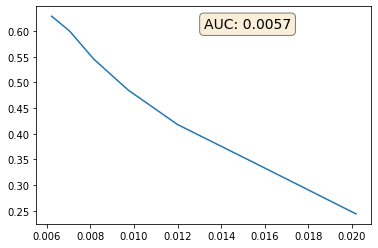

In [16]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(pur[2:], eff[2:])
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(pur[2:], eff[2:])), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

Loss 1: 0.03238826245069504 Loss 2: 0.998380184173584
EDGES: True positive: 29786 True: 29820 Positive 30880
CLUSTER: True positive: 7157.0 True: 29820 Positive: 4418414
Loss 1: 0.03371492400765419 Loss 2: 0.9987834095954895
EDGES: True positive: 39653 True: 39720 Positive 40917
CLUSTER: True positive: 6968.0 True: 39720 Positive: 5727722
Loss 1: 0.03964247554540634 Loss 2: 0.9985302686691284
EDGES: True positive: 33020 True: 33098 Positive 34415
CLUSTER: True positive: 7125.0 True: 33098 Positive: 4847843
Loss 1: 0.0368376150727272 Loss 2: 0.9986147880554199
EDGES: True positive: 34819 True: 34914 Positive 35968
CLUSTER: True positive: 7069.0 True: 34914 Positive: 5103098
Loss 1: 0.034479089081287384 Loss 2: 0.9987242817878723
EDGES: True positive: 37968 True: 38032 Positive 39321
CLUSTER: True positive: 6924.0 True: 38032 Positive: 5427422
Loss 1: 0.033777471631765366 Loss 2: 0.9988492727279663
EDGES: True positive: 41022 True: 41080 Positive 42427
CLUSTER: True positive: 6832.0 True

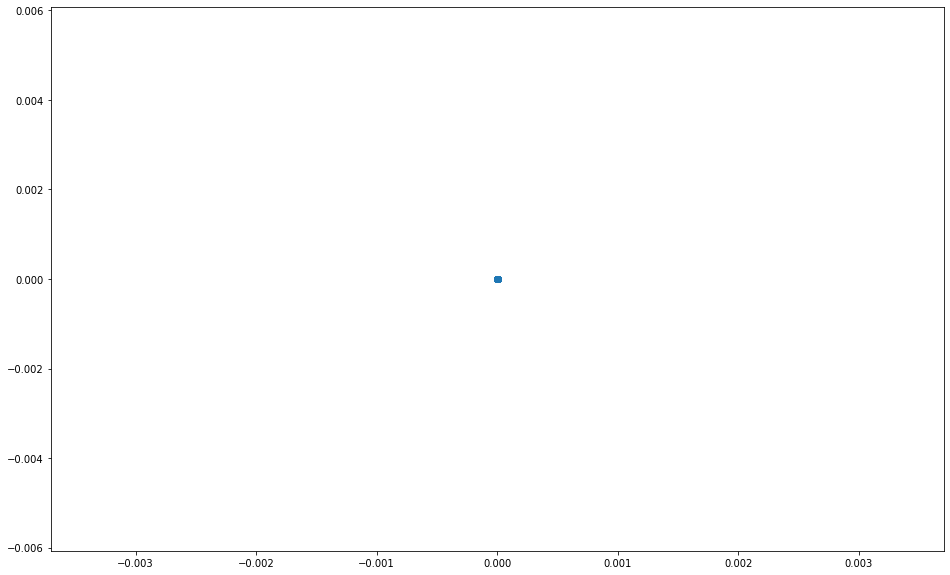

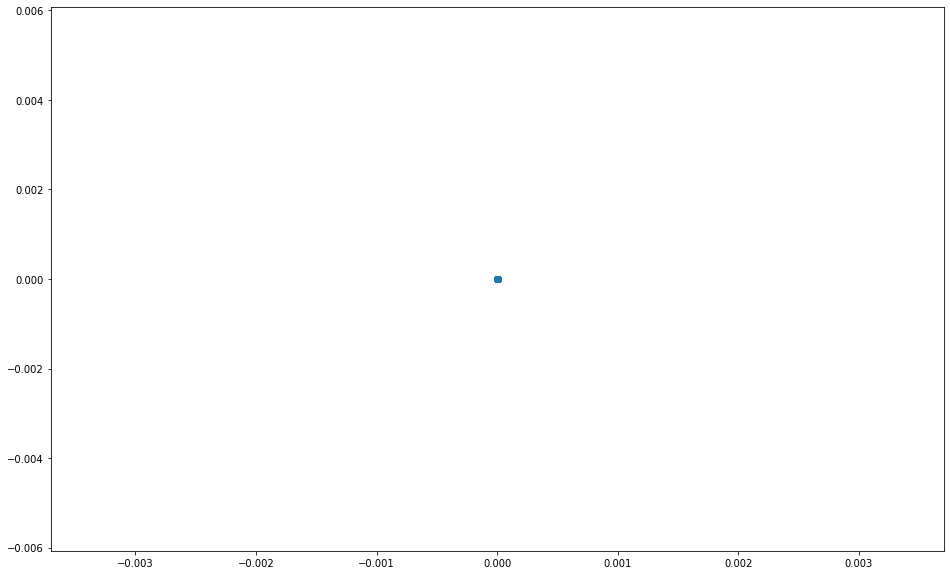

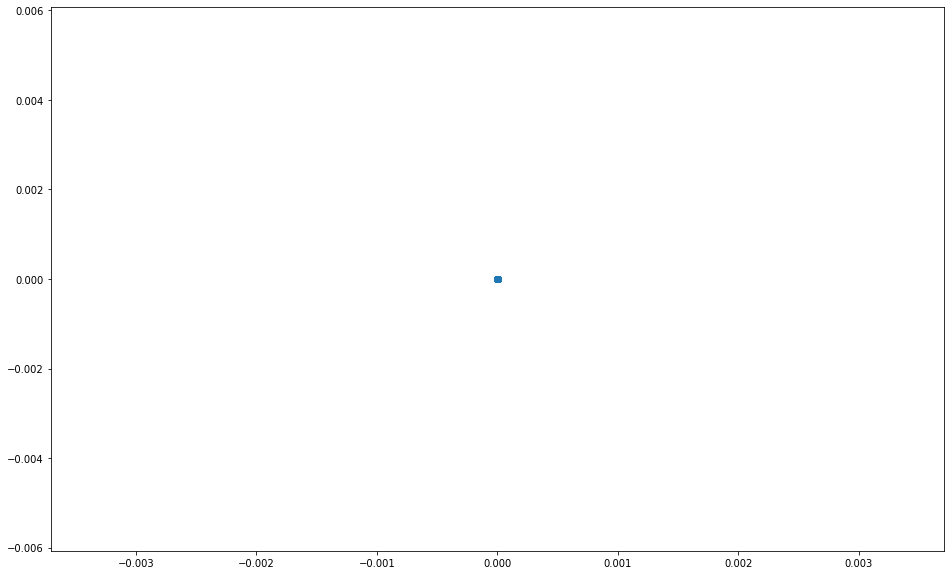

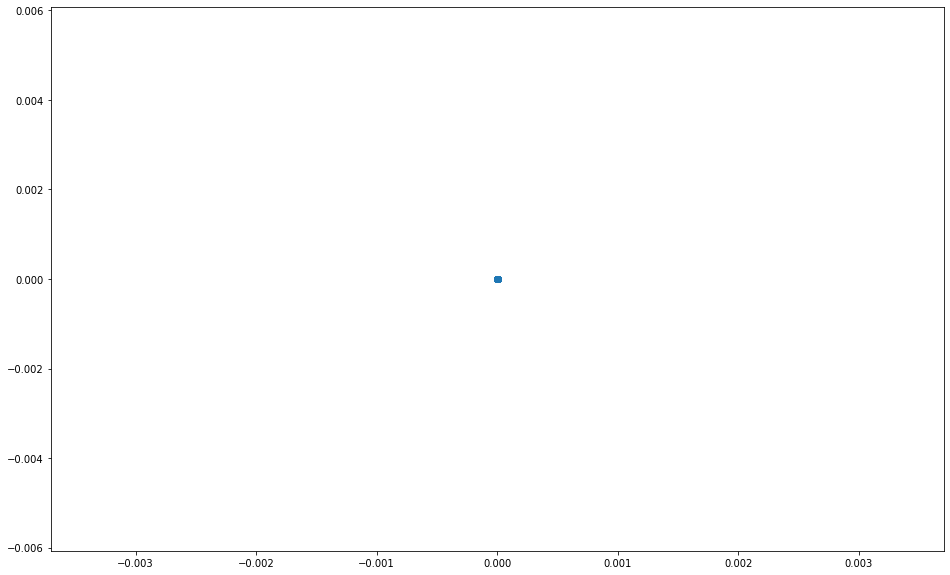

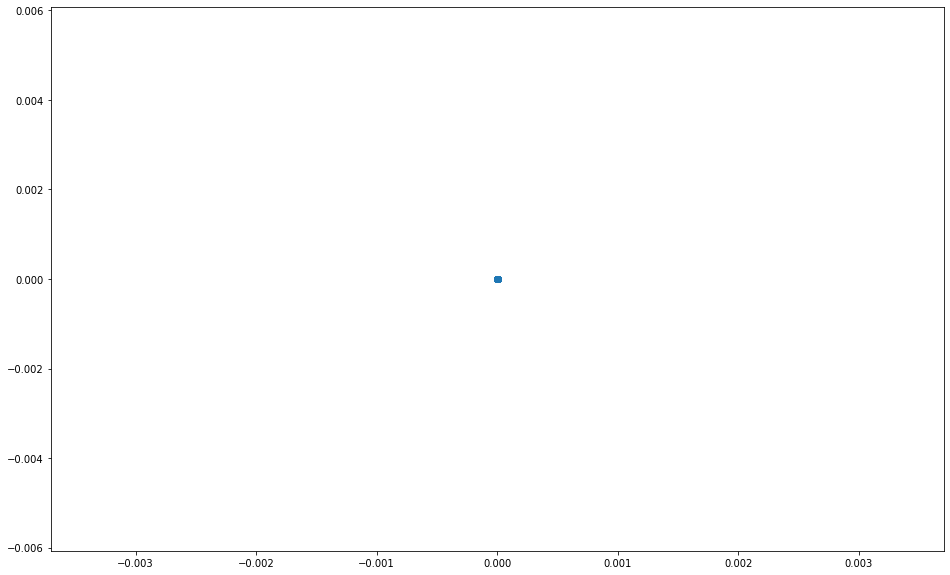

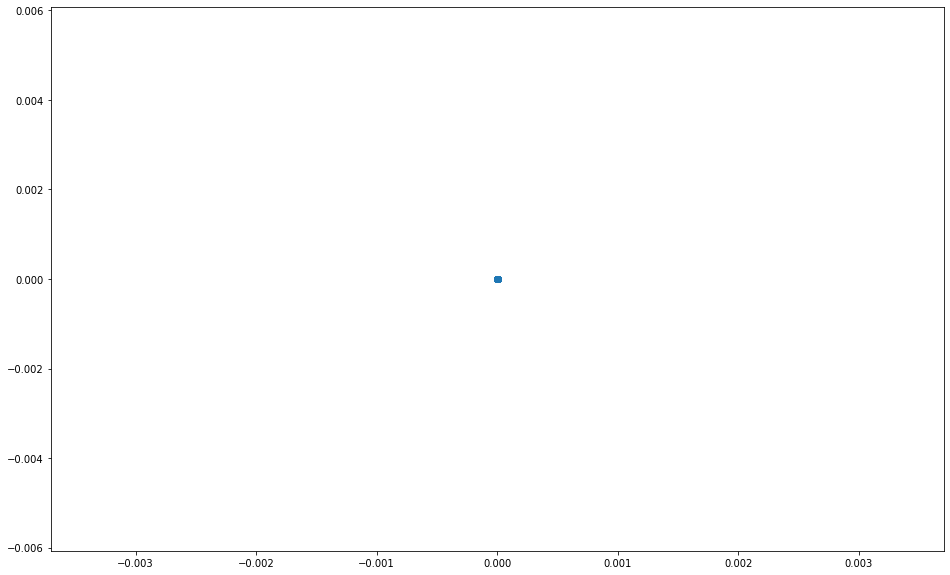

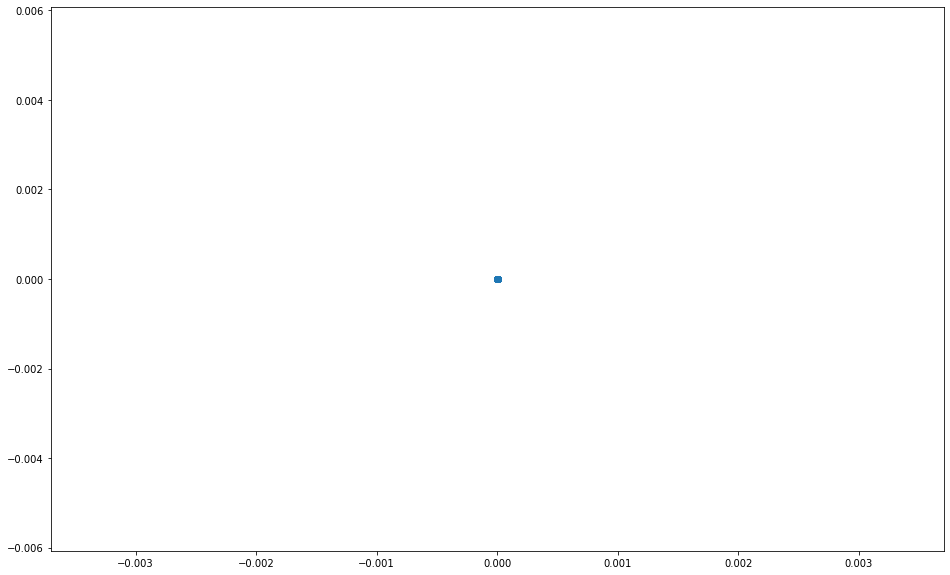

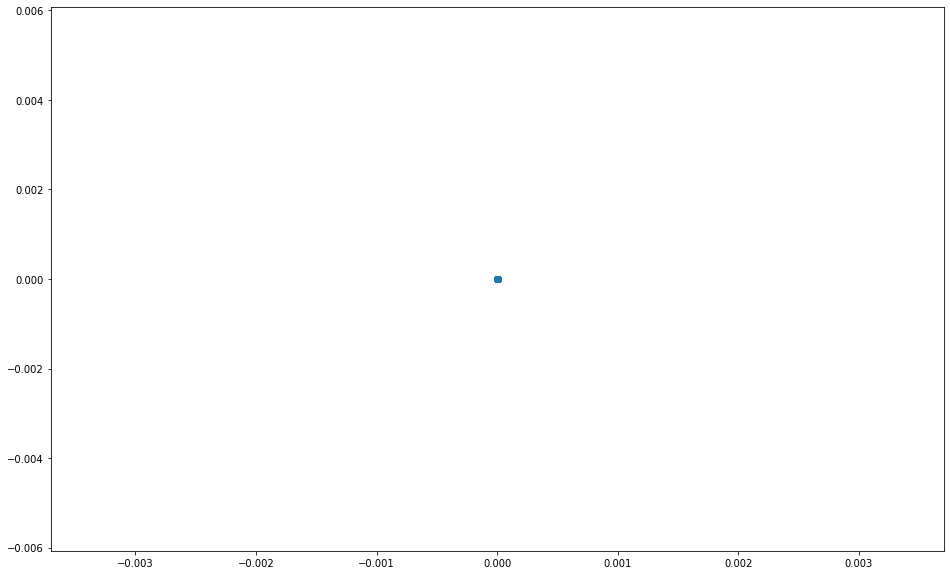

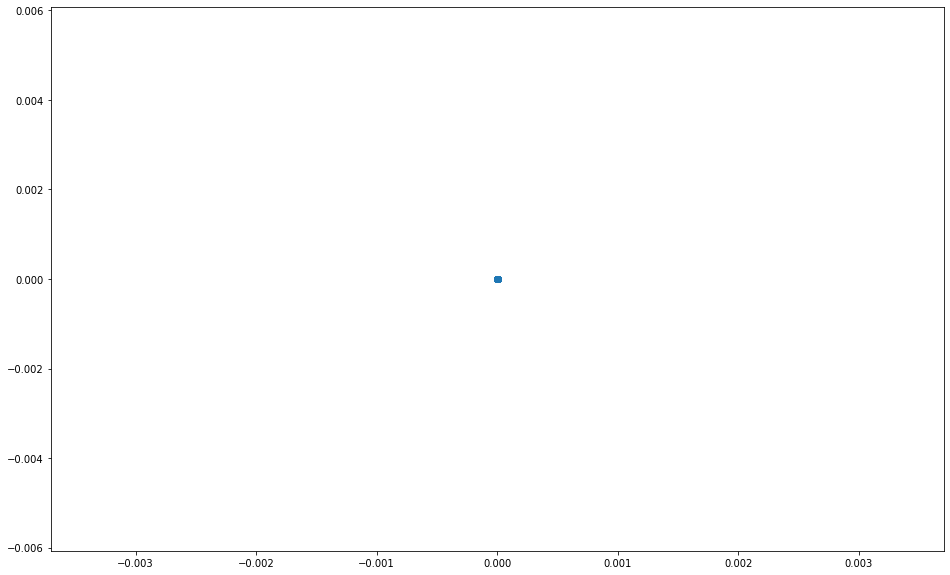

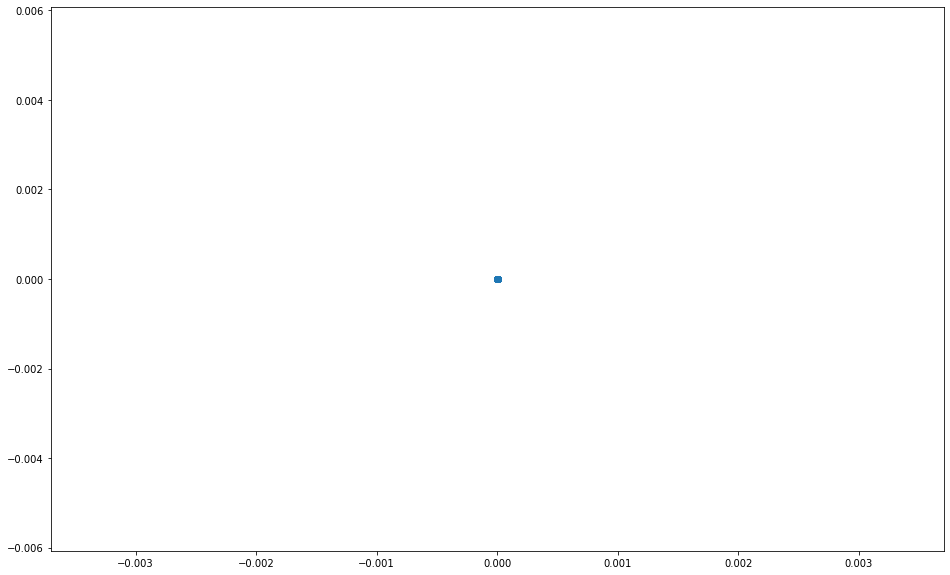

In [58]:
model.eval()
edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

for batch in test_loader:
    data = batch.to(device)
    pred, spatial, e = model(data)

    e_spatial = radius_graph(spatial, r=1, batch=batch.batch, loop=False, max_num_neighbors=1000)

    reference = spatial.index_select(0, e_spatial[1])
    neighbors = spatial.index_select(0, e_spatial[0])

    d = torch.sum((reference - neighbors)**2, dim=-1)

    y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
    y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
    
    
    hinge = y_cluster.float()
    hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  
    
    loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
    loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge)#, margin=m_configs["r"])
    print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
    
    embedded = spatial.cpu().detach().numpy()    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embedded)
    #         print("PCA", pca_result)
    plt.figure(figsize=(16,10))
    plt.scatter(pca_result[:,0], pca_result[:,1])

    #Cluster performance
    batch_cpu = batch.pid.cpu()
    pids, counts = np.unique(batch_cpu, return_counts=True)
    cluster_true = (counts * (counts - 1)).sum()

    cluster_true_positive = (y_cluster.float()).sum().item()
    cluster_total_true_positive += cluster_true_positive
    
    cluster_positive = len(e_spatial[0])
    cluster_total_positive += max(cluster_positive, 1)

    cluster_total_true += cluster_true
    
    #Edge performance
    edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
    edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

    edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

    edge_true_positive += (edge_true & edge_positive).sum().item()
    edge_total_true += edge_true.sum().item()
    edge_total_positive += edge_positive.sum().item()

    print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
    print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)
    
    total += len(pred)

edge_acc = edge_correct/total
edge_eff = (edge_true_positive / edge_total_true)
edge_pur = (edge_true_positive / edge_total_positive)

cluster_eff = (cluster_total_true_positive / cluster_total_true)
cluster_pur = (cluster_total_true_positive / cluster_total_positive)

print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))

### TrackML Score

In [6]:
from models import EmbeddingToAGNN

In [7]:
m_configs = {"in_channels": 3, "emb_hidden": 494, "nb_layer": 6, "emb_dim": 3, "r": 1.442, "hidden_dim": 55, "n_graph_iters": 9}
other_configs = {"k": 20, "r_train": 1.719, "r_val": 1.442, "margin": 1.243, 'reduction':'mean'}
model = EmbeddingToAGNN(**m_configs).to(device)
m_configs.update(other_configs)

checkpoint = torch.load('../model_comparisons/EmbeddingToAGNN/logical-sweep-53.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

EDGES: True positive: 7658 True: 7697 Positive 7779
CLUSTER: True positive: 7697.0 True: 7843 Positive: 50142
EDGES: True positive: 5706 True: 5721 Positive 5801
CLUSTER: True positive: 5721.0 True: 5832 Positive: 33532
EDGES: True positive: 6979 True: 6990 Positive 7048
CLUSTER: True positive: 6990.0 True: 7119 Positive: 45690
EDGES: True positive: 5406 True: 5425 Positive 5482
CLUSTER: True positive: 5427.0 True: 5544 Positive: 32532
EDGES: True positive: 6906 True: 6938 Positive 7056
CLUSTER: True positive: 6938.0 True: 7204 Positive: 43614
EDGES: True positive: 6184 True: 6202 Positive 6282
CLUSTER: True positive: 6202.0 True: 6295 Positive: 37920
EDGES: True positive: 6785 True: 6804 Positive 6900
CLUSTER: True positive: 6804.0 True: 6962 Positive: 44020
EDGES: True positive: 7108 True: 7123 Positive 7223
CLUSTER: True positive: 7125.0 True: 7259 Positive: 44992
EDGES: True positive: 5586 True: 5598 Positive 5667
CLUSTER: True positive: 5598.0 True: 5762 Positive: 31400
EDGES: Tru

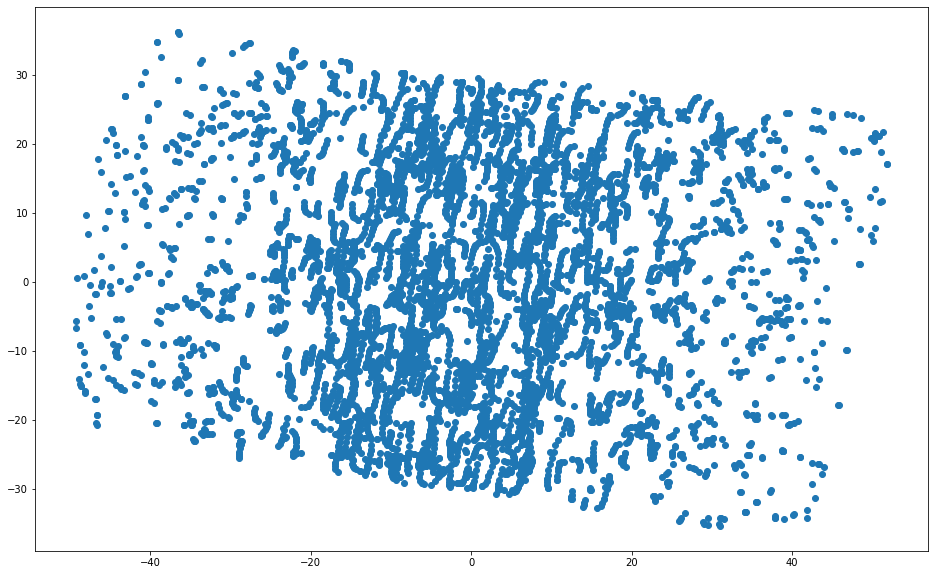

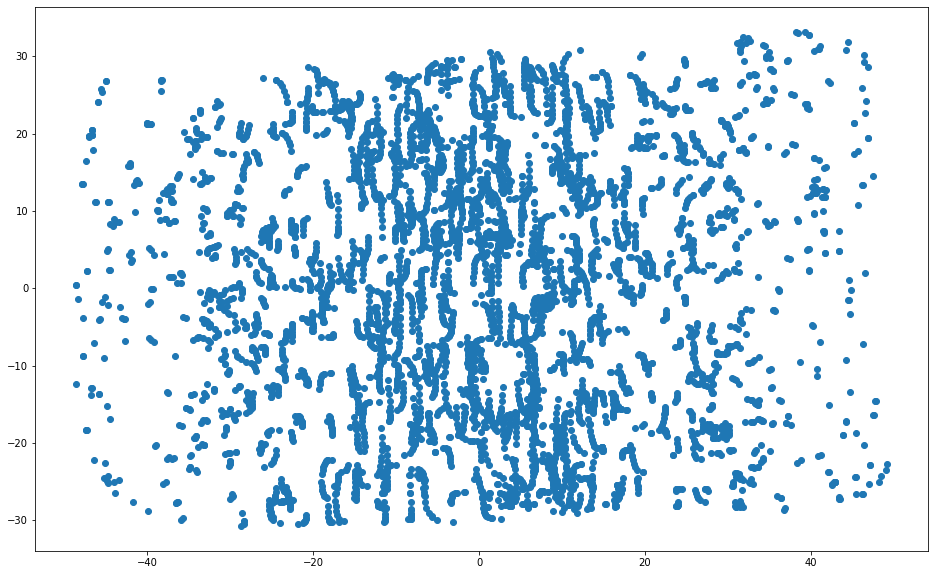

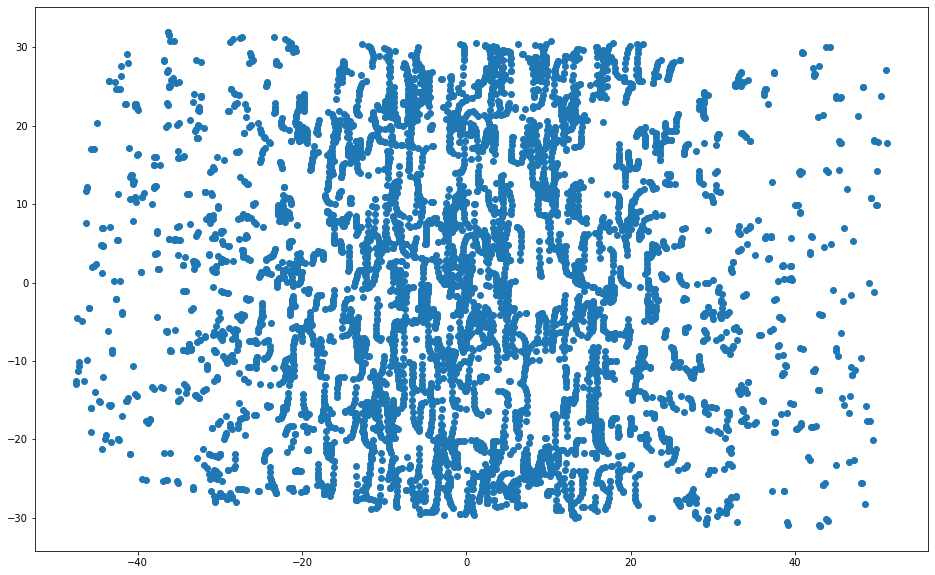

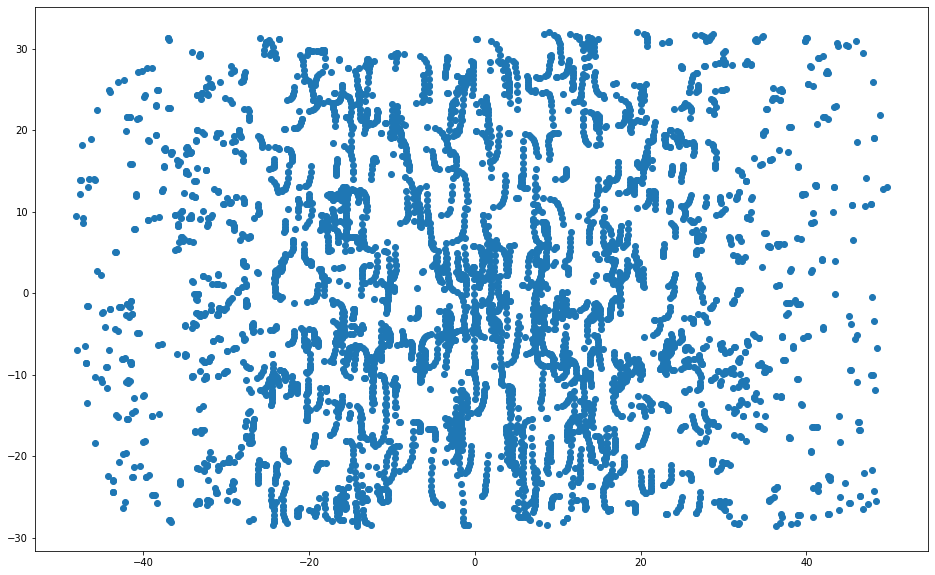

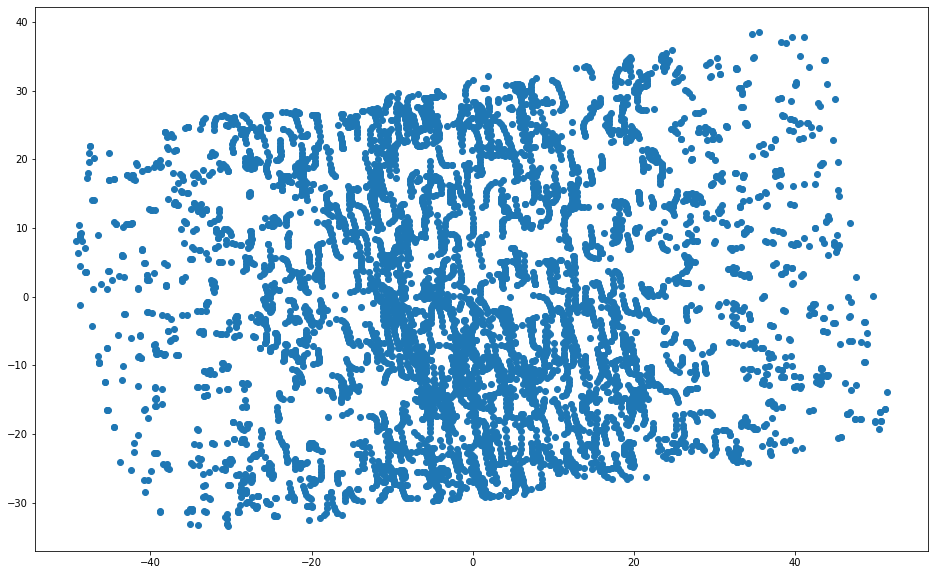

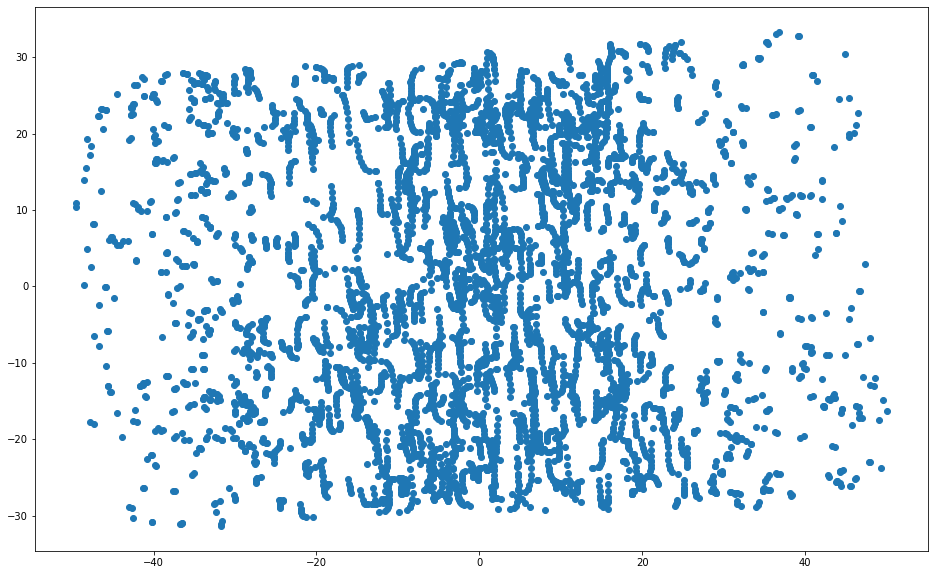

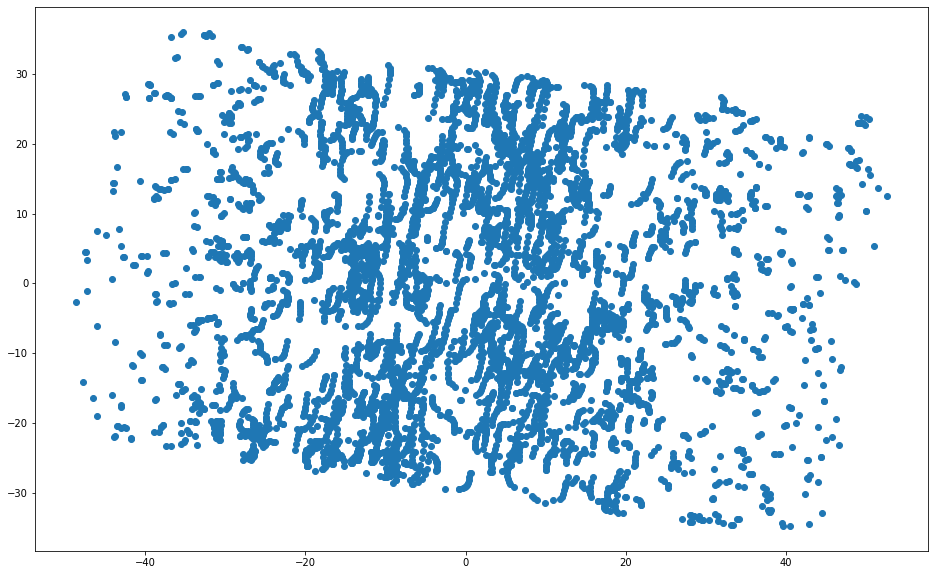

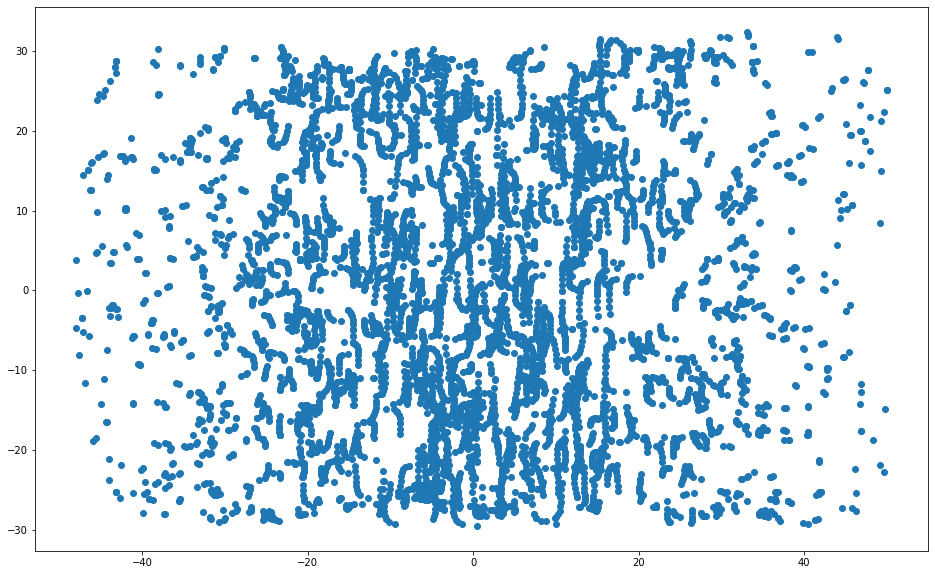

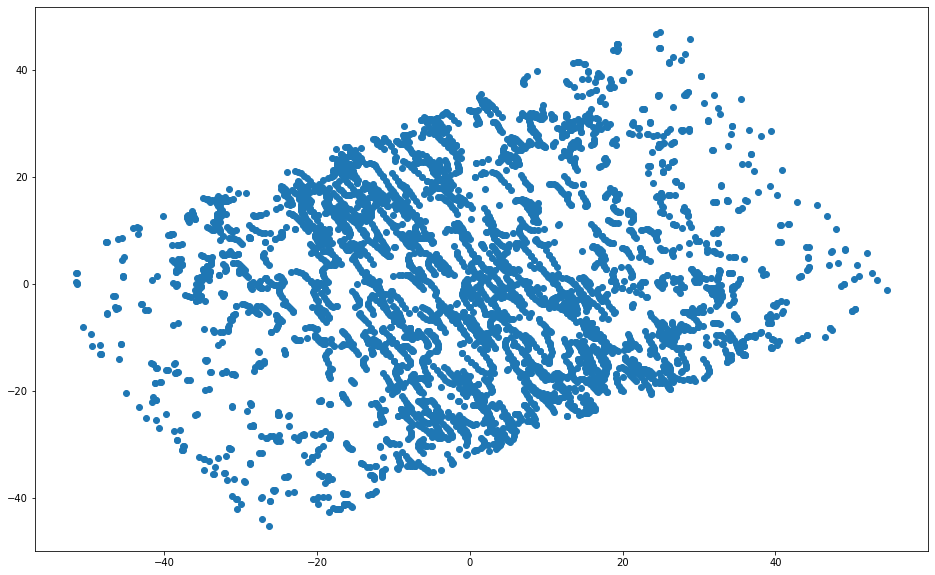

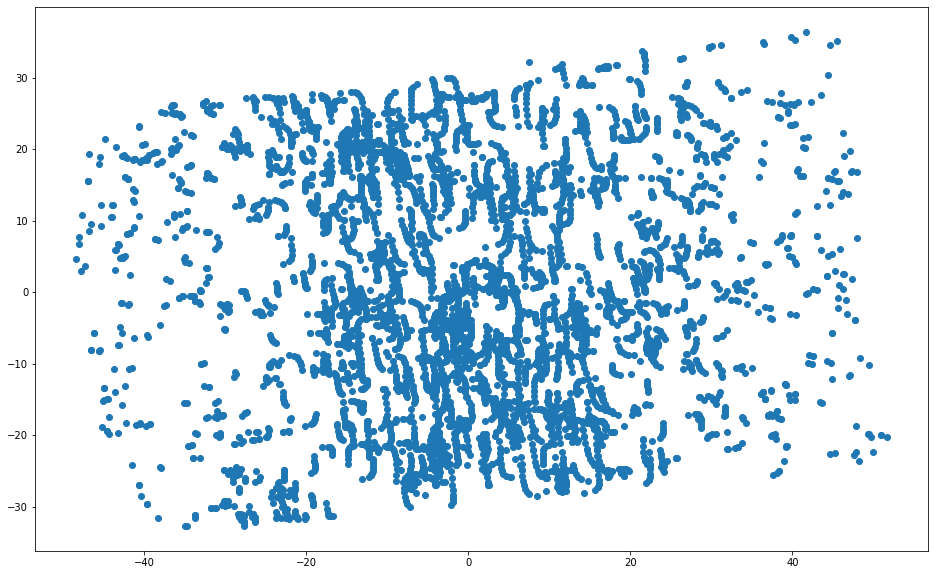

In [9]:
model.eval()
edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
sig = torch.nn.Sigmoid()

for batch in test_loader:
    data = batch.to(device)
    pred, spatial, e, av_nhood_size = model(data)

    e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=200)

    y_edge = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
    y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))   
    
    embedded = spatial.cpu().detach().numpy()    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embedded)
    #         print("PCA", pca_result)
    plt.figure(figsize=(16,10))
    plt.scatter(pca_result[:,0], pca_result[:,1])

    
    #Cluster performance
    cluster_true = len(batch.true_edges)

    cluster_true_positive = (y_cluster.float()).sum().item()
    cluster_total_true_positive += cluster_true_positive

    cluster_positive = len(e_spatial[0])
    cluster_total_positive += max(cluster_positive, 1)

    cluster_total_true += cluster_true

    #Edge performance
    edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
    edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

    edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

    edge_true_positive += (edge_true & edge_positive).sum().item()
    edge_total_true += edge_true.sum().item()
    edge_total_positive += edge_positive.sum().item()

    print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
    print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)
    
    total += len(pred)

        
edge_acc = edge_correct/total
edge_eff = (edge_true_positive / edge_total_true)
edge_pur = (edge_true_positive / edge_total_positive)

cluster_eff = (cluster_total_true_positive / cluster_total_true)
cluster_pur = (cluster_total_true_positive / cluster_total_positive)

print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))

## Pretrained AdjacentEmbAGNN

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Embedding(torch.nn.Module):
    def __init__(self, in_channels, nb_hidden, nb_layer, emb_dim=3):
        super(Embedding, self).__init__()
        layers = [Linear(in_channels, nb_hidden)]
        ln = [Linear(nb_hidden, nb_hidden) for _ in range(nb_layer-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(nb_hidden, emb_dim)
        self.norm = torch.nn.LayerNorm(nb_hidden)
        self.act = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.7)
#         self.mean = torch.FloatTensor(mean).to(torch.float)
#         self.std = torch.FloatTensor(std).to(torch.float)

    def forward(self, x):
#         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
            # hits = self.dropout(hits)
        x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

    def normalize(self, hits):
        try:
            hits = (hits-self.mean) / (self.std + 10**-9)
        except:
            self.mean = self.mean.to(device=hits.device)
            self.std  = self.std.to(device=hits.device)
            hits = (hits-self.mean) / (self.std + 10**-9)
        return hits

In [8]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)

class EmbAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_spatial_network = make_mlp(in_channels, [emb_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.input_feature_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
#         self.combine_network = make_mlp(emb_dim + hidden_dim, [hidden_dim],
#                                       output_activation=hidden_activation,
#                                       layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(emb_dim + hidden_dim, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.input_spatial_network(x)
        features = self.input_feature_network(x)
#         spatial = self.spatial_norm(spatial)
        edge_index = knn_graph(spatial, k=self.k, batch=inputs.batch, loop=False)
#         print(edge_index.shape)

        # Shortcut connect the inputs onto the hidden representation
#         x = torch.cat([spatial, features], dim=-1)
#         x = self.combine_network(x)
#         print(features.shape)    
#         print(spatial.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
#             x = torch.cat([spatial, features], dim=-1)
#             print(features.shape)            
            spatial = self.emb_network(torch.cat([features, spatial], axis=-1))
#             edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
            edge_index = knn_graph(spatial, k=self.k, batch=inputs.batch, loop=False)
#             print(edge_index.shape)
#             print(spatial.shape)
            # Shortcut connect the inputs onto the hidden representation            
#             features = torch.cat([x, inputs.x], dim=-1)
             
            features = features_inital + features
        
        return self.edge_network(features, edge_index), spatial, edge_index

class EmbAGNNBalanced(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, pretrained_model=None, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNNBalanced, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_network = make_mlp(emb_dim, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim + emb_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim + emb_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network = Embedding(in_channels, emb_hidden, nb_layer, emb_dim)
        self.emb_network.load_state_dict(embedding_model.state_dict())
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.emb_network(x)
#         spatial = self.spatial_norm(spatial)
        
#         edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
        edge_index = build_edges(spatial, self.r, 50, res)
#         print(edge_index.shape)
        x = self.input_network(spatial)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, spatial, inputs.x], dim=-1)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, edge_index))
        
            # Apply node network
            x = self.node_network(x, e, edge_index)
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, spatial, inputs.x], dim=-1)
             
            x = x_inital + x
        
        return self.edge_network(x, edge_index), spatial, edge_index

class EmbAGNNRecluster(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, emb_hidden=32, nb_layer=4, emb_dim=8, r=0.2, k=20, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(EmbAGNNRecluster, self).__init__()
        self.n_graph_iters = n_graph_iters
        self.r = r
        self.k = k
        # Setup the input network
        self.input_spatial_network = make_mlp(in_channels, [emb_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.input_feature_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
#         self.combine_network = make_mlp(emb_dim + hidden_dim, [hidden_dim],
#                                       output_activation=hidden_activation,
#                                       layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup gravnet
        self.emb_network_1 = Embedding(emb_dim + hidden_dim + in_channels, emb_hidden, nb_layer, emb_dim)
        self.emb_network_2 = Embedding(emb_dim + hidden_dim + in_channels, emb_hidden, nb_layer, emb_dim)
        
#         self.spatial_norm = torch.nn.LayerNorm(emb_dim)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""        
        x = inputs.x
#         print(x.shape)
        spatial = self.input_spatial_network(x)
        features = self.input_feature_network(x)
        spatial = self.emb_network_1(torch.cat([inputs.x, features, spatial], axis=-1))
        
        edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters//2):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
            features = features_inital + features
        
           
        spatial = self.emb_network_2(torch.cat([inputs.x, features, spatial], axis=-1))
        edge_index = radius_graph(spatial, r=self.r, batch=inputs.batch, loop=False, max_num_neighbors=50)
             
        for i in range(self.n_graph_iters//2):
            features_inital = features
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(features, edge_index))
        
            # Apply node network
            features = self.node_network(features, e, edge_index)
            features = features_inital + features
            
        
        return self.edge_network(features, edge_index), spatial, edge_index

In [93]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
                
#         e_spatial = radius_graph(spatial, r=m_configs["r_train"], batch=batch.batch, loop=False, max_num_neighbors=1000)
        e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_1 + loss_2
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
#         e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=1000)
        e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    

        hinge = y_cluster.float()
        hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())

        loss = loss_1.item() + loss_2.item()
        total_loss += loss
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [29]:
sig = torch.nn.Sigmoid()

def train_emb(model, train_loader, optimizer):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        tic  = tt()
        toc = tt()
        optimizer.zero_grad()
        data = batch.to(device)
        spatial = model(data.x)
        
#         print("Prediction:", tt() - toc)
        toc = tt()
        
        # Get fake edge list
#         candidates = radius_graph(spatial, r=m_configs['r_train'], batch=batch.batch, loop=False, max_num_neighbors=200)
        candidates = build_edges(spatial, m_configs['r_train'], 200, res)
#         print(candidates)
#         print(batch.pid)
        fake_list = candidates[:,batch.pid[candidates[0]] != batch.pid[candidates[1]]]
        
#         print(batch.pid[fake_list[0]] == batch.pid[fake_list[1]])
#         print("Radius graph:", tt() - toc)
        toc = tt()
        
        # Concatenate all candidates
        e_spatial = torch.cat([fake_list, batch.true_edges.T.to(device)], axis=-1)
#         print("Concatenate:", tt() - toc)
        toc = tt()
        
        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
#         print("Loss backprop:", tt() - toc)
        toc = tt()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)
#         print("Performance calc:", tt() - toc)
        toc = tt()
#         print("Num hits:", len(spatial), "Total positives:", len(e_spatial[0]), "Av nhood size:", len(e_spatial[0])/len(spatial), "in time:", tt()-tic )
#         print("CUDA mem:", torch.cuda.memory_allocated(0)/1000000000)
        
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return cluster_pur, total_loss

def evaluate_emb(model, test_loader):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        spatial = model(data.x)
        e_spatial = build_edges(spatial, m_configs['r_val'], 200, res)

        e_adjacent = e_spatial[:, (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]]) == 1]
        
        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
        y_cluster_all = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        y_cluster = (batch.pid[e_adjacent[0]] == batch.pid[e_adjacent[1]])
        hinge = y_cluster_all.float()
        hinge[hinge == 0] = -1

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        print("Loss:", loss.item())
        total_loss += loss.item()
        #Cluster performance
        cluster_true = len(batch.true_edges)

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive
        cluster_positive = len(e_adjacent[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true
        
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive, "Av nhood size:", len(e_spatial[0])/len(spatial), "Av adjacent nhood size:", len(e_adjacent[0])/len(spatial))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return cluster_pur, cluster_eff, total_loss

In [10]:
sig = torch.nn.Sigmoid()

def train(model, train_loader, optimizer, loss_fn):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred, spatial, e = model(data)
        
        
        # Get fake edge list
#         candidates = radius_graph(spatial, r=m_configs['r_train'], batch=batch.batch, loop=False, max_num_neighbors=200)
        
        candidates = build_edges(spatial, m_configs['r_train'], 200, res)
        fake_list = candidates[:,batch.pid[candidates[0]] != batch.pid[candidates[1]]]
        
#         print(batch.pid[fake_list[0]] == batch.pid[fake_list[1]])
        
        # Concatenate all candidates
        e_spatial = torch.cat([fake_list, batch.true_edges.T.to(device)], axis=-1)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
#         print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_fn([loss_1, loss_2])
#         print("Combined loss:", loss, "Noise params:", loss_fn.noise_params)
#         print(loss)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        
        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive 
        
        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()
        total += len(pred)

    edge_acc = edge_correct/total
    cluster_pur = (cluster_total_true_positive / cluster_total_positive)
    
    return edge_acc, cluster_pur, total_loss

def evaluate(model, test_loader, loss_fn):
    edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)
        
#         e_spatial = radius_graph(spatial, r=m_configs["r_val"], batch=batch.batch, loop=False, max_num_neighbors=200)
        e_spatial = build_edges(spatial, m_configs['r_val'], 200, res)
#         e_spatial = knn_graph(spatial, k=m_configs["k"], batch=batch.batch, loop=False)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_edge = ((batch.pid[e[0]] == batch.pid[e[1]]) & (batch.layers[e[1]] - batch.layers[e[0]] == 1))
        y_cluster = ((batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & (batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1))
        
        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
        loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=m_configs["margin"], reduction=m_configs["reduction"])
        print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
        loss = loss_fn([loss_1, loss_2]).item()
        print("Combined loss:", loss, "Noise params:", loss_fn.noise_params)
        total_loss += loss
        
        #Cluster performance
        cluster_true = len(batch.true_edges)

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

        #Edge performance
        edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
        edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

        edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

        edge_true_positive += (edge_true & edge_positive).sum().item()
        edge_total_true += edge_true.sum().item()
        edge_total_positive += edge_positive.sum().item()

        print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
        print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)

        total += len(pred)

    edge_acc = edge_correct/total
    edge_eff = (edge_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_true_positive / max(edge_total_positive, 1))

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))

    print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
    print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))
    
    return edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, total_loss

In [11]:
class MultiNoiseLoss(nn.Module):
    def __init__(self, n_losses):
        super(MultiNoiseLoss, self).__init__()
        self.noise_params = torch.rand(n_losses, requires_grad=True, device="cuda:0")
    
    def forward(self, losses):
        
        total_loss = 0
        for i, loss in enumerate(losses):
            total_loss += (1/torch.square(self.noise_params[i]))*loss + torch.log(self.noise_params[i])
        
        return total_loss

In [12]:
res = faiss.StandardGpuResources()

def swig_ptr_from_FloatTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.float32
    return faiss.cast_integer_to_float_ptr(
        x.storage().data_ptr() + x.storage_offset() * 4)

def swig_ptr_from_LongTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.int64, 'dtype=%s' % x.dtype
    return faiss.cast_integer_to_long_ptr(
        x.storage().data_ptr() + x.storage_offset() * 8)

def search_index_pytorch(index, x, k, D=None, I=None):
    """call the search function of an index with pytorch tensor I/O (CPU
    and GPU supported)"""
    assert x.is_contiguous()
    n, d = x.size()
    assert d == index.d

    if D is None:
        D = torch.empty((n, k), dtype=torch.float32, device=x.device)
    else:
        assert D.size() == (n, k)

    if I is None:
        I = torch.empty((n, k), dtype=torch.int64, device=x.device)
    else:
        assert I.size() == (n, k)
    torch.cuda.synchronize()
    xptr = swig_ptr_from_FloatTensor(x)
    Iptr = swig_ptr_from_LongTensor(I)
    Dptr = swig_ptr_from_FloatTensor(D)
    index.search_c(n, xptr,
                   k, Dptr, Iptr)
    torch.cuda.synchronize()
    return D, I

def build_edges(spatial, r_max, k_max, res, return_indices=False):
    
    index_flat = faiss.IndexFlatL2(spatial.shape[1])
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
    spatial_np = spatial.cpu().detach().numpy()
    gpu_index_flat.add(spatial_np)
    
    D, I = search_index_pytorch(gpu_index_flat, spatial, k_max)
    
    D, I = D[:,1:], I[:,1:]
    ind = torch.Tensor.repeat(torch.arange(I.shape[0]), (I.shape[1], 1), 1).T.to(device)
    edge_list = torch.stack([ind[D <= r_max**2], I[D <= r_max**2]])
    
    if return_indices:
        return edge_list, D, I, ind
    else:
        return edge_list

In [30]:
m_configs = {"in_channels": 3, "nb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"k": 20, "r_train": 0.805, "r_val": 1.14, "margin": 1.34, 'reduction':'mean'}
embedding_model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="PretrainedAdjacentEmbAGNN", config=m_configs)
wandb.watch(embedding_model, log='all')
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=30)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [31]:
weight = 1
for epoch in range(30):
    tic = tt()
    embedding_model.train()
    cluster_pur, train_loss = train_emb(embedding_model, train_loader, optimizer)
    print("Training loss:", train_loss)

    embedding_model.eval()
    with torch.no_grad():
        cluster_pur, cluster_eff, val_loss = evaluate_emb(embedding_model, test_loader)
    scheduler.step(val_loss)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0]})

    save_model(epoch, embedding_model, optimizer, scheduler, val_loss, m_configs, 'PretrainedEmb/'+model_name._name+'.tar')

    print('Epoch: {}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, cluster_pur, cluster_eff, val_loss, scheduler._last_lr[0], tt()-tic))

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 120.14755761623383
Loss: 0.5996936559677124
CLUSTER: True positive: 12711.0 True: 36051 Positive: 104926 Av nhood size: 17.56704621567314 Av adjacent nhood size: 2.8111453449430677
Loss: 0.5956023931503296
CLUSTER: True positive: 14792.0 True: 40280 Positive: 137239 Av nhood size: 20.082733641519326 Av adjacent nhood size: 3.2702425773245007
Loss: 0.592609167098999
CLUSTER: True positive: 17855.0 True: 49715 Positive: 192986 Av nhood size: 23.58814884486509 Av adjacent nhood size: 3.7815923030196146
Loss: 0.5928072333335876
CLUSTER: True positive: 17967.0 True: 49979 Positive: 201808 Av nhood size: 24.18229237099859 Av adjacent nhood size: 3.898692115990186
Loss: 0.5924283862113953
CLUSTER: True positive: 16063.0 True: 45018 Positive: 164510 Av nhood size: 21.93592637984046 Av adjacent nhood size: 3.5371648498140145
Loss: 0.5935187935829163
CLUSTER: True positive: 15972.0 True: 45580 Positive: 170164 Av nhood size: 22.376977931558294 Av adjacent nhood size: 3.59010928731

Loss: 0.5689879059791565
CLUSTER: True positive: 25418.0 True: 40280 Positive: 212966 Av nhood size: 22.264976409474336 Av adjacent nhood size: 5.074727160081971
Loss: 0.5640265941619873
CLUSTER: True positive: 31254.0 True: 49715 Positive: 307823 Av nhood size: 26.489722336527343 Av adjacent nhood size: 6.031842141359513
Loss: 0.5714449882507324
CLUSTER: True positive: 22454.0 True: 36051 Positive: 169603 Av nhood size: 19.818325519089083 Av adjacent nhood size: 4.5439517749497655
Loss: 0.5663518905639648
CLUSTER: True positive: 30427.0 True: 47952 Positive: 291384 Av nhood size: 25.867017536811233 Av adjacent nhood size: 5.853317530784838
CLUSTER Purity: 0.1083, Efficiency: 0.6261
Epoch: 4, Cluster Purity: 0.1083, Cluster Efficiency: 0.6261, Loss: 5.6613, LR: 0.001 in time 12.964998483657837
Training loss: 117.97869753837585
Loss: 0.5666696429252625
CLUSTER: True positive: 25559.0 True: 43523 Positive: 300540 Av nhood size: 27.369057640334944 Av adjacent nhood size: 6.657658056798547

Loss: 0.5482383370399475
CLUSTER: True positive: 28087.0 True: 47952 Positive: 264051 Av nhood size: 23.26321287238103 Av adjacent nhood size: 5.304252626504088
Loss: 0.5491316318511963
CLUSTER: True positive: 26037.0 True: 45580 Positive: 244189 Av nhood size: 22.435798978859868 Av adjacent nhood size: 5.151884045740327
Loss: 0.5505145192146301
CLUSTER: True positive: 23442.0 True: 40258 Positive: 189545 Av nhood size: 19.74318487233634 Av adjacent nhood size: 4.548497792282588
Loss: 0.547477126121521
CLUSTER: True positive: 25966.0 True: 45018 Positive: 237636 Av nhood size: 22.278698746479176 Av adjacent nhood size: 5.109462684641683
Loss: 0.5537658929824829
CLUSTER: True positive: 20598.0 True: 36051 Positive: 154967 Av nhood size: 17.963241795043537 Av adjacent nhood size: 4.151828533154722
Loss: 0.5453077554702759
CLUSTER: True positive: 28644.0 True: 49715 Positive: 282438 Av nhood size: 24.123802245605784 Av adjacent nhood size: 5.534418905414144
Loss: 0.5489239692687988
CLUSTE

Loss: 0.532219648361206
CLUSTER: True positive: 24029.0 True: 45018 Positive: 228665 Av nhood size: 21.1823948053065 Av adjacent nhood size: 4.916575286503687
CLUSTER Purity: 0.1031, Efficiency: 0.5342
Epoch: 13, Cluster Purity: 0.1031, Cluster Efficiency: 0.5342, Loss: 5.3366, LR: 0.001 in time 13.246029615402222
Training loss: 114.51016247272491
Loss: 0.5291703939437866
CLUSTER: True positive: 29155.0 True: 49979 Positive: 275251 Av nhood size: 22.558429766435484 Av adjacent nhood size: 5.31752410022603
Loss: 0.536081850528717
CLUSTER: True positive: 24361.0 True: 40280 Positive: 184353 Av nhood size: 18.438497831577944 Av adjacent nhood size: 4.3929133107753895
Loss: 0.5316466093063354
CLUSTER: True positive: 28917.0 True: 47952 Positive: 255038 Av nhood size: 21.680761736405454 Av adjacent nhood size: 5.123199614310681
Loss: 0.532642662525177
CLUSTER: True positive: 23880.0 True: 40258 Positive: 181098 Av nhood size: 18.27615665194855 Av adjacent nhood size: 4.345795738145517
Loss:

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-861981424283>", line 5, in <module>
    cluster_pur, train_loss = train_emb(embedding_model, train_loader, optimizer)
  File "<ipython-input-29-542a5a74c948>", line 21, in train_emb
    candidates = build_edges(spatial, m_configs['r_train'], 200, res)
  File "<ipython-input-12-5b76e4e55ce7>", line 44, in build_edges
    spatial_np = spatial.cpu().detach().numpy()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of t

KeyboardInterrupt: 

### ANNOY Exploration

In [26]:
from annoy import AnnoyIndex

In [30]:
spatial.shape

torch.Size([48101, 8])

In [34]:
%%time

## Template for ANN Hashing
f = 8
t = AnnoyIndex(f, 'euclidean')  # Length of item vector that will be indexed
for i, hit in enumerate(spatial):
    t.add_item(i, hit)

t.build(1) # 10 trees
# t.save('test.ann')

CPU times: user 5.74 s, sys: 495 ms, total: 6.24 s
Wall time: 6.23 s


True

In [40]:
%%time
nns = []
for i, _ in enumerate(spatial):
    nns.append(t.get_nns_by_item(i,50))

CPU times: user 601 ms, sys: 23.9 ms, total: 625 ms
Wall time: 624 ms


### FAISS Exploration

In [117]:
embedding_model.eval()
for batch in test_loader:
        data = batch.to(device)
        spatial = embedding_model(data.x)

In [118]:
import faiss
import cupy as cp

In [82]:
res = faiss.StandardGpuResources()
res.setDefaultNullStreamAllDevices()

In [10]:
d = 64                           # dimension
nb = 100000                      # database size
nq = 100000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

In [54]:
%%time
index_flat = faiss.IndexFlatL2(d)
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
gpu_index_flat.add(xb)

CPU times: user 5.3 ms, sys: 2.72 ms, total: 8.03 ms
Wall time: 7.23 ms


In [13]:
%%time
D, I = gpu_index_flat.search(xq, 50)

CPU times: user 213 ms, sys: 75.6 ms, total: 288 ms
Wall time: 287 ms


In [57]:
xq_gpu = cp.asarray(xq)

In [58]:
xq_gpu

array([[8.14329743e-01, 7.40996897e-01, 8.91532421e-01, ...,
        7.24596739e-01, 8.93881023e-01, 6.57457113e-01],
       [5.84477425e-01, 7.97842026e-01, 7.41404533e-01, ...,
        6.76883519e-01, 5.90792410e-02, 6.39615595e-01],
       [7.50407636e-01, 2.65979394e-02, 5.49509704e-01, ...,
        6.95624650e-01, 1.62685320e-01, 7.66537368e-01],
       ...,
       [1.00677185e+02, 2.21832111e-01, 5.13182640e-01, ...,
        9.97802138e-01, 4.58331853e-01, 7.20675349e-01],
       [1.00069405e+02, 6.27276421e-01, 2.15504412e-02, ...,
        2.19979703e-01, 5.02057672e-01, 9.47635233e-01],
       [1.00506104e+02, 2.05554649e-01, 3.66396718e-02, ...,
        5.37512124e-01, 9.09505725e-01, 5.31684816e-01]], dtype=float32)

In [63]:
%%time
gpu_index_flat = faiss.GpuIndexFlatL2(res, d)
gpu_index_flat.add(xb)

CPU times: user 5.69 ms, sys: 2.91 ms, total: 8.59 ms
Wall time: 7.72 ms


In [59]:
%%time
D, I = gpu_index_flat.search(xq_gpu, 50)

ValueError: input not a numpy array

In [24]:
cp.array([0,1,2,3])

array([0, 1, 2, 3])

In [23]:
cp.cuda.Device()

<CUDA Device 0>

In [24]:
%%time
build_edges(spatial, 0.1, 100, res)

NameError: name 'spatial' is not defined

In [120]:
%%time
d = 8
index_flat = faiss.IndexFlatL2(d)
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

CPU times: user 361 µs, sys: 116 µs, total: 477 µs
Wall time: 364 µs


In [121]:
%%time
spatial_np = spatial.cpu().detach().numpy()
gpu_index_flat.add(spatial_np)

CPU times: user 839 µs, sys: 4.27 ms, total: 5.11 ms
Wall time: 4.03 ms


In [123]:
%%time
D, I = gpu_index_flat.search(spatial_np, 200)

CPU times: user 77.4 ms, sys: 20.4 ms, total: 97.8 ms
Wall time: 96.6 ms


In [124]:
%%time
D, I = search_index_pytorch(gpu_index_flat, spatial, 200)

CPU times: user 38.7 ms, sys: 0 ns, total: 38.7 ms
Wall time: 38 ms


In [125]:
%%time
D, I

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


(tensor([[0.0000e+00, 3.8016e-04, 4.1199e-04,  ..., 1.4759e-02, 1.5091e-02,
          1.5093e-02],
         [0.0000e+00, 2.1684e-04, 6.2001e-04,  ..., 1.6707e-02, 1.6738e-02,
          1.6849e-02],
         [0.0000e+00, 2.1684e-04, 3.9864e-04,  ..., 1.7937e-02, 1.7948e-02,
          1.8054e-02],
         ...,
         [2.3842e-07, 5.1379e-05, 5.2691e-05,  ..., 5.4043e-02, 5.4109e-02,
          5.4271e-02],
         [0.0000e+00, 5.0068e-05, 1.0407e-04,  ..., 5.0346e-02, 5.0490e-02,
          5.0570e-02],
         [2.3842e-07, 1.5378e-05, 5.0068e-05,  ..., 5.1983e-02, 5.2025e-02,
          5.2102e-02]], device='cuda:0'),
 tensor([[    0,  7177,  7184,  ...,  7571, 22585, 22374],
         [    1,     2,  7218,  ...,   105, 22868,   322],
         [    2,     1,  7216,  ...,  7228, 17813, 22608],
         ...,
         [42239, 42241, 42237,  ..., 35141, 38009, 35147],
         [42240, 42241, 42237,  ..., 35146, 41910, 35509],
         [42241, 42237, 42240,  ..., 35146, 38007, 41904]], devi

tensor([[    0,     0,     0,  ...,     0,     0,     0],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    2,     2,     2,  ...,     2,     2,     2],
        ...,
        [42239, 42239, 42239,  ..., 42239, 42239, 42239],
        [42240, 42240, 42240,  ..., 42240, 42240, 42240],
        [42241, 42241, 42241,  ..., 42241, 42241, 42241]])

In [144]:
D, I = D[:,1:], I[:,1:]
ind = torch.Tensor.repeat(torch.arange(I.shape[0]), (I.shape[1], 1), 1).T.to(device)
edge_list = torch.stack([ind[D <= 0.1**2], I[D <= 0.1**2]])

In [114]:
%%time
D, I = D[:,1:], I[:,1:]
ind = np.tile(np.arange(I.shape[0]), (I.shape[1], 1)).T
edge_stack = np.stack([ind, I])
edge_stack = np.moveaxis(edge_stack, 0, 2)
edge_list = np.concatenate(edge_stack)

CPU times: user 50.4 ms, sys: 19.5 ms, total: 70 ms
Wall time: 68.9 ms


In [224]:
e_spatial = radius_graph(spatial, r=0.1, batch=batch.batch, loop=False, max_num_neighbors=49)

### Using Pretrained Embedding

In [37]:
m_configs = {"in_channels": 3, "nb_hidden": 512, "nb_layer": 6, "emb_dim": 15}
other_configs = {"k": 20, "r_train": 0.805, "r_val": 1.14, "margin": 1.34, 'reduction':'mean'}
embedding_model = Embedding(**m_configs).to(device)
checkpoint = torch.load('../model_comparisons/PretrainedEmb/laced-plasma-368.tar')
embedding_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [157]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8,  "pretrained_model": embedding_model, "r": 1.14, "hidden_dim": 32, "n_graph_iters": 2}
other_configs = {"k": 20, "r_train": 0.805, "r_val": 1.14, "margin": 1.34, 'reduction':'mean'}
model = EmbAGNNBalanced(**m_configs).to(device)
multi_loss = MultiNoiseLoss(n_losses=2).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="AdjacentEmbAGNN", config=m_configs)
wandb.watch(model, log='all')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


In [158]:
optimizer = torch.optim.AdamW([
    {'params': model.emb_network.parameters()},
    {'params': chain(model.node_network.parameters(), model.edge_network.parameters(), model.input_network.parameters())},
    {'params': multi_loss.noise_params}],
lr = 0.001, weight_decay=1e-3, amsgrad=True)

In [159]:
lambda1 = lambda ep: 1 / (1.5**(ep//10))
lambda2 = lambda ep: 1 / (1.5**(ep//30))
lambda3 = lambda ep: 1 / (1.1**(ep//10))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2, lambda3])

In [160]:
weight = 1
for epoch in range(100):
    tic = tt()
    model.train()
    edge_acc, cluster_pur, train_loss = train(model, train_loader, optimizer, multi_loss)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss = evaluate(model, test_loader, multi_loss)
    scheduler.step(val_loss)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_acc": edge_acc, "edge_pur": edge_pur, "edge_eff": edge_eff, "cluster_pur": cluster_pur, "cluster_eff": cluster_eff, "lr": scheduler._last_lr[0]})

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'PretrainedEmb/'+model_name._name+'.tar')

    print('Epoch: {}, Edge Accuracy: {:.4f}, Edge Purity: {:.4f}, Edge Efficiency: {:.4f}, Cluster Purity: {:.4f}, Cluster Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, edge_acc, edge_pur, edge_eff, cluster_pur, cluster_eff, val_loss, scheduler._last_lr[0], tt()-tic))

RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 15.78 GiB total capacity; 7.33 GiB already allocated; 51.44 MiB free; 8.48 GiB reserved in total by PyTorch)

### Results

In [14]:
model.eval()
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

pur, eff = [], []
r_min, r_max, r_step = 0.1, 1, 0.1


for r in np.arange(r_min, r_max, r_step):
    cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0
    for batch in test_loader:
        data = batch.to(device)
        pred, spatial, e = model(data)

        e_spatial = radius_graph(spatial, r=r, batch=batch.batch, loop=False, max_num_neighbors=1000)

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])

        d = torch.sum((reference - neighbors)**2, dim=-1)

        y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
        print("r", r, "e len", len(e_spatial[0]))

        #Cluster performance
        batch_cpu = batch.pid.cpu()
        pids, counts = np.unique(batch_cpu, return_counts=True)
        cluster_true = (counts * (counts - 1)).sum()

        cluster_true_positive = (y_cluster.float()).sum().item()
        cluster_total_true_positive += cluster_true_positive

        cluster_positive = len(e_spatial[0])
        cluster_total_positive += max(cluster_positive, 1)

        cluster_total_true += cluster_true

    eff.append(cluster_total_true_positive / cluster_total_true)
    pur.append(cluster_total_true_positive / cluster_total_positive)
    
pur, eff = np.array(pur), np.array(eff)

r 0.1 e len 40642
r 0.1 e len 41948
r 0.1 e len 40780
r 0.1 e len 37382
r 0.1 e len 43624
r 0.1 e len 38442
r 0.1 e len 30972
r 0.1 e len 18204
r 0.1 e len 39448
r 0.1 e len 33024
r 0.2 e len 165878
r 0.2 e len 165290
r 0.2 e len 193562
r 0.2 e len 211956
r 0.2 e len 212452
r 0.2 e len 224848
r 0.2 e len 208902
r 0.2 e len 203168
r 0.2 e len 188948
r 0.2 e len 91736
r 0.30000000000000004 e len 521502
r 0.30000000000000004 e len 396890
r 0.30000000000000004 e len 226602
r 0.30000000000000004 e len 513222
r 0.30000000000000004 e len 413360
r 0.30000000000000004 e len 497994
r 0.30000000000000004 e len 514682
r 0.30000000000000004 e len 477138
r 0.30000000000000004 e len 551664
r 0.30000000000000004 e len 460548
r 0.4 e len 768486
r 0.4 e len 837312
r 0.4 e len 956844
r 0.4 e len 876332
r 0.4 e len 1009708
r 0.4 e len 924516
r 0.4 e len 417740
r 0.4 e len 946050
r 0.4 e len 717312
r 0.4 e len 936506
r 0.5 e len 1217050
r 0.5 e len 1579904
r 0.5 e len 1114560
r 0.5 e len 659440
r 0.5 e len

In [90]:
pur, eff = np.array(pur), np.array(eff)

In [15]:
pur, eff

(array([0.04886588, 0.02879242, 0.02019021, 0.01550792, 0.01199519,
        0.00972997, 0.00815024, 0.00703596, 0.00622132]),
 array([0.04706411, 0.14203266, 0.24401987, 0.34386132, 0.41815972,
        0.48530205, 0.54561598, 0.60048095, 0.62897046]))

Text(0.5, 0.95, 'AUC: 0.0057')

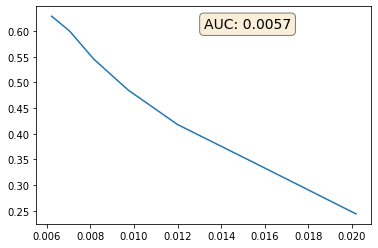

In [16]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(pur[2:], eff[2:])
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(pur[2:], eff[2:])), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

Loss 1: 0.03238826245069504 Loss 2: 0.998380184173584
EDGES: True positive: 29786 True: 29820 Positive 30880
CLUSTER: True positive: 7157.0 True: 29820 Positive: 4418414
Loss 1: 0.03371492400765419 Loss 2: 0.9987834095954895
EDGES: True positive: 39653 True: 39720 Positive 40917
CLUSTER: True positive: 6968.0 True: 39720 Positive: 5727722
Loss 1: 0.03964247554540634 Loss 2: 0.9985302686691284
EDGES: True positive: 33020 True: 33098 Positive 34415
CLUSTER: True positive: 7125.0 True: 33098 Positive: 4847843
Loss 1: 0.0368376150727272 Loss 2: 0.9986147880554199
EDGES: True positive: 34819 True: 34914 Positive 35968
CLUSTER: True positive: 7069.0 True: 34914 Positive: 5103098
Loss 1: 0.034479089081287384 Loss 2: 0.9987242817878723
EDGES: True positive: 37968 True: 38032 Positive 39321
CLUSTER: True positive: 6924.0 True: 38032 Positive: 5427422
Loss 1: 0.033777471631765366 Loss 2: 0.9988492727279663
EDGES: True positive: 41022 True: 41080 Positive 42427
CLUSTER: True positive: 6832.0 True

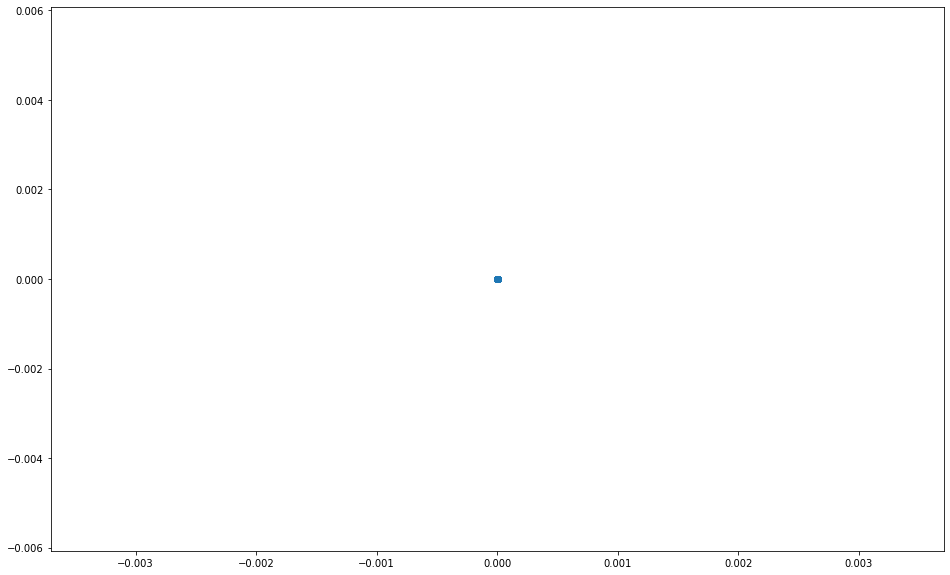

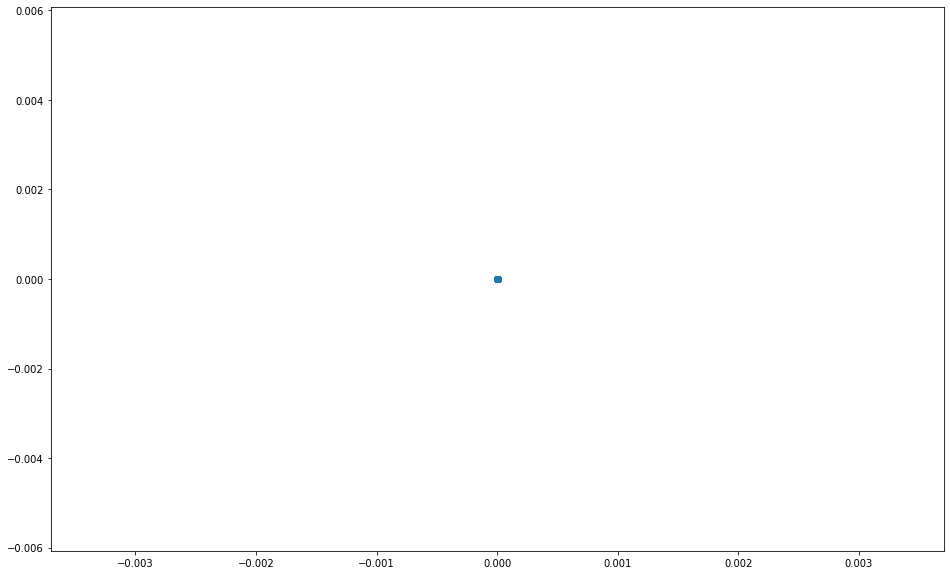

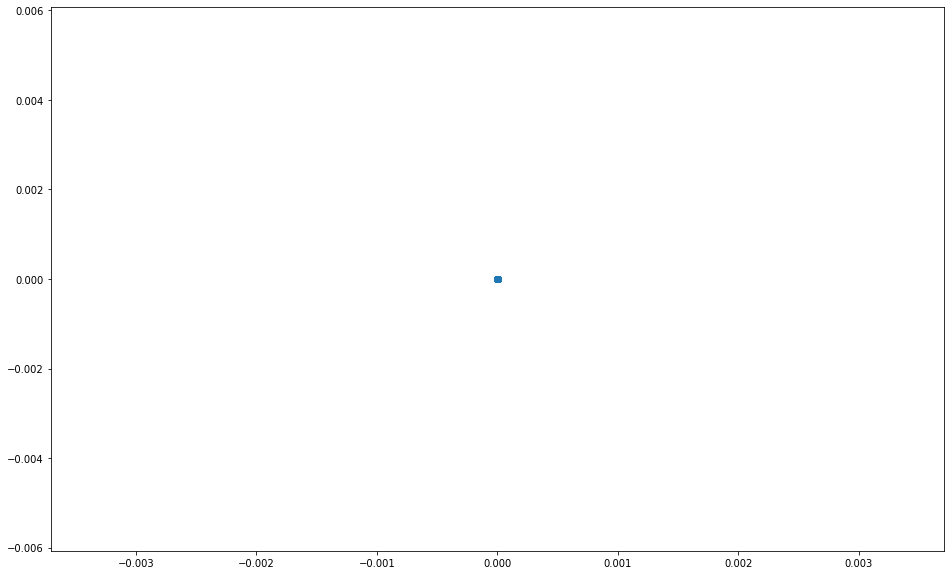

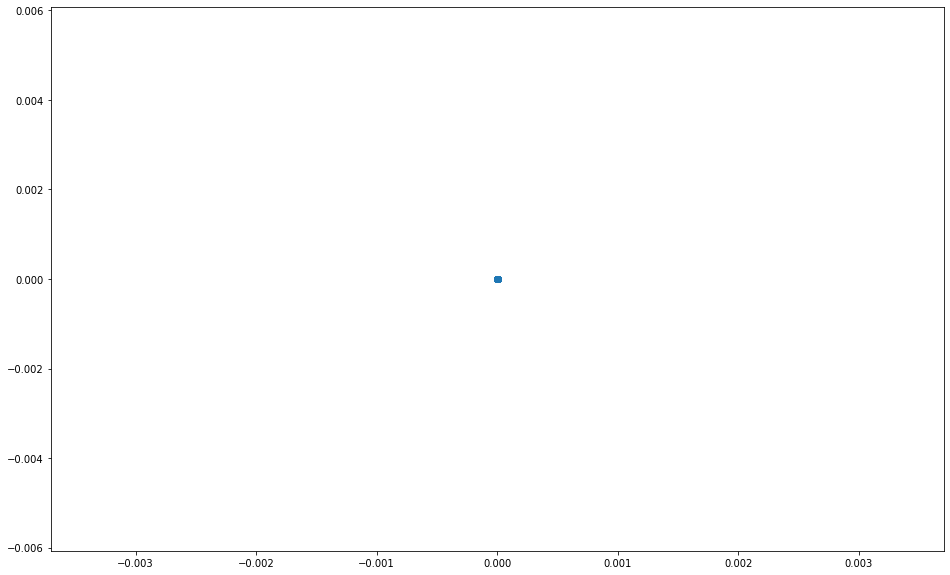

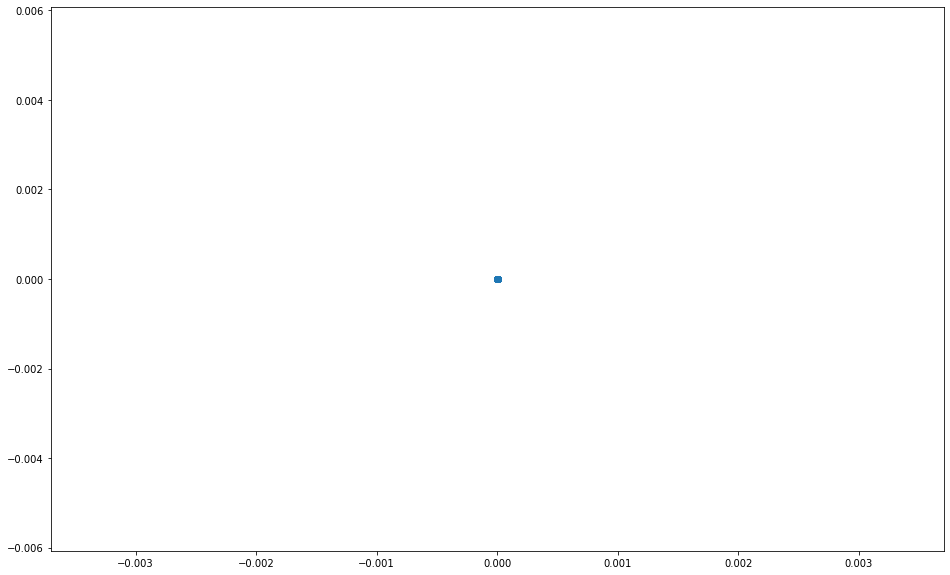

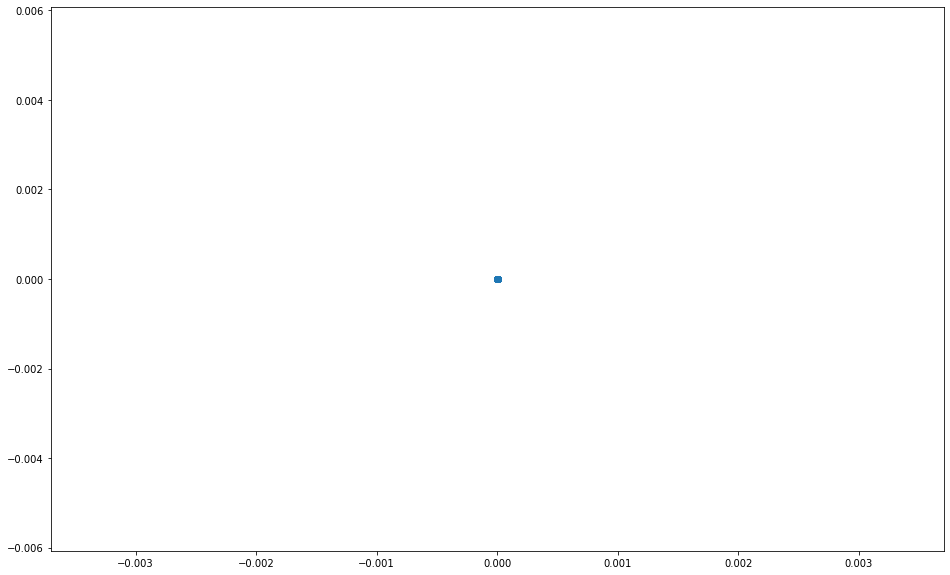

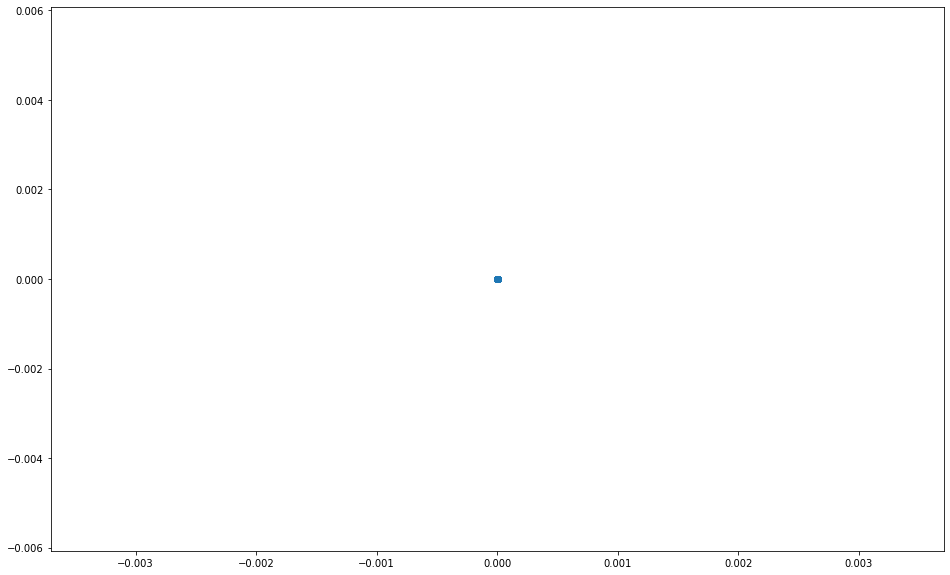

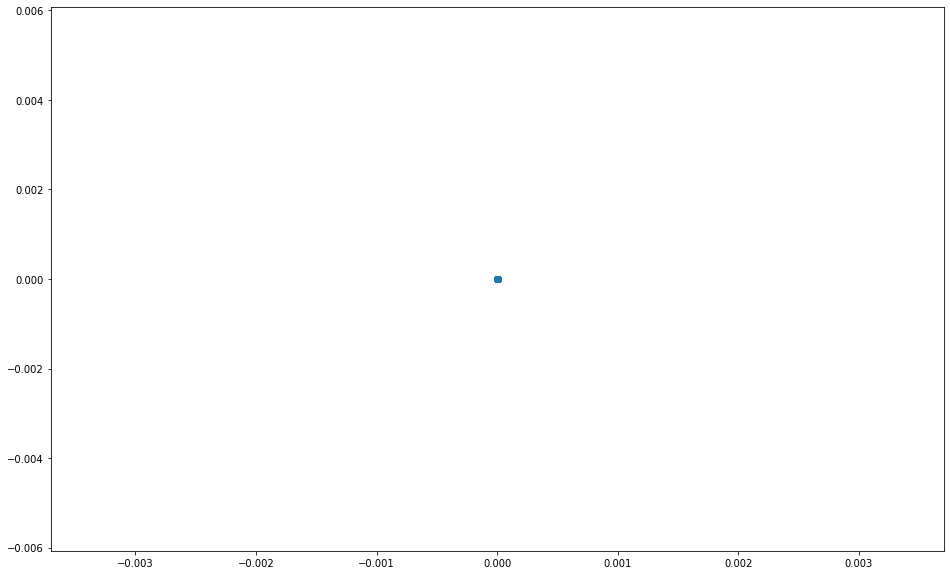

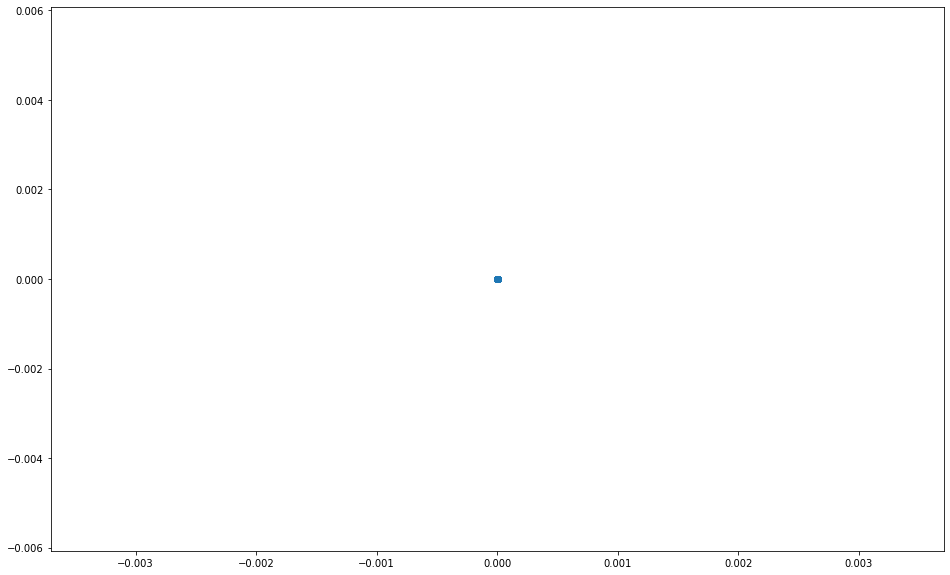

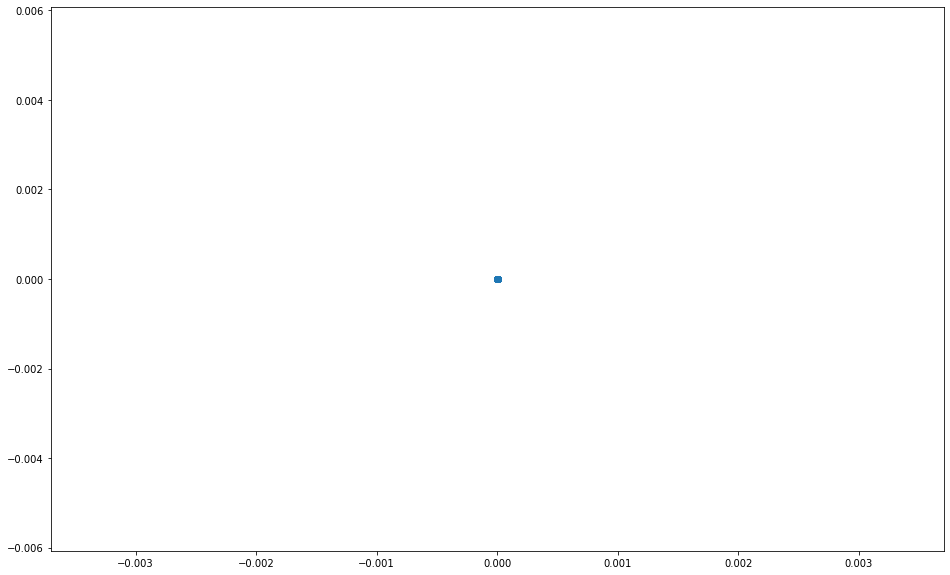

In [58]:
model.eval()
edge_correct, edge_total_positive, edge_total_true, edge_true_positive, total = 0, 1, 0, 0, 0
cluster_correct, cluster_total_positive, cluster_total_true, cluster_total_true_positive, cluster_total = 0, 1, 0, 0, 0

for batch in test_loader:
    data = batch.to(device)
    pred, spatial, e = model(data)

    e_spatial = radius_graph(spatial, r=1, batch=batch.batch, loop=False, max_num_neighbors=1000)

    reference = spatial.index_select(0, e_spatial[1])
    neighbors = spatial.index_select(0, e_spatial[0])

    d = torch.sum((reference - neighbors)**2, dim=-1)

    y_edge = batch.pid[e[0]] == batch.pid[e[1]]    
    y_cluster = batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]    
    
    
    hinge = y_cluster.float()
    hinge[batch.pid[e_spatial[0]] != batch.pid[e_spatial[1]]] = -1  
    
    loss_1 = F.binary_cross_entropy_with_logits(pred.float(), y_edge.float(), pos_weight=torch.tensor(weight))
    loss_2 = torch.nn.functional.hinge_embedding_loss(d, hinge)#, margin=m_configs["r"])
    print("Loss 1:", loss_1.item(), "Loss 2:", loss_2.item())
    
    embedded = spatial.cpu().detach().numpy()    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embedded)
    #         print("PCA", pca_result)
    plt.figure(figsize=(16,10))
    plt.scatter(pca_result[:,0], pca_result[:,1])

    #Cluster performance
    batch_cpu = batch.pid.cpu()
    pids, counts = np.unique(batch_cpu, return_counts=True)
    cluster_true = (counts * (counts - 1)).sum()

    cluster_true_positive = (y_cluster.float()).sum().item()
    cluster_total_true_positive += cluster_true_positive
    
    cluster_positive = len(e_spatial[0])
    cluster_total_positive += max(cluster_positive, 1)

    cluster_total_true += cluster_true
    
    #Edge performance
    edge_true, edge_false = y_edge.float() > 0.5, y_edge.float() < 0.5
    edge_positive, edge_negative = sig(pred) > 0.5, sig(pred) < 0.5

    edge_correct += ((sig(pred) > 0.5) == (y_edge.float() > 0.5)).sum().item()

    edge_true_positive += (edge_true & edge_positive).sum().item()
    edge_total_true += edge_true.sum().item()
    edge_total_positive += edge_positive.sum().item()

    print("EDGES:", "True positive:", (edge_true & edge_positive).sum().item(), "True:", edge_true.sum().item(), "Positive", edge_positive.sum().item())
    print("CLUSTER:", "True positive:", cluster_true_positive, "True:", cluster_true, "Positive:", cluster_positive)
    
    total += len(pred)

edge_acc = edge_correct/total
edge_eff = (edge_true_positive / edge_total_true)
edge_pur = (edge_true_positive / edge_total_positive)

cluster_eff = (cluster_total_true_positive / cluster_total_true)
cluster_pur = (cluster_total_true_positive / cluster_total_positive)

print('EDGE Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}'.format(edge_acc, edge_pur, edge_eff))
print('CLUSTER Purity: {:.4f}, Efficiency: {:.4f}'.format(cluster_pur, cluster_eff))